import numpy as np
import progressbar
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from collections import Counter 
from glob import glob
#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
#from tensorflow.keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import load_img

In [1]:
!pip install counter
! pip install nltk  
!pip install progressbar

  Preparing metadata (setup.py) ... done
  Created wheel for counter: filename=Counter-1.0.0-py3-none-any.whl size=5411 sha256=8345993c05fe5e43da084e908bec664179363495ed3bf0d7f8b9925e73db3159
  Stored in directory: /root/.cache/pip/wheels/e3/02/6d/d5c0838427a060718c6060ae4d24da95a0e0df0d7a3dab8040
Successfully built counter
  Preparing metadata (setup.py) ... done
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=4e126eb1cdf2c9ab4a862beaf059a0842188004c8fd49c389703e5746e728106
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built progressbar


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from  tensorflow.keras.layers import concatenate, BatchNormalization, Input
from  tensorflow.keras.utils import to_categorical
from  tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from  tensorflow.keras.utils import plot_model
import progressbar
from tqdm import tqdm

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from collections import Counter 
from tensorflow.keras.preprocessing.image import load_img
from nltk.tokenize import word_tokenize

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
text = "/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr8k.token.txt"

In [4]:
images_path = '/kaggle/input/flikr8k/Flickr8K/Flicker8k_Images'
images = os.listdir(images_path)
print("The number of jpg flies in Flicker30k: {}".format(len(images)))

The number of jpg flies in Flicker30k: 8091


In [30]:
from keras.applications import EfficientNetB0

base_model =  EfficientNetB0(include_top=True,weights='imagenet')
base_model.summary()

21834768/21834768 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescal

In [6]:
last = base_model.layers[-2].output
model = Model(inputs = base_model.input,outputs = last)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
captions = open(text, 'rb').read().decode('utf-8').split('\n')
len(captions)

40461

In [8]:
#loading as dataframe
def load_csv(directory):
    desc=dict()
    text = pd.read_csv(directory, delimiter='|',header=None,names=["filename","index","caption"])
    text = text.iloc[1:,:]
    df_new = text[text.iloc[:,2].notnull()]
    print(df_new.iloc[:5,:])
    return df_new

In [9]:
file = open(text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

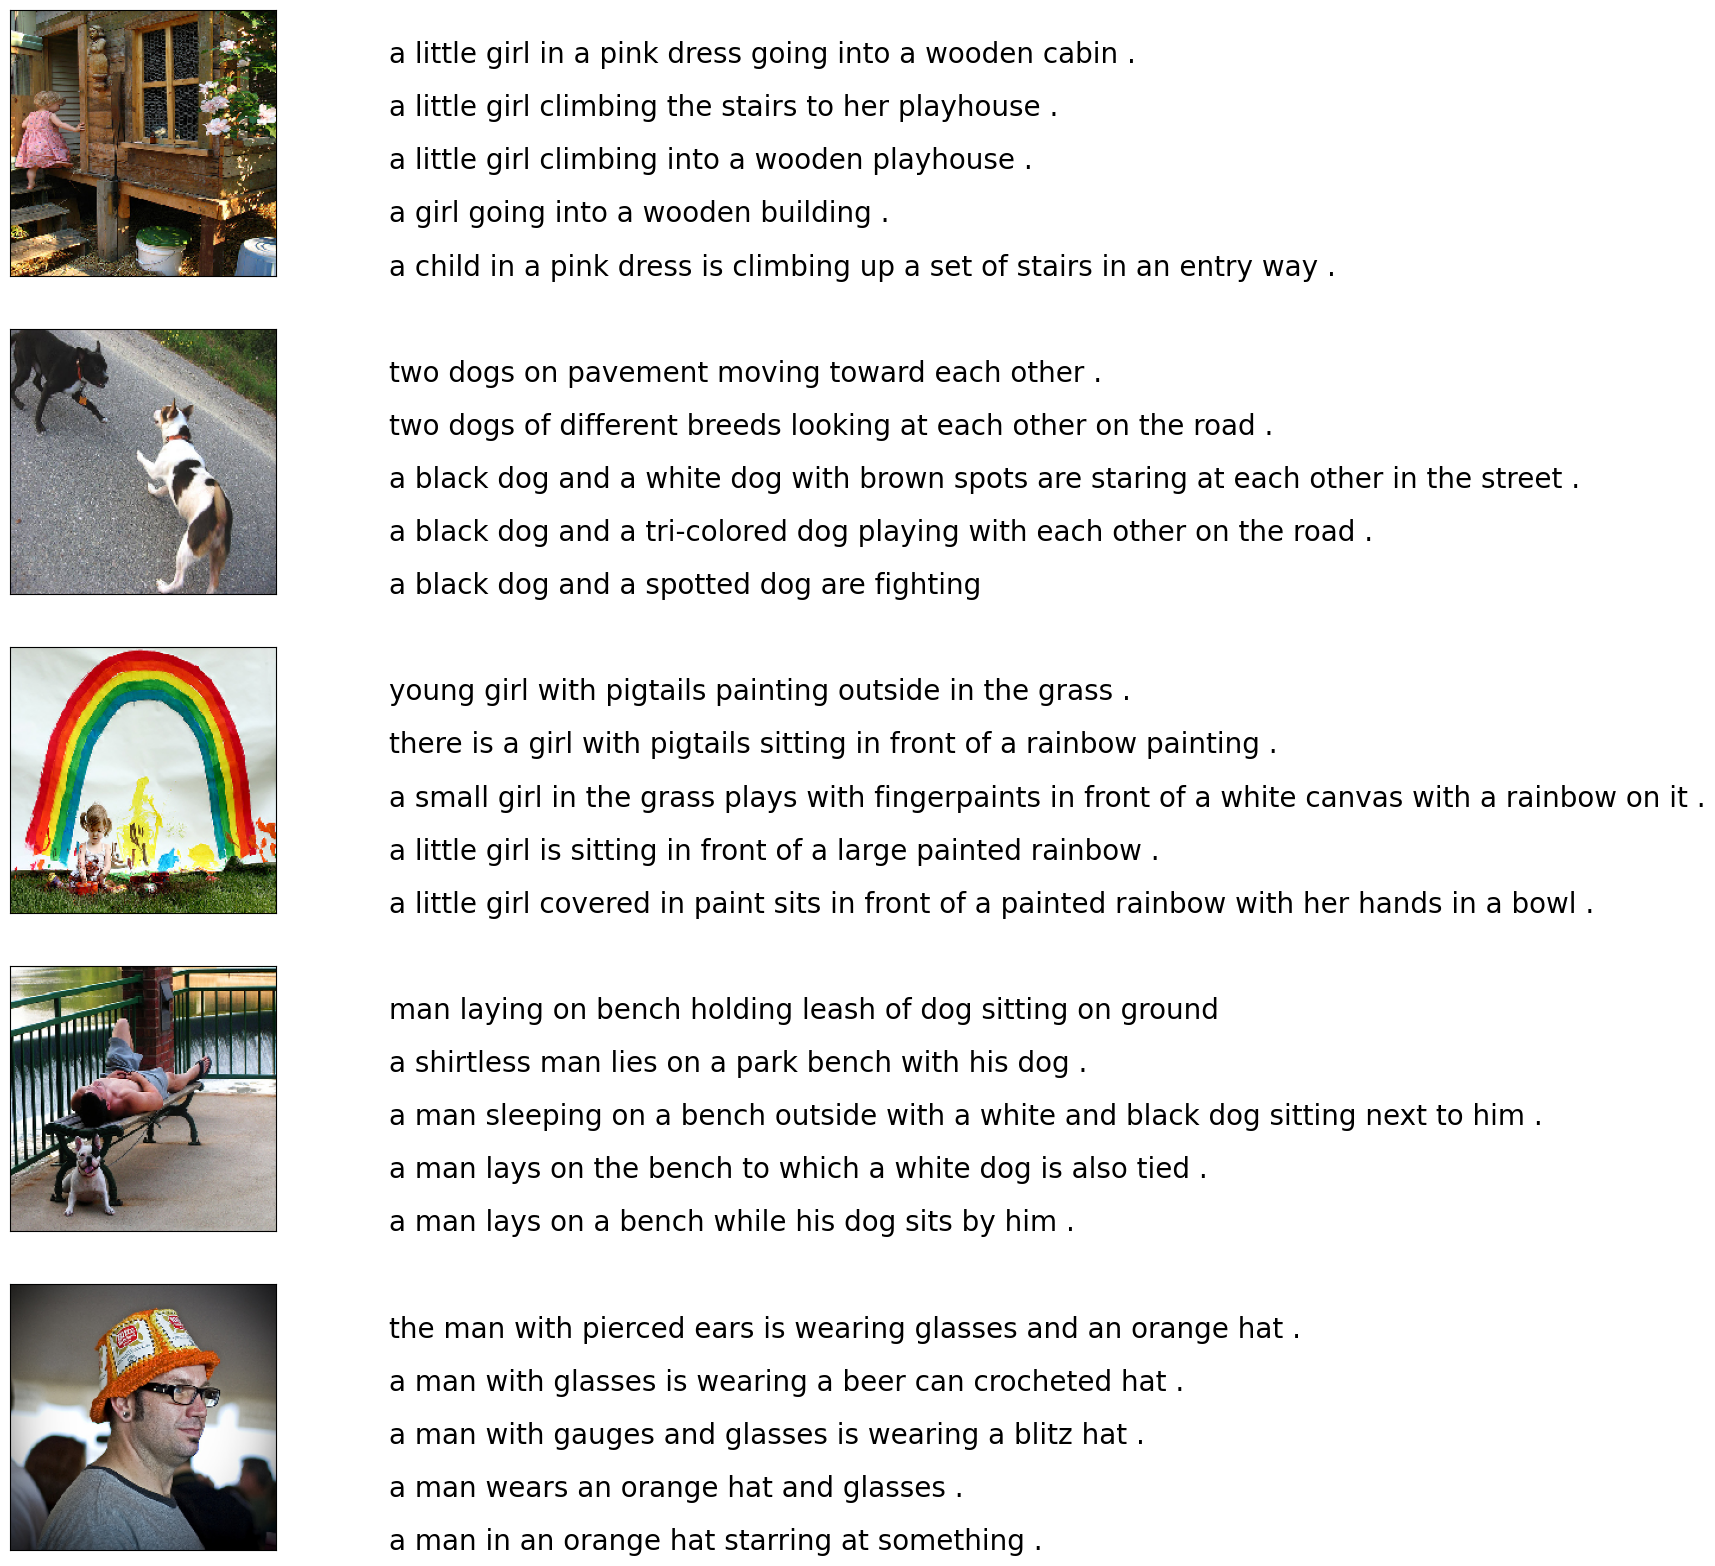

In [10]:

# Constants
npic = 5
npix = 224
target_size = (npix, npix, 3)

# Initialize a plot
count = 1
fig = plt.figure(figsize=(10, 20))

# Loop through a subset of image filenames
for jpgfnm in uni_filenames[:npic]:
    # Construct the full image path
    filename = os.path.join(images_path, jpgfnm)

    # Get captions for the current image
    captions = list(df_txt["caption"].loc[df_txt["filename"] == jpgfnm].values)

    # Load and display the image
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    # Display captions for the image
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, len(captions))
    
    # Add captions as text
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=20)
    
    count += 1

# Show the plot
plt.show()

In [11]:
def to_vocab(desc):
    words = set()
    for key in desc.keys():
        for line in desc[key]:
            words.update(line.split())
    return words
vocab = to_vocab(df_txt)
len(vocab)

17011

In [12]:
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975

In [13]:
import string
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [14]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


# Calculate the total number of iterations
total_iterations = len(df_txt.caption.values)

# Initialize the progress bar
with tqdm(total=total_iterations) as pbar:
    for i, caption in enumerate(df_txt.caption.values):
        newcaption = text_clean(caption)
        df_txt["caption"].iloc[i] = newcaption
        pbar.update(1)
    

100%|██████████| 40460/40460 [00:16<00:00, 2504.77it/s]


In [15]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
#del df_txt

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0  startseq  child in pink dress is climbing up s...  
1   startseq  girl going into wooden building endseq  
2  startseq  little girl climbing into wooden pla...  
3  startseq  little girl climbing the stairs to h...  
4  startseq  little girl in pink dress going into...

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from tqdm import tqdm  # Import tqdm for progress bar

# Populate the 'images' dictionary with image filenames
images = OrderedDict()

# Assuming your images are in the 'images_path' directory
image_files = os.listdir(images_path)

# Create the dictionary with image filenames
for image_file in image_files:
    images[image_file] = os.path.join(images_path, image_file)

npix = 224
target_size = (npix, npix, 3)

# Calculate the total number of iterations
total_iterations = len(images)

# Initialize the progress bar
with tqdm(total=total_iterations) as pbar:
    for i, (name, filename) in enumerate(images.items()):
        # load an image from file
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = model.predict(nimage.reshape((1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
        pbar.update(1)  # Update the progress bar for each iteration


  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 10s 10s/step


  0%|          | 1/8091 [00:09<22:05:51,  9.83s/it]

1/1 [==============================] - 0s 20ms/step


  0%|          | 3/8091 [00:09<5:51:34,  2.61s/it] 

1/1 [==============================] - 0s 34ms/step


  0%|          | 4/8091 [00:10<3:55:41,  1.75s/it]

1/1 [==============================] - 0s 22ms/step


  0%|          | 6/8091 [00:10<2:04:13,  1.08it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 8/8091 [00:10<1:17:08,  1.75it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 10/8091 [00:10<52:25,  2.57it/s] 

1/1 [==============================] - 0s 21ms/step


  0%|          | 12/8091 [00:10<37:39,  3.58it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 14/8091 [00:10<28:33,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 16/8091 [00:11<22:43,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 18/8091 [00:11<18:43,  7.19it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 20/8091 [00:11<16:07,  8.34it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 22/8091 [00:11<14:19,  9.39it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 24/8091 [00:11<13:19, 10.09it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 26/8091 [00:11<12:37, 10.65it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 28/8091 [00:11<11:51, 11.33it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 30/8091 [00:12<11:20, 11.85it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 32/8091 [00:12<11:10, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 34/8091 [00:12<11:08, 12.05it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 36/8091 [00:12<10:53, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 38/8091 [00:12<10:41, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 40/8091 [00:12<10:36, 12.66it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 42/8091 [00:13<10:48, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 44/8091 [00:13<10:38, 12.60it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 46/8091 [00:13<10:41, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 48/8091 [00:13<10:36, 12.64it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 50/8091 [00:13<10:26, 12.84it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 52/8091 [00:13<10:41, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 54/8091 [00:14<10:38, 12.60it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 56/8091 [00:14<10:33, 12.69it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 58/8091 [00:14<10:35, 12.64it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 60/8091 [00:14<10:33, 12.68it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 62/8091 [00:14<10:25, 12.84it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 64/8091 [00:14<10:22, 12.89it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 66/8091 [00:14<10:28, 12.76it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 68/8091 [00:15<10:30, 12.73it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 70/8091 [00:15<10:42, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 72/8091 [00:15<10:32, 12.69it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 74/8091 [00:15<10:32, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 76/8091 [00:15<10:25, 12.82it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 78/8091 [00:15<10:36, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 80/8091 [00:16<10:22, 12.87it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 82/8091 [00:16<10:30, 12.70it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 84/8091 [00:16<10:27, 12.75it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 86/8091 [00:16<10:22, 12.86it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 88/8091 [00:16<10:31, 12.67it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 90/8091 [00:16<10:57, 12.18it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 92/8091 [00:17<12:01, 11.08it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 94/8091 [00:17<12:50, 10.38it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 96/8091 [00:17<13:42,  9.72it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 97/8091 [00:17<14:08,  9.42it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 98/8091 [00:17<14:14,  9.35it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 99/8091 [00:17<14:11,  9.38it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 100/8091 [00:18<14:07,  9.42it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 101/8091 [00:18<14:27,  9.21it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 102/8091 [00:18<14:54,  8.93it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 103/8091 [00:18<15:10,  8.78it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 104/8091 [00:18<14:46,  9.01it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 106/8091 [00:18<13:01, 10.21it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 108/8091 [00:18<12:15, 10.85it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 110/8091 [00:18<11:45, 11.32it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 112/8091 [00:19<11:18, 11.76it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 114/8091 [00:19<11:17, 11.77it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 116/8091 [00:19<11:15, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 118/8091 [00:19<10:56, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 120/8091 [00:19<11:33, 11.50it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 122/8091 [00:19<11:15, 11.81it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 124/8091 [00:20<11:58, 11.09it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 126/8091 [00:20<11:42, 11.34it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 128/8091 [00:20<11:19, 11.72it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 130/8091 [00:20<11:01, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 132/8091 [00:20<10:55, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 134/8091 [00:20<10:42, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 136/8091 [00:21<10:39, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 138/8091 [00:21<10:24, 12.73it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 140/8091 [00:21<10:36, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 142/8091 [00:21<10:40, 12.42it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 144/8091 [00:21<10:27, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 146/8091 [00:21<10:25, 12.70it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 148/8091 [00:22<10:24, 12.72it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 150/8091 [00:22<10:24, 12.72it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 152/8091 [00:22<10:25, 12.69it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 154/8091 [00:22<10:16, 12.86it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 156/8091 [00:22<10:16, 12.87it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 158/8091 [00:22<10:18, 12.83it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 160/8091 [00:23<10:29, 12.60it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 162/8091 [00:23<11:02, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 164/8091 [00:23<10:54, 12.12it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 166/8091 [00:23<10:36, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 168/8091 [00:23<10:46, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 170/8091 [00:23<10:56, 12.06it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 172/8091 [00:24<10:46, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 174/8091 [00:24<10:37, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 176/8091 [00:24<10:46, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 178/8091 [00:24<10:46, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 180/8091 [00:24<10:44, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 182/8091 [00:24<10:43, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 184/8091 [00:24<10:43, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 186/8091 [00:25<10:45, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 188/8091 [00:25<10:32, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 190/8091 [00:25<10:37, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 192/8091 [00:25<10:28, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 194/8091 [00:25<10:24, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 196/8091 [00:25<10:21, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 198/8091 [00:26<10:12, 12.88it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 200/8091 [00:26<10:14, 12.84it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 202/8091 [00:26<10:12, 12.88it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 204/8091 [00:26<10:15, 12.80it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 206/8091 [00:26<10:24, 12.62it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 208/8091 [00:26<10:15, 12.81it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 210/8091 [00:27<10:14, 12.82it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 212/8091 [00:27<10:07, 12.98it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 214/8091 [00:27<10:17, 12.76it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 216/8091 [00:27<10:18, 12.72it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 218/8091 [00:27<10:19, 12.70it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 220/8091 [00:27<10:12, 12.86it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 222/8091 [00:27<10:25, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 224/8091 [00:28<10:24, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 226/8091 [00:28<10:14, 12.79it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 228/8091 [00:28<10:15, 12.78it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 230/8091 [00:28<10:11, 12.86it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 232/8091 [00:28<10:13, 12.82it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 234/8091 [00:28<10:06, 12.96it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 236/8091 [00:29<10:11, 12.84it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 238/8091 [00:29<10:11, 12.83it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 240/8091 [00:29<10:25, 12.55it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 242/8091 [00:29<15:50,  8.26it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 244/8091 [00:29<14:12,  9.20it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 246/8091 [00:30<14:07,  9.26it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 248/8091 [00:30<13:07,  9.96it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 250/8091 [00:30<12:29, 10.46it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 252/8091 [00:30<12:04, 10.83it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 254/8091 [00:30<11:38, 11.22it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 256/8091 [00:31<11:16, 11.58it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 258/8091 [00:31<11:12, 11.65it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 260/8091 [00:31<11:06, 11.75it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 262/8091 [00:31<10:50, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 264/8091 [00:31<10:43, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 266/8091 [00:31<10:41, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 268/8091 [00:31<10:42, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 270/8091 [00:32<10:36, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 272/8091 [00:32<10:21, 12.57it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 274/8091 [00:32<10:17, 12.65it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 276/8091 [00:32<10:20, 12.58it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 278/8091 [00:32<10:14, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 280/8091 [00:32<10:15, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 282/8091 [00:33<10:10, 12.80it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 284/8091 [00:33<10:16, 12.66it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 286/8091 [00:33<10:35, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 288/8091 [00:33<10:29, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 290/8091 [00:33<10:20, 12.57it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 292/8091 [00:33<10:16, 12.66it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 294/8091 [00:34<10:30, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▎         | 296/8091 [00:34<10:27, 12.41it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▎         | 298/8091 [00:34<10:21, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 300/8091 [00:34<10:18, 12.59it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 302/8091 [00:34<10:04, 12.88it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 304/8091 [00:34<10:21, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 306/8091 [00:35<10:24, 12.47it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 308/8091 [00:35<10:20, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 310/8091 [00:35<10:28, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 312/8091 [00:35<10:33, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 314/8091 [00:35<10:23, 12.47it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 316/8091 [00:35<10:33, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 318/8091 [00:35<10:21, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 320/8091 [00:36<10:15, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 322/8091 [00:36<10:31, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 324/8091 [00:36<10:20, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 326/8091 [00:36<10:23, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 328/8091 [00:36<10:25, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 330/8091 [00:36<10:29, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 332/8091 [00:37<10:18, 12.54it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 334/8091 [00:37<10:10, 12.70it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 336/8091 [00:37<10:06, 12.78it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 338/8091 [00:37<10:05, 12.80it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 340/8091 [00:37<10:15, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 342/8091 [00:37<10:14, 12.61it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 344/8091 [00:38<10:04, 12.82it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 346/8091 [00:38<10:09, 12.71it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 348/8091 [00:38<10:24, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 350/8091 [00:38<10:23, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 352/8091 [00:38<10:24, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 354/8091 [00:38<10:10, 12.66it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 356/8091 [00:39<10:20, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 358/8091 [00:39<10:34, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 360/8091 [00:39<10:30, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 362/8091 [00:39<10:20, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 364/8091 [00:39<10:24, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 366/8091 [00:39<10:35, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 368/8091 [00:39<10:30, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 370/8091 [00:40<11:15, 11.43it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 372/8091 [00:40<10:58, 11.72it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 374/8091 [00:40<10:43, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 376/8091 [00:40<10:46, 11.93it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 378/8091 [00:40<10:32, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 380/8091 [00:40<10:19, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 382/8091 [00:41<10:09, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 384/8091 [00:41<10:16, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 386/8091 [00:41<10:16, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 388/8091 [00:41<10:03, 12.76it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 390/8091 [00:41<10:00, 12.83it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 392/8091 [00:41<09:58, 12.85it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 394/8091 [00:42<09:59, 12.83it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 396/8091 [00:42<09:59, 12.83it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 398/8091 [00:42<10:01, 12.78it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 400/8091 [00:42<09:56, 12.89it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 402/8091 [00:42<10:04, 12.72it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 404/8091 [00:42<10:01, 12.78it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 406/8091 [00:43<10:03, 12.72it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 408/8091 [00:43<09:50, 13.02it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 410/8091 [00:43<09:46, 13.11it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 412/8091 [00:43<10:09, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 414/8091 [00:43<10:05, 12.69it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 416/8091 [00:43<09:57, 12.85it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 418/8091 [00:43<09:51, 12.97it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 420/8091 [00:44<10:01, 12.74it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 422/8091 [00:44<10:00, 12.77it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 424/8091 [00:44<10:01, 12.75it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▌         | 426/8091 [00:44<10:03, 12.70it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 428/8091 [00:44<10:00, 12.77it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 430/8091 [00:44<10:10, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 432/8091 [00:45<10:07, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 434/8091 [00:45<10:04, 12.67it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 436/8091 [00:45<10:07, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 438/8091 [00:45<10:12, 12.49it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 440/8091 [00:45<10:13, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 442/8091 [00:45<10:08, 12.57it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 444/8091 [00:46<10:06, 12.62it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 446/8091 [00:46<10:04, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 448/8091 [00:46<10:12, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 450/8091 [00:46<10:09, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 452/8091 [00:46<10:05, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 454/8091 [00:46<10:02, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 456/8091 [00:46<10:09, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 458/8091 [00:47<10:10, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 460/8091 [00:47<10:09, 12.52it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 462/8091 [00:47<10:03, 12.63it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 464/8091 [00:47<09:59, 12.73it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 466/8091 [00:47<10:04, 12.61it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 468/8091 [00:47<10:05, 12.58it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 470/8091 [00:48<09:59, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 472/8091 [00:48<09:47, 12.97it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 474/8091 [00:48<10:08, 12.52it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▌         | 476/8091 [00:48<11:21, 11.17it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 478/8091 [00:48<12:16, 10.33it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 480/8091 [00:49<12:52,  9.85it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 482/8091 [00:49<13:02,  9.72it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 483/8091 [00:49<13:21,  9.50it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 484/8091 [00:49<13:31,  9.37it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 485/8091 [00:49<13:30,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 486/8091 [00:49<13:40,  9.27it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 487/8091 [00:49<13:47,  9.19it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 488/8091 [00:49<13:48,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 489/8091 [00:50<14:47,  8.57it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 490/8091 [00:50<14:49,  8.54it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 492/8091 [00:50<12:59,  9.75it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 494/8091 [00:50<11:54, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 496/8091 [00:50<11:17, 11.20it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 498/8091 [00:50<10:50, 11.67it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 500/8091 [00:51<10:36, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 502/8091 [00:51<10:25, 12.12it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 504/8091 [00:51<10:20, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 506/8091 [00:51<10:20, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 508/8091 [00:51<10:14, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 510/8091 [00:51<10:13, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 512/8091 [00:51<10:17, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 514/8091 [00:52<10:12, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 516/8091 [00:52<10:04, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 518/8091 [00:52<09:57, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 520/8091 [00:52<10:02, 12.56it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 522/8091 [00:52<09:54, 12.74it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 524/8091 [00:52<09:50, 12.82it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 526/8091 [00:53<09:47, 12.88it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 528/8091 [00:53<10:03, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 530/8091 [00:53<09:58, 12.63it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 532/8091 [00:53<10:04, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 534/8091 [00:53<10:05, 12.47it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 536/8091 [00:53<10:13, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 538/8091 [00:54<10:19, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 540/8091 [00:54<10:06, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 542/8091 [00:54<10:11, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 544/8091 [00:54<10:09, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 546/8091 [00:54<10:24, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 548/8091 [00:54<10:13, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 550/8091 [00:55<10:02, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 552/8091 [00:55<09:58, 12.61it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 554/8091 [00:55<10:08, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 556/8091 [00:55<10:27, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 558/8091 [00:55<10:16, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 560/8091 [00:55<10:05, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 562/8091 [00:55<09:53, 12.68it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 564/8091 [00:56<09:51, 12.74it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 566/8091 [00:56<10:04, 12.45it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 568/8091 [00:56<10:02, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 570/8091 [00:56<09:58, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 572/8091 [00:56<09:57, 12.58it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 574/8091 [00:56<10:06, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 576/8091 [00:57<10:03, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 578/8091 [00:57<10:06, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 580/8091 [00:57<10:07, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 582/8091 [00:57<10:17, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 584/8091 [00:57<10:04, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 586/8091 [00:57<09:55, 12.60it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 588/8091 [00:58<09:58, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 590/8091 [00:58<09:48, 12.74it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 592/8091 [00:58<09:50, 12.69it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 594/8091 [00:58<09:51, 12.68it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 596/8091 [00:58<09:53, 12.63it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 598/8091 [00:58<09:48, 12.74it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 600/8091 [00:59<09:54, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 602/8091 [00:59<09:46, 12.77it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 604/8091 [00:59<09:36, 12.98it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 606/8091 [00:59<09:41, 12.88it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 608/8091 [00:59<09:53, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 610/8091 [00:59<09:56, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 612/8091 [00:59<10:01, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 614/8091 [01:00<10:56, 11.39it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 616/8091 [01:00<10:30, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 618/8091 [01:00<10:18, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 620/8091 [01:00<10:01, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 622/8091 [01:00<10:04, 12.36it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 624/8091 [01:00<10:03, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 626/8091 [01:01<10:07, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 628/8091 [01:01<10:18, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 630/8091 [01:01<10:15, 12.13it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 632/8091 [01:01<10:07, 12.28it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 634/8091 [01:01<09:59, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 636/8091 [01:01<10:03, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 638/8091 [01:02<10:06, 12.30it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 640/8091 [01:02<10:04, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 642/8091 [01:02<09:53, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 644/8091 [01:02<09:45, 12.71it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 646/8091 [01:02<09:51, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 648/8091 [01:02<09:48, 12.64it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 650/8091 [01:03<09:45, 12.72it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 652/8091 [01:03<09:42, 12.78it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 654/8091 [01:03<09:55, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 656/8091 [01:03<10:04, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 658/8091 [01:03<09:57, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 660/8091 [01:03<09:57, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 662/8091 [01:04<09:57, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 664/8091 [01:04<10:06, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 666/8091 [01:04<10:07, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 668/8091 [01:04<10:01, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 670/8091 [01:04<09:49, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 672/8091 [01:04<10:01, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 674/8091 [01:05<10:08, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 676/8091 [01:05<09:59, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 678/8091 [01:05<09:48, 12.60it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 680/8091 [01:05<09:52, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 682/8091 [01:05<09:59, 12.36it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 684/8091 [01:05<09:50, 12.55it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 686/8091 [01:05<09:58, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 688/8091 [01:06<09:55, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 690/8091 [01:06<09:59, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 692/8091 [01:06<09:56, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 694/8091 [01:06<10:01, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▊         | 696/8091 [01:06<09:58, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 698/8091 [01:06<10:03, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 700/8091 [01:07<10:06, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 702/8091 [01:07<10:05, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 704/8091 [01:07<09:55, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 706/8091 [01:07<09:52, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 708/8091 [01:07<09:59, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 710/8091 [01:07<09:58, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 712/8091 [01:08<09:49, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 714/8091 [01:08<09:44, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 716/8091 [01:08<09:37, 12.76it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 718/8091 [01:08<09:50, 12.48it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 720/8091 [01:08<09:53, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 722/8091 [01:08<09:57, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 724/8091 [01:09<09:52, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 726/8091 [01:09<10:00, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 728/8091 [01:09<10:02, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 730/8091 [01:09<09:52, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 732/8091 [01:09<09:57, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 734/8091 [01:09<10:11, 12.04it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 736/8091 [01:10<10:28, 11.71it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 738/8091 [01:10<10:46, 11.38it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 740/8091 [01:10<10:33, 11.60it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 742/8091 [01:10<10:16, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 744/8091 [01:10<10:05, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 746/8091 [01:10<09:57, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 748/8091 [01:11<09:45, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 750/8091 [01:11<09:45, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 752/8091 [01:11<09:45, 12.53it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 754/8091 [01:11<10:04, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 756/8091 [01:11<10:01, 12.20it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 758/8091 [01:11<09:45, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 760/8091 [01:11<09:41, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 762/8091 [01:12<09:46, 12.50it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 764/8091 [01:12<09:45, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 766/8091 [01:12<09:36, 12.72it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 768/8091 [01:12<09:35, 12.73it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 770/8091 [01:12<09:36, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 772/8091 [01:12<09:47, 12.45it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 774/8091 [01:13<09:37, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 776/8091 [01:13<09:32, 12.78it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 778/8091 [01:13<09:31, 12.79it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 780/8091 [01:13<09:41, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 782/8091 [01:13<09:43, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 784/8091 [01:13<09:40, 12.60it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 786/8091 [01:14<09:45, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 788/8091 [01:14<09:38, 12.62it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 790/8091 [01:14<09:40, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 792/8091 [01:14<09:39, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 794/8091 [01:14<09:51, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 796/8091 [01:14<09:47, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 798/8091 [01:15<09:52, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 800/8091 [01:15<09:48, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 802/8091 [01:15<09:42, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 804/8091 [01:15<09:39, 12.57it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 806/8091 [01:15<09:49, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 808/8091 [01:15<09:51, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 810/8091 [01:15<09:43, 12.48it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 812/8091 [01:16<09:41, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 814/8091 [01:16<09:47, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 816/8091 [01:16<09:53, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 818/8091 [01:16<09:48, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 820/8091 [01:16<09:48, 12.36it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 822/8091 [01:16<09:51, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 824/8091 [01:17<09:44, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 826/8091 [01:17<09:54, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 828/8091 [01:17<10:03, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 830/8091 [01:17<09:50, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 832/8091 [01:17<09:41, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 834/8091 [01:17<09:54, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 836/8091 [01:18<09:58, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 838/8091 [01:18<09:52, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 840/8091 [01:18<09:52, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 842/8091 [01:18<09:52, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 844/8091 [01:18<10:03, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 846/8091 [01:18<10:00, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 848/8091 [01:19<10:02, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 850/8091 [01:19<10:14, 11.77it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 852/8091 [01:19<10:12, 11.82it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 854/8091 [01:19<10:06, 11.93it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 856/8091 [01:19<10:14, 11.78it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 858/8091 [01:19<10:03, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 860/8091 [01:20<10:40, 11.29it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 862/8091 [01:20<11:34, 10.41it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 864/8091 [01:20<12:21,  9.75it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 865/8091 [01:20<12:25,  9.69it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 866/8091 [01:20<12:33,  9.59it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 867/8091 [01:20<12:37,  9.54it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 868/8091 [01:21<12:45,  9.44it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 869/8091 [01:21<12:37,  9.54it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 870/8091 [01:21<13:03,  9.22it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 871/8091 [01:21<13:12,  9.11it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 872/8091 [01:21<13:03,  9.21it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 873/8091 [01:21<13:06,  9.17it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 874/8091 [01:21<13:32,  8.88it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 875/8091 [01:21<13:32,  8.88it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 877/8091 [01:21<11:55, 10.08it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 879/8091 [01:22<11:09, 10.77it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 881/8091 [01:22<10:42, 11.23it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 883/8091 [01:22<10:17, 11.67it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 885/8091 [01:22<10:09, 11.82it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 887/8091 [01:22<09:56, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 889/8091 [01:22<10:02, 11.96it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 891/8091 [01:23<09:49, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 893/8091 [01:23<09:43, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 895/8091 [01:23<09:46, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 897/8091 [01:23<09:47, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 899/8091 [01:23<09:50, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 901/8091 [01:23<09:46, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 903/8091 [01:24<09:47, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 905/8091 [01:24<09:46, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 907/8091 [01:24<09:54, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 909/8091 [01:24<09:49, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 911/8091 [01:24<09:46, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 913/8091 [01:24<09:37, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 915/8091 [01:25<09:43, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 917/8091 [01:25<09:39, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 919/8091 [01:25<09:45, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 921/8091 [01:25<09:49, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 923/8091 [01:25<09:56, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 925/8091 [01:25<10:09, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 927/8091 [01:26<10:04, 11.85it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 929/8091 [01:26<09:55, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 931/8091 [01:26<09:45, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 933/8091 [01:26<09:45, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 935/8091 [01:26<09:47, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 937/8091 [01:26<09:41, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 939/8091 [01:27<09:34, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 941/8091 [01:27<09:32, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 943/8091 [01:27<09:44, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 945/8091 [01:27<09:48, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 947/8091 [01:27<09:45, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 949/8091 [01:27<09:38, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 951/8091 [01:28<09:51, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 953/8091 [01:28<09:48, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 955/8091 [01:28<09:45, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 957/8091 [01:28<09:33, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 959/8091 [01:28<09:32, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 961/8091 [01:28<09:38, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 963/8091 [01:28<09:31, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 965/8091 [01:29<09:23, 12.66it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 967/8091 [01:29<09:20, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 969/8091 [01:29<09:28, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 971/8091 [01:29<09:23, 12.64it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 973/8091 [01:29<09:33, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 975/8091 [01:29<09:23, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 977/8091 [01:30<10:10, 11.64it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 979/8091 [01:30<10:05, 11.74it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 981/8091 [01:30<09:59, 11.86it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 983/8091 [01:30<09:54, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 985/8091 [01:30<09:43, 12.17it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 987/8091 [01:30<09:51, 12.01it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 989/8091 [01:31<09:43, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 991/8091 [01:31<09:37, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 993/8091 [01:31<09:39, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 995/8091 [01:31<09:43, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 997/8091 [01:31<09:44, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 999/8091 [01:31<09:38, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1001/8091 [01:32<09:31, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1003/8091 [01:32<09:29, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 1005/8091 [01:32<09:37, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1007/8091 [01:32<09:33, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1009/8091 [01:32<09:21, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 1011/8091 [01:32<09:26, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1013/8091 [01:33<09:33, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1015/8091 [01:33<09:39, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1017/8091 [01:33<09:33, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1019/8091 [01:33<09:35, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1021/8091 [01:33<09:36, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1023/8091 [01:33<09:44, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1025/8091 [01:34<09:34, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1027/8091 [01:34<09:29, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1029/8091 [01:34<09:27, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1031/8091 [01:34<09:32, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1033/8091 [01:34<09:33, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1035/8091 [01:34<09:24, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1037/8091 [01:35<09:20, 12.58it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1039/8091 [01:35<09:23, 12.52it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1041/8091 [01:35<09:29, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1043/8091 [01:35<09:32, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1045/8091 [01:35<09:29, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1047/8091 [01:35<09:27, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1049/8091 [01:35<09:15, 12.67it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1051/8091 [01:36<09:15, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1053/8091 [01:36<09:10, 12.77it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1055/8091 [01:36<09:16, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1057/8091 [01:36<09:10, 12.77it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1059/8091 [01:36<09:30, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 1061/8091 [01:36<09:36, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1063/8091 [01:37<09:28, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1065/8091 [01:37<09:27, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1067/8091 [01:37<09:19, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1069/8091 [01:37<09:23, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1071/8091 [01:37<09:26, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1073/8091 [01:37<09:20, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1075/8091 [01:38<09:16, 12.61it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1077/8091 [01:38<09:25, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1079/8091 [01:38<09:30, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1081/8091 [01:38<09:33, 12.23it/s]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 1083/8091 [01:38<09:34, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 1085/8091 [01:38<09:37, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 1087/8091 [01:39<09:41, 12.04it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 1089/8091 [01:39<09:34, 12.19it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1091/8091 [01:39<09:35, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 1093/8091 [01:39<09:37, 12.12it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 1095/8091 [01:39<09:40, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 1097/8091 [01:39<09:47, 11.90it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▎        | 1099/8091 [01:40<10:16, 11.35it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 1101/8091 [01:40<10:01, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 1103/8091 [01:40<09:45, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 1105/8091 [01:40<09:40, 12.04it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 1107/8091 [01:40<09:35, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▎        | 1109/8091 [01:40<09:27, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 1111/8091 [01:41<09:12, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1113/8091 [01:41<09:17, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1115/8091 [01:41<09:10, 12.68it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1117/8091 [01:41<09:08, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1119/8091 [01:41<09:10, 12.66it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1121/8091 [01:41<09:04, 12.80it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1123/8091 [01:41<09:18, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1125/8091 [01:42<09:22, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1127/8091 [01:42<09:09, 12.68it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1129/8091 [01:42<09:44, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1131/8091 [01:42<09:48, 11.83it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1133/8091 [01:42<09:38, 12.02it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1135/8091 [01:42<09:31, 12.16it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1137/8091 [01:43<09:22, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1139/8091 [01:43<09:20, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1141/8091 [01:43<09:36, 12.06it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1143/8091 [01:43<09:31, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1145/8091 [01:43<09:31, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1147/8091 [01:43<09:20, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1149/8091 [01:44<09:27, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 1151/8091 [01:44<09:22, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1153/8091 [01:44<09:25, 12.28it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 1155/8091 [01:44<09:13, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1157/8091 [01:44<09:18, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1159/8091 [01:44<09:22, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1161/8091 [01:45<09:13, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1163/8091 [01:45<09:21, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1165/8091 [01:45<09:27, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1167/8091 [01:45<09:22, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 1169/8091 [01:45<09:12, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 1171/8091 [01:45<09:23, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 1173/8091 [01:46<09:13, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1175/8091 [01:46<09:04, 12.70it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1177/8091 [01:46<09:10, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1179/8091 [01:46<09:11, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1181/8091 [01:46<09:05, 12.68it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1183/8091 [01:46<09:11, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1185/8091 [01:46<09:13, 12.48it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1187/8091 [01:47<09:08, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1189/8091 [01:47<09:08, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1191/8091 [01:47<09:11, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1193/8091 [01:47<09:06, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1195/8091 [01:47<09:22, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1197/8091 [01:47<09:22, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1199/8091 [01:48<09:17, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1201/8091 [01:48<09:16, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1203/8091 [01:48<09:14, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1205/8091 [01:48<09:11, 12.48it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1207/8091 [01:48<09:13, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1209/8091 [01:48<09:13, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 1211/8091 [01:49<09:09, 12.52it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1213/8091 [01:49<09:16, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1215/8091 [01:49<09:21, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1217/8091 [01:49<09:16, 12.34it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1219/8091 [01:49<09:31, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1221/8091 [01:49<09:33, 11.98it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1223/8091 [01:50<10:06, 11.33it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1225/8091 [01:50<09:47, 11.68it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1227/8091 [01:50<09:33, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1229/8091 [01:50<09:25, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 1231/8091 [01:50<09:55, 11.52it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1233/8091 [01:50<10:00, 11.42it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1235/8091 [01:51<09:46, 11.69it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1237/8091 [01:51<09:40, 11.81it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1239/8091 [01:51<09:28, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1241/8091 [01:51<09:21, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1243/8091 [01:51<09:25, 12.12it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 1245/8091 [01:52<10:20, 11.03it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1247/8091 [01:52<11:09, 10.22it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1249/8091 [01:52<11:55,  9.56it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1250/8091 [01:52<11:58,  9.52it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1251/8091 [01:52<12:05,  9.43it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1252/8091 [01:52<12:17,  9.27it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1253/8091 [01:52<12:18,  9.26it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1254/8091 [01:53<12:18,  9.25it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1255/8091 [01:53<12:25,  9.17it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1256/8091 [01:53<13:10,  8.64it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1257/8091 [01:53<13:17,  8.57it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1259/8091 [01:53<11:38,  9.78it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1261/8091 [01:53<10:34, 10.76it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1263/8091 [01:53<10:09, 11.20it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1265/8091 [01:54<10:11, 11.17it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1267/8091 [01:54<09:59, 11.37it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1269/8091 [01:54<09:49, 11.58it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1271/8091 [01:54<09:42, 11.70it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1273/8091 [01:54<09:25, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1275/8091 [01:54<10:01, 11.34it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1277/8091 [01:55<09:48, 11.57it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1279/8091 [01:55<09:38, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1281/8091 [01:55<09:28, 11.97it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1283/8091 [01:55<09:24, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1285/8091 [01:55<09:28, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1287/8091 [01:55<09:14, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1289/8091 [01:56<09:11, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1291/8091 [01:56<09:05, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1293/8091 [01:56<09:12, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1295/8091 [01:56<09:17, 12.18it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1297/8091 [01:56<09:08, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1299/8091 [01:56<08:59, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 1301/8091 [01:57<09:02, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1303/8091 [01:57<09:02, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1305/8091 [01:57<09:03, 12.50it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1307/8091 [01:57<09:40, 11.68it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1309/8091 [01:57<09:25, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1311/8091 [01:57<09:18, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1313/8091 [01:58<09:10, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1315/8091 [01:58<09:03, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1317/8091 [01:58<09:03, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1319/8091 [01:58<09:08, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1321/8091 [01:58<09:08, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1323/8091 [01:58<09:08, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1325/8091 [01:58<09:13, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1327/8091 [01:59<09:05, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 1329/8091 [01:59<09:19, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1331/8091 [01:59<09:11, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 1333/8091 [01:59<09:04, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1335/8091 [01:59<09:12, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1337/8091 [01:59<08:58, 12.54it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1339/8091 [02:00<09:50, 11.43it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1341/8091 [02:00<09:28, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1343/8091 [02:00<09:19, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1345/8091 [02:00<09:10, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1347/8091 [02:00<09:13, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1349/8091 [02:00<09:06, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1351/8091 [02:01<09:02, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1353/8091 [02:01<08:58, 12.50it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1355/8091 [02:01<08:57, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1357/8091 [02:01<09:04, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1359/8091 [02:01<09:02, 12.42it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1361/8091 [02:01<09:03, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1363/8091 [02:02<09:01, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1365/8091 [02:02<09:04, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1367/8091 [02:02<08:59, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1369/8091 [02:02<09:00, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1371/8091 [02:02<08:53, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1373/8091 [02:02<08:46, 12.76it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1375/8091 [02:03<08:53, 12.59it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1377/8091 [02:03<08:55, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1379/8091 [02:03<08:46, 12.75it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1381/8091 [02:03<08:54, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1383/8091 [02:03<09:10, 12.19it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 1385/8091 [02:03<09:05, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1387/8091 [02:03<09:10, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1389/8091 [02:04<09:06, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1391/8091 [02:04<08:58, 12.44it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1393/8091 [02:04<09:08, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1395/8091 [02:04<09:05, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1397/8091 [02:04<09:03, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1399/8091 [02:04<09:09, 12.18it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 1401/8091 [02:05<09:12, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1403/8091 [02:05<09:07, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1405/8091 [02:05<09:10, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1407/8091 [02:05<09:08, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1409/8091 [02:05<09:04, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1411/8091 [02:05<09:07, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1413/8091 [02:06<09:02, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1415/8091 [02:06<08:57, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1417/8091 [02:06<08:57, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1419/8091 [02:06<08:59, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1421/8091 [02:06<08:52, 12.53it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1423/8091 [02:06<08:58, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1425/8091 [02:07<08:55, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1427/8091 [02:07<08:55, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1429/8091 [02:07<09:04, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1431/8091 [02:07<08:58, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1433/8091 [02:07<08:53, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1435/8091 [02:07<08:54, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1437/8091 [02:08<09:00, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1439/8091 [02:08<08:58, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1441/8091 [02:08<09:00, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1443/8091 [02:08<08:55, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1445/8091 [02:08<08:57, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1447/8091 [02:08<09:12, 12.03it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1449/8091 [02:09<09:02, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1451/8091 [02:09<08:53, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1453/8091 [02:09<08:48, 12.56it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1455/8091 [02:09<08:57, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1457/8091 [02:09<08:49, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1459/8091 [02:09<08:54, 12.41it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1461/8091 [02:10<09:06, 12.13it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1463/8091 [02:10<09:50, 11.23it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1465/8091 [02:10<09:40, 11.42it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1467/8091 [02:10<09:30, 11.62it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1469/8091 [02:10<09:24, 11.73it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1471/8091 [02:10<09:09, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1473/8091 [02:11<09:15, 11.91it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1475/8091 [02:11<16:08,  6.83it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1477/8091 [02:11<14:08,  7.79it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1479/8091 [02:11<12:45,  8.64it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1481/8091 [02:12<11:44,  9.38it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1483/8091 [02:12<11:13,  9.81it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1485/8091 [02:12<10:47, 10.20it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1487/8091 [02:12<10:49, 10.17it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1489/8091 [02:12<10:25, 10.56it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1491/8091 [02:13<10:19, 10.66it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1493/8091 [02:13<10:02, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1495/8091 [02:13<09:50, 11.17it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1497/8091 [02:13<09:55, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1499/8091 [02:13<10:05, 10.88it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1501/8091 [02:13<10:09, 10.80it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1503/8091 [02:14<09:56, 11.04it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1505/8091 [02:14<09:56, 11.03it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▊        | 1507/8091 [02:14<09:52, 11.12it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1509/8091 [02:14<09:56, 11.04it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1511/8091 [02:14<09:48, 11.17it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1513/8091 [02:15<09:42, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1515/8091 [02:15<09:34, 11.44it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1517/8091 [02:15<09:36, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1519/8091 [02:15<09:56, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1521/8091 [02:15<09:52, 11.10it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1523/8091 [02:15<09:46, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1525/8091 [02:16<09:40, 11.31it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1527/8091 [02:16<09:46, 11.19it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1529/8091 [02:16<09:58, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1531/8091 [02:16<09:45, 11.20it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1533/8091 [02:16<09:40, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1535/8091 [02:16<09:37, 11.35it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1537/8091 [02:17<09:48, 11.14it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1539/8091 [02:17<09:41, 11.27it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1541/8091 [02:17<09:37, 11.33it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1543/8091 [02:17<09:30, 11.47it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1545/8091 [02:17<09:33, 11.42it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1547/8091 [02:18<09:32, 11.43it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1549/8091 [02:18<09:30, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1551/8091 [02:18<09:24, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1553/8091 [02:18<09:29, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1555/8091 [02:18<09:30, 11.45it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1557/8091 [02:18<09:30, 11.46it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1559/8091 [02:19<09:27, 11.51it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1561/8091 [02:19<09:20, 11.65it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1563/8091 [02:19<09:25, 11.55it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1565/8091 [02:19<09:22, 11.61it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 1567/8091 [02:19<09:52, 11.01it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1569/8091 [02:19<09:38, 11.26it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 1571/8091 [02:20<10:19, 10.53it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1573/8091 [02:20<10:14, 10.61it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1575/8091 [02:20<09:49, 11.05it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1577/8091 [02:20<09:32, 11.37it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1579/8091 [02:20<09:45, 11.12it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 1581/8091 [02:21<09:36, 11.30it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1583/8091 [02:21<09:20, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1585/8091 [02:21<09:05, 11.93it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1587/8091 [02:21<09:04, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1589/8091 [02:21<09:02, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1591/8091 [02:21<09:12, 11.76it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1593/8091 [02:22<09:01, 12.01it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1595/8091 [02:22<08:47, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1597/8091 [02:22<08:47, 12.31it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1599/8091 [02:22<08:56, 12.10it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1601/8091 [02:22<08:47, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1603/8091 [02:22<08:50, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1605/8091 [02:23<08:48, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1607/8091 [02:23<08:42, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1609/8091 [02:23<09:00, 11.99it/s]

1/1 [==============================] - 0s 45ms/step


 20%|█▉        | 1611/8091 [02:23<09:48, 11.01it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1613/8091 [02:23<10:33, 10.23it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1615/8091 [02:24<11:14,  9.59it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 1616/8091 [02:24<11:17,  9.56it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1617/8091 [02:24<11:36,  9.29it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1618/8091 [02:24<11:38,  9.27it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1619/8091 [02:24<11:39,  9.26it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1620/8091 [02:24<11:35,  9.31it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 1621/8091 [02:24<11:37,  9.28it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1622/8091 [02:24<11:36,  9.29it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 1623/8091 [02:24<11:41,  9.21it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1625/8091 [02:25<10:42, 10.07it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1627/8091 [02:25<10:08, 10.63it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1629/8091 [02:25<09:41, 11.10it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1631/8091 [02:25<09:23, 11.47it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1633/8091 [02:25<09:17, 11.58it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1635/8091 [02:25<09:12, 11.69it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1637/8091 [02:26<09:13, 11.66it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1639/8091 [02:26<08:56, 12.03it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1641/8091 [02:26<08:47, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1643/8091 [02:26<08:39, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1645/8091 [02:26<08:37, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1647/8091 [02:26<08:37, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1649/8091 [02:27<08:39, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1651/8091 [02:27<08:34, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1653/8091 [02:27<08:37, 12.45it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1655/8091 [02:27<08:40, 12.36it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1657/8091 [02:27<08:59, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1659/8091 [02:27<09:21, 11.46it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1661/8091 [02:28<09:16, 11.55it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1663/8091 [02:28<09:09, 11.70it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1665/8091 [02:28<09:02, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1667/8091 [02:28<08:49, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1669/8091 [02:28<08:42, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1671/8091 [02:28<08:46, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1673/8091 [02:29<08:51, 12.06it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1675/8091 [02:29<08:38, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1677/8091 [02:29<09:05, 11.75it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1679/8091 [02:29<08:56, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1681/8091 [02:29<09:05, 11.74it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1683/8091 [02:29<09:00, 11.84it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1685/8091 [02:30<09:24, 11.34it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1687/8091 [02:30<09:11, 11.61it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1689/8091 [02:30<09:03, 11.78it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1691/8091 [02:30<08:53, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1693/8091 [02:30<08:45, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1695/8091 [02:30<08:36, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1697/8091 [02:31<08:31, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1699/8091 [02:31<08:40, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1701/8091 [02:31<08:36, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1703/8091 [02:31<08:37, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1705/8091 [02:31<08:40, 12.26it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1707/8091 [02:31<08:38, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1709/8091 [02:32<08:44, 12.16it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1711/8091 [02:32<08:43, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 1713/8091 [02:32<08:53, 11.96it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1715/8091 [02:32<08:45, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1717/8091 [02:32<08:44, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1719/8091 [02:32<08:41, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1721/8091 [02:33<08:33, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1723/8091 [02:33<08:31, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1725/8091 [02:33<08:35, 12.34it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1727/8091 [02:33<08:36, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1729/8091 [02:33<08:38, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1731/8091 [02:33<08:26, 12.56it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1733/8091 [02:33<08:25, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1735/8091 [02:34<08:29, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1737/8091 [02:34<08:30, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1739/8091 [02:34<08:25, 12.57it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1741/8091 [02:34<08:23, 12.61it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1743/8091 [02:34<08:28, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1745/8091 [02:34<08:21, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1747/8091 [02:35<08:28, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1749/8091 [02:35<08:35, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1751/8091 [02:35<08:34, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1753/8091 [02:35<08:36, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1755/8091 [02:35<08:30, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1757/8091 [02:35<08:32, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1759/8091 [02:36<08:38, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1761/8091 [02:36<08:40, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1763/8091 [02:36<08:46, 12.01it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1765/8091 [02:36<08:47, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1767/8091 [02:36<08:43, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1769/8091 [02:36<08:40, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1771/8091 [02:37<08:43, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1773/8091 [02:37<08:39, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1775/8091 [02:37<08:37, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1777/8091 [02:37<08:34, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1779/8091 [02:37<08:35, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1781/8091 [02:37<08:28, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1783/8091 [02:38<08:33, 12.28it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1785/8091 [02:38<08:23, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1787/8091 [02:38<08:15, 12.73it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1789/8091 [02:38<08:29, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1791/8091 [02:38<08:29, 12.37it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1793/8091 [02:38<08:33, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1795/8091 [02:39<08:28, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1797/8091 [02:39<08:32, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1799/8091 [02:39<08:31, 12.31it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1801/8091 [02:39<08:28, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1803/8091 [02:39<08:21, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1805/8091 [02:39<08:20, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1807/8091 [02:39<08:20, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1809/8091 [02:40<08:58, 11.66it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1811/8091 [02:40<08:45, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1813/8091 [02:40<08:36, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1815/8091 [02:40<08:34, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1817/8091 [02:40<08:27, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1819/8091 [02:40<08:20, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1821/8091 [02:41<08:19, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1823/8091 [02:41<08:15, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1825/8091 [02:41<08:25, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1827/8091 [02:41<08:24, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1829/8091 [02:41<08:24, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1831/8091 [02:41<08:12, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1833/8091 [02:42<08:22, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1835/8091 [02:42<08:22, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1837/8091 [02:42<08:17, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1839/8091 [02:42<08:17, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1841/8091 [02:42<08:11, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1843/8091 [02:42<08:41, 11.97it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1845/8091 [02:43<08:58, 11.61it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1847/8091 [02:43<08:41, 11.96it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1849/8091 [02:43<08:33, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1851/8091 [02:43<08:31, 12.21it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1853/8091 [02:43<08:29, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1855/8091 [02:43<08:29, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1857/8091 [02:44<08:19, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1859/8091 [02:44<08:20, 12.44it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1861/8091 [02:44<08:30, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1863/8091 [02:44<08:32, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1865/8091 [02:44<08:23, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1867/8091 [02:44<08:23, 12.36it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1869/8091 [02:45<08:24, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1871/8091 [02:45<08:18, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1873/8091 [02:45<08:15, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1875/8091 [02:45<08:22, 12.36it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1877/8091 [02:45<08:14, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 1879/8091 [02:45<08:15, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1881/8091 [02:45<08:14, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1883/8091 [02:46<08:12, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1885/8091 [02:46<08:07, 12.72it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1887/8091 [02:46<08:19, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1889/8091 [02:46<08:14, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1891/8091 [02:46<08:13, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1893/8091 [02:46<08:12, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1895/8091 [02:47<08:26, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1897/8091 [02:47<08:22, 12.32it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1899/8091 [02:47<08:23, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1901/8091 [02:47<08:15, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1903/8091 [02:47<08:06, 12.72it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1905/8091 [02:47<08:11, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1907/8091 [02:48<08:11, 12.59it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1909/8091 [02:48<08:11, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1911/8091 [02:48<08:11, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1913/8091 [02:48<08:11, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1915/8091 [02:48<08:12, 12.55it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 1917/8091 [02:48<08:14, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▎       | 1919/8091 [02:48<08:04, 12.75it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 1921/8091 [02:49<08:06, 12.69it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1923/8091 [02:49<08:18, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1925/8091 [02:49<08:17, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1927/8091 [02:49<08:11, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1929/8091 [02:49<08:14, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1931/8091 [02:49<08:12, 12.50it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1933/8091 [02:50<09:40, 10.62it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1935/8091 [02:50<09:08, 11.22it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1937/8091 [02:50<08:53, 11.53it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1939/8091 [02:50<08:35, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1941/8091 [02:50<08:34, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1943/8091 [02:51<08:23, 12.20it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1945/8091 [02:51<08:24, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1947/8091 [02:51<08:25, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1949/8091 [02:51<08:24, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1951/8091 [02:51<08:25, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1953/8091 [02:51<08:28, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1955/8091 [02:51<08:19, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1957/8091 [02:52<08:19, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1959/8091 [02:52<08:21, 12.23it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1961/8091 [02:52<08:23, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1963/8091 [02:52<08:16, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1965/8091 [02:52<08:16, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1967/8091 [02:52<08:16, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1969/8091 [02:53<08:14, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1971/8091 [02:53<08:12, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1973/8091 [02:53<08:10, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1975/8091 [02:53<08:11, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1977/8091 [02:53<08:21, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1979/8091 [02:53<08:15, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1981/8091 [02:54<08:14, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1983/8091 [02:54<08:14, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1985/8091 [02:54<08:18, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1987/8091 [02:54<08:21, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1989/8091 [02:54<08:10, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1991/8091 [02:54<08:04, 12.58it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▍       | 1993/8091 [02:55<08:37, 11.78it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1995/8091 [02:55<09:26, 10.76it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1997/8091 [02:55<09:55, 10.23it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1999/8091 [02:55<10:17,  9.86it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 2001/8091 [02:56<11:04,  9.16it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2002/8091 [02:56<11:10,  9.08it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2003/8091 [02:56<11:03,  9.18it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 2004/8091 [02:56<11:02,  9.19it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 2005/8091 [02:56<11:05,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 2006/8091 [02:56<11:03,  9.17it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 2008/8091 [02:56<09:58, 10.17it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2010/8091 [02:56<09:13, 10.98it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 2012/8091 [02:57<08:45, 11.58it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 2014/8091 [02:57<08:45, 11.57it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 2016/8091 [02:57<08:32, 11.86it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2018/8091 [02:57<08:16, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 2020/8091 [02:57<08:14, 12.28it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 2022/8091 [02:57<08:23, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2024/8091 [02:58<08:24, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2026/8091 [02:58<08:18, 12.18it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 2028/8091 [02:58<08:18, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2030/8091 [02:58<08:14, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2032/8091 [02:58<08:11, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2034/8091 [02:58<08:13, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2036/8091 [02:58<08:07, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2038/8091 [02:59<08:09, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2040/8091 [02:59<08:10, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2042/8091 [02:59<08:10, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2044/8091 [02:59<08:06, 12.42it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 2046/8091 [02:59<08:07, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2048/8091 [02:59<08:03, 12.49it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 2050/8091 [03:00<08:57, 11.24it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2052/8091 [03:00<08:39, 11.62it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2054/8091 [03:00<08:32, 11.78it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 2056/8091 [03:00<08:19, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 2058/8091 [03:00<08:17, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 2060/8091 [03:00<08:16, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 2062/8091 [03:01<08:13, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2064/8091 [03:01<08:07, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2066/8091 [03:01<08:06, 12.38it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 2068/8091 [03:01<08:21, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2070/8091 [03:01<08:14, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2072/8091 [03:01<08:08, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2074/8091 [03:02<08:12, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2076/8091 [03:02<08:18, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2078/8091 [03:02<08:10, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2080/8091 [03:02<08:06, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2082/8091 [03:02<08:05, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2084/8091 [03:02<07:58, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2086/8091 [03:03<08:09, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2088/8091 [03:03<08:07, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2090/8091 [03:03<08:05, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2092/8091 [03:03<08:09, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2094/8091 [03:03<08:16, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2096/8091 [03:03<08:09, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2098/8091 [03:04<08:06, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2100/8091 [03:04<08:05, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2102/8091 [03:04<08:01, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 2104/8091 [03:04<08:04, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2106/8091 [03:04<08:03, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2108/8091 [03:04<08:09, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2110/8091 [03:05<08:07, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2112/8091 [03:05<08:11, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2114/8091 [03:05<08:06, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2116/8091 [03:05<07:57, 12.51it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 2118/8091 [03:05<07:54, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 2120/8091 [03:05<07:57, 12.50it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 2122/8091 [03:06<08:00, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 2124/8091 [03:06<08:08, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 2126/8091 [03:06<08:13, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2128/8091 [03:06<08:03, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2130/8091 [03:06<08:07, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2132/8091 [03:06<08:02, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2134/8091 [03:06<08:05, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2136/8091 [03:07<08:08, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2138/8091 [03:07<08:01, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 2140/8091 [03:07<08:09, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 2142/8091 [03:07<08:10, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 2144/8091 [03:07<08:02, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2146/8091 [03:07<08:03, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2148/8091 [03:08<08:12, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2150/8091 [03:08<08:15, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2152/8091 [03:08<08:04, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2154/8091 [03:08<07:59, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2156/8091 [03:08<07:57, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2158/8091 [03:08<08:05, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2160/8091 [03:09<07:59, 12.36it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2162/8091 [03:09<07:55, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2164/8091 [03:09<07:54, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2166/8091 [03:09<08:04, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 2168/8091 [03:09<08:03, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2170/8091 [03:09<08:00, 12.31it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 2172/8091 [03:10<08:51, 11.13it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2174/8091 [03:10<08:37, 11.43it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2176/8091 [03:10<08:28, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2178/8091 [03:10<08:13, 11.97it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2180/8091 [03:10<08:05, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2182/8091 [03:10<08:00, 12.30it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2184/8091 [03:11<08:04, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2186/8091 [03:11<08:01, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2188/8091 [03:11<08:02, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2190/8091 [03:11<08:01, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2192/8091 [03:11<07:58, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2194/8091 [03:11<08:08, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2196/8091 [03:12<08:06, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2198/8091 [03:12<07:56, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2200/8091 [03:12<07:50, 12.52it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2202/8091 [03:12<07:51, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2204/8091 [03:12<07:50, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2206/8091 [03:12<07:47, 12.58it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 2208/8091 [03:13<07:51, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2210/8091 [03:13<07:51, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2212/8091 [03:13<08:04, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2214/8091 [03:13<08:08, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2216/8091 [03:13<08:01, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2218/8091 [03:13<07:51, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 2220/8091 [03:14<07:57, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 2222/8091 [03:14<07:58, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 2224/8091 [03:14<07:50, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2226/8091 [03:14<07:44, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2228/8091 [03:14<07:43, 12.64it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2230/8091 [03:14<07:55, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2232/8091 [03:14<07:54, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2234/8091 [03:15<07:54, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2236/8091 [03:15<07:48, 12.49it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2238/8091 [03:15<07:57, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2240/8091 [03:15<07:57, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2242/8091 [03:15<07:57, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2244/8091 [03:15<07:52, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2246/8091 [03:16<07:46, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2248/8091 [03:16<07:54, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2250/8091 [03:16<07:52, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2252/8091 [03:16<08:06, 12.01it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2254/8091 [03:16<08:05, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2256/8091 [03:16<07:57, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2258/8091 [03:17<07:52, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2260/8091 [03:17<08:07, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2262/8091 [03:17<07:59, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2264/8091 [03:17<07:53, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2266/8091 [03:17<07:59, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2268/8091 [03:17<07:50, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2270/8091 [03:18<07:59, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2272/8091 [03:18<08:03, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2274/8091 [03:18<08:01, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2276/8091 [03:18<08:04, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2278/8091 [03:18<07:59, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2280/8091 [03:18<07:53, 12.28it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2282/8091 [03:19<07:51, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2284/8091 [03:19<07:57, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2286/8091 [03:19<07:49, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 2288/8091 [03:19<07:50, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2290/8091 [03:19<08:25, 11.47it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2292/8091 [03:19<08:22, 11.54it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 2294/8091 [03:20<09:00, 10.72it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 2296/8091 [03:20<08:40, 11.14it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2298/8091 [03:20<08:21, 11.55it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 2300/8091 [03:20<08:01, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2302/8091 [03:20<08:08, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 2304/8091 [03:20<08:09, 11.83it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 2306/8091 [03:21<07:54, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 2308/8091 [03:21<07:54, 12.18it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 2310/8091 [03:21<07:59, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 2312/8091 [03:21<07:59, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 2314/8091 [03:21<07:52, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 2316/8091 [03:21<07:48, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 2318/8091 [03:22<07:47, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 2320/8091 [03:22<08:00, 12.01it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 2322/8091 [03:22<07:59, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 2324/8091 [03:22<07:57, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 2326/8091 [03:22<07:51, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2328/8091 [03:22<07:57, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2330/8091 [03:23<08:03, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2332/8091 [03:23<08:04, 11.88it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2334/8091 [03:23<08:00, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2336/8091 [03:23<07:56, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2338/8091 [03:23<08:02, 11.93it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2340/8091 [03:23<08:06, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2342/8091 [03:24<08:00, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2344/8091 [03:24<08:00, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2346/8091 [03:24<07:59, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2348/8091 [03:24<08:02, 11.90it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2350/8091 [03:24<07:55, 12.07it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2352/8091 [03:24<07:54, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2354/8091 [03:25<07:50, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2356/8091 [03:25<07:51, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2358/8091 [03:25<07:52, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2360/8091 [03:25<07:51, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 2362/8091 [03:25<07:51, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2364/8091 [03:25<07:52, 12.13it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2366/8091 [03:26<07:50, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 2368/8091 [03:26<07:42, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 2370/8091 [03:26<07:40, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 2372/8091 [03:26<07:45, 12.29it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 2374/8091 [03:26<08:49, 10.80it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2376/8091 [03:27<09:23, 10.14it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 2378/8091 [03:27<09:41,  9.83it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2380/8091 [03:27<11:04,  8.59it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 2381/8091 [03:27<11:05,  8.58it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 2382/8091 [03:27<11:08,  8.55it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 2383/8091 [03:27<11:07,  8.55it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 2384/8091 [03:28<11:03,  8.60it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 2385/8091 [03:28<10:51,  8.75it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2387/8091 [03:28<09:55,  9.58it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2389/8091 [03:28<08:56, 10.63it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 2391/8091 [03:28<08:39, 10.98it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2393/8091 [03:28<08:17, 11.46it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2395/8091 [03:28<08:21, 11.36it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2397/8091 [03:29<07:58, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2399/8091 [03:29<07:54, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2401/8091 [03:29<08:02, 11.79it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2403/8091 [03:29<08:00, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2405/8091 [03:29<07:55, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2407/8091 [03:29<07:51, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 2409/8091 [03:30<08:36, 11.00it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2411/8091 [03:30<08:15, 11.46it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2413/8091 [03:30<08:08, 11.61it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2415/8091 [03:30<07:55, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2417/8091 [03:30<07:56, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2419/8091 [03:31<07:57, 11.88it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 2421/8091 [03:31<07:45, 12.19it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 2423/8091 [03:31<07:40, 12.30it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 2425/8091 [03:31<07:41, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2427/8091 [03:31<07:49, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 2429/8091 [03:31<07:54, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2431/8091 [03:31<07:48, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2433/8091 [03:32<07:43, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2435/8091 [03:32<07:47, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2437/8091 [03:32<07:49, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2439/8091 [03:32<07:50, 12.02it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2441/8091 [03:32<07:36, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2443/8091 [03:32<07:35, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2445/8091 [03:33<07:35, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2447/8091 [03:33<07:36, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2449/8091 [03:33<07:31, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2451/8091 [03:33<07:33, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2453/8091 [03:33<07:30, 12.52it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 2455/8091 [03:33<07:43, 12.17it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 2457/8091 [03:34<07:41, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2459/8091 [03:34<07:41, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2461/8091 [03:34<07:39, 12.25it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 2463/8091 [03:34<07:41, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2465/8091 [03:34<07:42, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2467/8091 [03:34<07:42, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2469/8091 [03:35<07:43, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 2471/8091 [03:35<07:42, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2473/8091 [03:35<07:42, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2475/8091 [03:35<07:42, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2477/8091 [03:35<07:40, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2479/8091 [03:35<07:39, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2481/8091 [03:36<07:46, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2483/8091 [03:36<07:40, 12.18it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2485/8091 [03:36<07:36, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2487/8091 [03:36<07:35, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2489/8091 [03:36<07:32, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2491/8091 [03:36<07:29, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2493/8091 [03:37<07:33, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2495/8091 [03:37<07:25, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2497/8091 [03:37<07:28, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2499/8091 [03:37<07:35, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2501/8091 [03:37<07:34, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2503/8091 [03:37<07:40, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2505/8091 [03:38<07:42, 12.09it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2507/8091 [03:38<07:35, 12.26it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2509/8091 [03:38<07:51, 11.84it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2511/8091 [03:38<07:42, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2513/8091 [03:38<07:37, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2515/8091 [03:38<07:32, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2517/8091 [03:39<07:33, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2519/8091 [03:39<07:33, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2521/8091 [03:39<07:26, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2523/8091 [03:39<07:32, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2525/8091 [03:39<07:30, 12.34it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 2527/8091 [03:39<07:42, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2529/8091 [03:39<07:43, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 2531/8091 [03:40<08:08, 11.37it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2533/8091 [03:40<07:57, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 2535/8091 [03:40<07:57, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███▏      | 2537/8091 [03:40<07:46, 11.90it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2539/8091 [03:40<07:46, 11.90it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2541/8091 [03:41<07:37, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 2543/8091 [03:41<07:26, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███▏      | 2545/8091 [03:41<07:36, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2547/8091 [03:41<07:30, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2549/8091 [03:41<07:22, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2551/8091 [03:41<07:25, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2553/8091 [03:41<07:28, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2555/8091 [03:42<07:28, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2557/8091 [03:42<07:32, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2559/8091 [03:42<07:27, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2561/8091 [03:42<07:33, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2563/8091 [03:42<07:38, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2565/8091 [03:42<07:33, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2567/8091 [03:43<07:32, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2569/8091 [03:43<07:31, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2571/8091 [03:43<08:02, 11.44it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2573/8091 [03:43<07:57, 11.55it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2575/8091 [03:43<07:46, 11.81it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2577/8091 [03:43<07:41, 11.95it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2579/8091 [03:44<07:31, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2581/8091 [03:44<07:41, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2583/8091 [03:44<07:36, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2585/8091 [03:44<07:37, 12.03it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2587/8091 [03:44<07:33, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2589/8091 [03:44<07:34, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2591/8091 [03:45<07:24, 12.37it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 2593/8091 [03:45<07:31, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2595/8091 [03:45<07:28, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2597/8091 [03:45<07:28, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2599/8091 [03:45<07:36, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2601/8091 [03:45<07:32, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2603/8091 [03:46<07:33, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2605/8091 [03:46<07:29, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2607/8091 [03:46<07:53, 11.58it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2609/8091 [03:46<07:49, 11.68it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2611/8091 [03:46<07:37, 11.98it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2613/8091 [03:46<07:31, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2615/8091 [03:47<07:20, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2617/8091 [03:47<07:18, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2619/8091 [03:47<07:22, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2621/8091 [03:47<07:21, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2623/8091 [03:47<07:25, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2625/8091 [03:47<07:32, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2627/8091 [03:48<07:27, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2629/8091 [03:48<07:28, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2631/8091 [03:48<07:25, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2633/8091 [03:48<07:22, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2635/8091 [03:48<07:29, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2637/8091 [03:48<07:28, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2639/8091 [03:49<07:18, 12.45it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2641/8091 [03:49<07:07, 12.74it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2643/8091 [03:49<07:22, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2645/8091 [03:49<07:26, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2647/8091 [03:49<07:25, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2649/8091 [03:49<07:23, 12.27it/s]

1/1 [==============================] - 0s 53ms/step


 33%|███▎      | 2651/8091 [03:50<07:57, 11.40it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2653/8091 [03:50<08:11, 11.06it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2655/8091 [03:50<08:07, 11.15it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2657/8091 [03:50<07:49, 11.57it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2659/8091 [03:50<07:44, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2661/8091 [03:50<07:41, 11.77it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2663/8091 [03:51<07:31, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2665/8091 [03:51<07:25, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2667/8091 [03:51<07:29, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2669/8091 [03:51<07:31, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2671/8091 [03:51<07:26, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2673/8091 [03:51<07:23, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2675/8091 [03:52<07:19, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2677/8091 [03:52<07:14, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2679/8091 [03:52<07:29, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2681/8091 [03:52<07:22, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2683/8091 [03:52<07:21, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2685/8091 [03:52<07:14, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2687/8091 [03:53<07:11, 12.54it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2689/8091 [03:53<07:21, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2691/8091 [03:53<07:21, 12.23it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2693/8091 [03:53<07:19, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2695/8091 [03:53<07:22, 12.18it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2697/8091 [03:53<07:31, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 2699/8091 [03:54<07:30, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2701/8091 [03:54<07:29, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2703/8091 [03:54<07:22, 12.18it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2705/8091 [03:54<07:26, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2707/8091 [03:54<07:22, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2709/8091 [03:54<07:20, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2711/8091 [03:55<07:20, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2713/8091 [03:55<07:16, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 2715/8091 [03:55<07:29, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2717/8091 [03:55<07:30, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 2719/8091 [03:55<07:25, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2721/8091 [03:55<07:17, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2723/8091 [03:56<07:12, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2725/8091 [03:56<07:15, 12.33it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 2727/8091 [03:56<07:19, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2729/8091 [03:56<07:16, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2731/8091 [03:56<07:15, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2733/8091 [03:56<07:17, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2735/8091 [03:56<07:12, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2737/8091 [03:57<07:07, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2739/8091 [03:57<07:02, 12.66it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2741/8091 [03:57<07:08, 12.48it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2743/8091 [03:57<07:10, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2745/8091 [03:57<07:11, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2747/8091 [03:57<07:04, 12.58it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2749/8091 [03:58<07:04, 12.59it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 2751/8091 [03:58<08:25, 10.56it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2753/8091 [03:58<08:59,  9.89it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2755/8091 [03:58<09:10,  9.69it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2757/8091 [03:59<09:54,  8.97it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2758/8091 [03:59<09:54,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2759/8091 [03:59<09:52,  9.00it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2760/8091 [03:59<10:09,  8.74it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2761/8091 [03:59<10:01,  8.86it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2762/8091 [03:59<09:52,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2763/8091 [03:59<09:54,  8.97it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2765/8091 [03:59<08:32, 10.40it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2767/8091 [04:00<08:49, 10.05it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2769/8091 [04:00<08:22, 10.58it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2771/8091 [04:00<08:02, 11.02it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2773/8091 [04:00<07:45, 11.42it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2775/8091 [04:00<07:31, 11.78it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2777/8091 [04:00<07:21, 12.04it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2779/8091 [04:01<07:25, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2781/8091 [04:01<07:18, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2783/8091 [04:01<07:08, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2785/8091 [04:01<07:12, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2787/8091 [04:01<07:19, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2789/8091 [04:01<07:13, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2791/8091 [04:02<07:11, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2793/8091 [04:02<07:04, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2795/8091 [04:02<07:09, 12.32it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2797/8091 [04:02<12:43,  6.93it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2799/8091 [04:03<11:15,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2801/8091 [04:03<10:20,  8.52it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2803/8091 [04:03<09:35,  9.19it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2805/8091 [04:03<09:05,  9.68it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2807/8091 [04:03<08:48,  9.99it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2809/8091 [04:04<08:31, 10.34it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2811/8091 [04:04<08:13, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2813/8091 [04:04<08:10, 10.77it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2815/8091 [04:04<08:19, 10.56it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2817/8091 [04:04<08:08, 10.81it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2819/8091 [04:04<08:11, 10.74it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2821/8091 [04:05<08:01, 10.94it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2823/8091 [04:05<08:00, 10.97it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2825/8091 [04:05<08:05, 10.85it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2827/8091 [04:05<07:50, 11.18it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2829/8091 [04:05<07:44, 11.33it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2831/8091 [04:06<07:40, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2833/8091 [04:06<07:43, 11.35it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2835/8091 [04:06<07:41, 11.39it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2837/8091 [04:06<07:35, 11.53it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2839/8091 [04:06<07:34, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2841/8091 [04:06<07:38, 11.46it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2843/8091 [04:07<07:41, 11.37it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2845/8091 [04:07<07:42, 11.34it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2847/8091 [04:07<07:44, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2849/8091 [04:07<07:43, 11.30it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2851/8091 [04:07<07:38, 11.44it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2853/8091 [04:07<07:33, 11.54it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 2855/8091 [04:08<07:35, 11.48it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2857/8091 [04:08<07:31, 11.59it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2859/8091 [04:08<07:30, 11.61it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2861/8091 [04:08<07:34, 11.51it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2863/8091 [04:08<07:29, 11.62it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2865/8091 [04:08<07:25, 11.73it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2867/8091 [04:09<07:16, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2869/8091 [04:09<07:22, 11.80it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 2871/8091 [04:09<07:20, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2873/8091 [04:09<07:15, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2875/8091 [04:09<07:11, 12.10it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2877/8091 [04:09<07:08, 12.17it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2879/8091 [04:10<08:03, 10.77it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2881/8091 [04:10<07:42, 11.26it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2883/8091 [04:10<07:30, 11.55it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2885/8091 [04:10<07:22, 11.76it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2887/8091 [04:10<07:30, 11.55it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2889/8091 [04:11<07:20, 11.82it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2891/8091 [04:11<07:15, 11.93it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2893/8091 [04:11<07:10, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2895/8091 [04:11<07:11, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2897/8091 [04:11<07:30, 11.53it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2899/8091 [04:11<07:23, 11.70it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2901/8091 [04:12<07:15, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2903/8091 [04:12<07:09, 12.07it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 2905/8091 [04:12<07:16, 11.89it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2907/8091 [04:12<07:07, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2909/8091 [04:12<06:54, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2911/8091 [04:12<06:55, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2913/8091 [04:13<06:54, 12.50it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2915/8091 [04:13<06:58, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2917/8091 [04:13<06:57, 12.38it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 2919/8091 [04:13<06:59, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2921/8091 [04:13<06:56, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2923/8091 [04:13<07:07, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2925/8091 [04:13<07:11, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2927/8091 [04:14<07:09, 12.04it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2929/8091 [04:14<07:05, 12.12it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2931/8091 [04:14<07:10, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2933/8091 [04:14<07:10, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2935/8091 [04:14<07:16, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2937/8091 [04:14<07:06, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2939/8091 [04:15<07:08, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2941/8091 [04:15<07:07, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2943/8091 [04:15<07:09, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2945/8091 [04:15<07:06, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2947/8091 [04:15<07:07, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2949/8091 [04:15<07:01, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2951/8091 [04:16<07:04, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2953/8091 [04:16<06:54, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2955/8091 [04:16<06:51, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2957/8091 [04:16<06:49, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2959/8091 [04:16<06:56, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2961/8091 [04:16<06:55, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2963/8091 [04:17<06:51, 12.46it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2965/8091 [04:17<06:53, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2967/8091 [04:17<06:53, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2969/8091 [04:17<07:02, 12.13it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2971/8091 [04:17<06:56, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2973/8091 [04:17<06:56, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2975/8091 [04:18<06:54, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2977/8091 [04:18<07:10, 11.87it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2979/8091 [04:18<07:03, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2981/8091 [04:18<06:53, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2983/8091 [04:18<06:51, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2985/8091 [04:18<06:44, 12.61it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2987/8091 [04:19<06:50, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2989/8091 [04:19<06:43, 12.65it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2991/8091 [04:19<06:42, 12.66it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2993/8091 [04:19<06:42, 12.68it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2995/8091 [04:19<06:48, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2997/8091 [04:19<07:14, 11.73it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2999/8091 [04:20<07:35, 11.18it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 3001/8091 [04:20<07:16, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 3003/8091 [04:20<07:07, 11.89it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 3005/8091 [04:20<07:15, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 3007/8091 [04:20<07:05, 11.94it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3009/8091 [04:20<06:56, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3011/8091 [04:21<06:55, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 3013/8091 [04:21<06:54, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 3015/8091 [04:21<06:50, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3017/8091 [04:21<06:45, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3019/8091 [04:21<06:41, 12.62it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 3021/8091 [04:21<06:53, 12.27it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 3023/8091 [04:22<06:55, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3025/8091 [04:22<06:51, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 3027/8091 [04:22<06:53, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3029/8091 [04:22<06:50, 12.34it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 3031/8091 [04:22<06:57, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 3033/8091 [04:22<07:06, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3035/8091 [04:23<06:52, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3037/8091 [04:23<06:44, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3039/8091 [04:23<06:43, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3041/8091 [04:23<06:58, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 3043/8091 [04:23<06:56, 12.13it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3045/8091 [04:23<06:55, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3047/8091 [04:23<06:55, 12.14it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 3049/8091 [04:24<07:00, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3051/8091 [04:24<06:54, 12.16it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3053/8091 [04:24<06:54, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3055/8091 [04:24<06:58, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3057/8091 [04:24<06:52, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 3059/8091 [04:24<06:54, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3061/8091 [04:25<06:56, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3063/8091 [04:25<07:16, 11.51it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3065/8091 [04:25<07:07, 11.75it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 3067/8091 [04:25<07:06, 11.79it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3069/8091 [04:25<06:56, 12.07it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 3071/8091 [04:25<06:46, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3073/8091 [04:26<06:38, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3075/8091 [04:26<06:39, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3077/8091 [04:26<06:43, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3079/8091 [04:26<06:48, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3081/8091 [04:26<06:49, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3083/8091 [04:26<06:50, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3085/8091 [04:27<06:54, 12.08it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 3087/8091 [04:27<06:56, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3089/8091 [04:27<06:54, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3091/8091 [04:27<06:48, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3093/8091 [04:27<06:41, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3095/8091 [04:27<06:42, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3097/8091 [04:28<06:38, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3099/8091 [04:28<06:42, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3101/8091 [04:28<06:56, 11.98it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3103/8091 [04:28<07:01, 11.84it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3105/8091 [04:28<07:00, 11.84it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3107/8091 [04:28<06:55, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3109/8091 [04:29<06:47, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3111/8091 [04:29<06:42, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 3113/8091 [04:29<06:42, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 3115/8091 [04:29<06:42, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 3117/8091 [04:29<06:39, 12.44it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 3119/8091 [04:29<07:49, 10.58it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 3121/8091 [04:30<09:06,  9.09it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 3122/8091 [04:30<09:07,  9.07it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 3123/8091 [04:30<09:23,  8.82it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 3124/8091 [04:30<09:14,  8.96it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 3125/8091 [04:30<09:17,  8.91it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 3126/8091 [04:30<09:12,  8.99it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 3127/8091 [04:30<09:03,  9.14it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 3128/8091 [04:31<09:05,  9.09it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 3129/8091 [04:31<09:04,  9.12it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 3130/8091 [04:31<09:07,  9.06it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 3131/8091 [04:31<09:19,  8.86it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 3133/8091 [04:31<08:11, 10.08it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▊      | 3135/8091 [04:31<07:29, 11.02it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3137/8091 [04:31<07:01, 11.76it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3139/8091 [04:32<06:59, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 3141/8091 [04:32<06:57, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3143/8091 [04:32<06:54, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 3145/8091 [04:32<06:48, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3147/8091 [04:32<06:39, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3149/8091 [04:32<06:49, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3151/8091 [04:33<06:39, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3153/8091 [04:33<06:39, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 3155/8091 [04:33<06:37, 12.43it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 3157/8091 [04:33<06:41, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3159/8091 [04:33<06:42, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 3161/8091 [04:33<06:35, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 3163/8091 [04:33<06:29, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3165/8091 [04:34<06:29, 12.64it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 3167/8091 [04:34<06:36, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3169/8091 [04:34<06:34, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3171/8091 [04:34<06:36, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3173/8091 [04:34<06:39, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 3175/8091 [04:34<06:43, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3177/8091 [04:35<06:39, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3179/8091 [04:35<06:38, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3181/8091 [04:35<06:36, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3183/8091 [04:35<06:38, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3185/8091 [04:35<06:41, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3187/8091 [04:35<06:39, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3189/8091 [04:36<06:31, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 3191/8091 [04:36<06:28, 12.60it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 3193/8091 [04:36<06:39, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 3195/8091 [04:36<06:50, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 3197/8091 [04:36<06:46, 12.03it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 3199/8091 [04:36<06:54, 11.79it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3201/8091 [04:37<06:50, 11.90it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3203/8091 [04:37<06:48, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 3205/8091 [04:37<06:56, 11.72it/s]

1/1 [==============================] - 0s 23ms/step


 40%|███▉      | 3207/8091 [04:37<07:04, 11.52it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3209/8091 [04:37<06:59, 11.64it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 3211/8091 [04:37<06:53, 11.81it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 3213/8091 [04:38<06:42, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3215/8091 [04:38<06:39, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3217/8091 [04:38<06:38, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3219/8091 [04:38<06:42, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3221/8091 [04:38<06:45, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 40%|███▉      | 3223/8091 [04:38<06:47, 11.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 3225/8091 [04:39<06:44, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3227/8091 [04:39<06:46, 11.96it/s]

1/1 [==============================] - 0s 21ms/step


 40%|███▉      | 3229/8091 [04:39<06:52, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3231/8091 [04:39<06:46, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 3233/8091 [04:39<06:46, 11.95it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 3235/8091 [04:39<06:36, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 3237/8091 [04:40<07:10, 11.28it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3239/8091 [04:40<07:00, 11.54it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 3241/8091 [04:40<06:50, 11.81it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 3243/8091 [04:40<06:43, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3245/8091 [04:40<06:39, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3247/8091 [04:40<06:41, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 3249/8091 [04:41<06:40, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3251/8091 [04:41<06:38, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3253/8091 [04:41<06:39, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 3255/8091 [04:41<06:39, 12.11it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3257/8091 [04:41<06:39, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 3259/8091 [04:41<06:36, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3261/8091 [04:42<06:35, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 3263/8091 [04:42<06:35, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3265/8091 [04:42<06:46, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 3267/8091 [04:42<06:35, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3269/8091 [04:42<06:31, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3271/8091 [04:42<06:26, 12.47it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 3273/8091 [04:43<06:21, 12.63it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 3275/8091 [04:43<06:26, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3277/8091 [04:43<06:29, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3279/8091 [04:43<06:37, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3281/8091 [04:43<06:31, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3283/8091 [04:43<06:37, 12.10it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 3285/8091 [04:44<06:40, 12.00it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 3287/8091 [04:44<06:36, 12.11it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3289/8091 [04:44<06:33, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3291/8091 [04:44<06:32, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3293/8091 [04:44<06:38, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3295/8091 [04:44<06:30, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3297/8091 [04:45<06:29, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3299/8091 [04:45<06:29, 12.31it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 3301/8091 [04:45<06:37, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3303/8091 [04:45<06:31, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 3305/8091 [04:45<06:38, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3307/8091 [04:45<06:37, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3309/8091 [04:46<06:26, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3311/8091 [04:46<06:28, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3313/8091 [04:46<06:29, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3315/8091 [04:46<06:22, 12.48it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3317/8091 [04:46<06:25, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3319/8091 [04:46<06:29, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3321/8091 [04:46<06:20, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3323/8091 [04:47<06:20, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3325/8091 [04:47<06:18, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3327/8091 [04:47<06:19, 12.55it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3329/8091 [04:47<06:30, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3331/8091 [04:47<06:30, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 3333/8091 [04:47<06:31, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 3335/8091 [04:48<06:25, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 3337/8091 [04:48<06:24, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 3339/8091 [04:48<06:23, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 3341/8091 [04:48<06:26, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 3343/8091 [04:48<06:24, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 3345/8091 [04:48<06:26, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 3347/8091 [04:49<06:24, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 3349/8091 [04:49<06:24, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 3351/8091 [04:49<06:25, 12.29it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 3353/8091 [04:49<06:42, 11.77it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 3355/8091 [04:49<06:44, 11.72it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████▏     | 3357/8091 [04:49<06:34, 12.00it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 3359/8091 [04:50<06:57, 11.33it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3361/8091 [04:50<06:47, 11.62it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3363/8091 [04:50<06:40, 11.79it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3365/8091 [04:50<06:44, 11.68it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3367/8091 [04:50<06:37, 11.88it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3369/8091 [04:50<06:32, 12.04it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3371/8091 [04:51<06:30, 12.10it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3373/8091 [04:51<06:31, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3375/8091 [04:51<06:26, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3377/8091 [04:51<06:32, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3379/8091 [04:51<06:25, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3381/8091 [04:51<06:18, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3383/8091 [04:52<06:21, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3385/8091 [04:52<06:19, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3387/8091 [04:52<06:17, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3389/8091 [04:52<06:18, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3391/8091 [04:52<06:22, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3393/8091 [04:52<06:18, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3395/8091 [04:53<06:17, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 3397/8091 [04:53<06:18, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3399/8091 [04:53<06:24, 12.19it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 3401/8091 [04:53<06:26, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3403/8091 [04:53<06:24, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3405/8091 [04:53<06:22, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3407/8091 [04:54<06:22, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3409/8091 [04:54<06:23, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 3411/8091 [04:54<06:40, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3413/8091 [04:54<06:40, 11.68it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3415/8091 [04:54<06:36, 11.78it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 3417/8091 [04:54<06:30, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 3419/8091 [04:55<06:33, 11.88it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3421/8091 [04:55<06:32, 11.91it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3423/8091 [04:55<06:25, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3425/8091 [04:55<06:22, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 3427/8091 [04:55<06:30, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3429/8091 [04:55<06:22, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3431/8091 [04:56<06:18, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 3433/8091 [04:56<06:18, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3435/8091 [04:56<06:16, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 3437/8091 [04:56<06:19, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3439/8091 [04:56<06:16, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3441/8091 [04:56<06:13, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3443/8091 [04:57<06:15, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3445/8091 [04:57<06:11, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3447/8091 [04:57<06:08, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3449/8091 [04:57<06:14, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 3451/8091 [04:57<06:17, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3453/8091 [04:57<06:10, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 3455/8091 [04:58<06:21, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3457/8091 [04:58<06:19, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3459/8091 [04:58<06:11, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3461/8091 [04:58<06:13, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3463/8091 [04:58<06:11, 12.47it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 3465/8091 [04:58<06:12, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3467/8091 [04:58<06:12, 12.42it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3469/8091 [04:59<06:08, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 3471/8091 [04:59<06:04, 12.68it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3473/8091 [04:59<06:03, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3475/8091 [04:59<06:07, 12.56it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3477/8091 [04:59<06:10, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3479/8091 [04:59<06:05, 12.62it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 3481/8091 [05:00<06:39, 11.54it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3483/8091 [05:00<06:33, 11.70it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3485/8091 [05:00<06:27, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3487/8091 [05:00<06:19, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3489/8091 [05:00<06:20, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3491/8091 [05:00<06:19, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3493/8091 [05:01<06:16, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 3495/8091 [05:01<06:11, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 3497/8091 [05:01<06:10, 12.39it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 3499/8091 [05:01<07:16, 10.51it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 3501/8091 [05:01<07:50,  9.75it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 3503/8091 [05:02<07:47,  9.81it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 3505/8091 [05:02<08:02,  9.51it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3506/8091 [05:02<08:01,  9.53it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3507/8091 [05:02<08:04,  9.46it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3508/8091 [05:02<08:07,  9.39it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3509/8091 [05:02<08:09,  9.35it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3510/8091 [05:02<09:06,  8.38it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 3511/8091 [05:03<08:57,  8.52it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3513/8091 [05:03<07:45,  9.83it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 3515/8091 [05:03<07:07, 10.70it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 3517/8091 [05:03<06:59, 10.91it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 3519/8091 [05:03<06:37, 11.49it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 3521/8091 [05:03<06:27, 11.78it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 3523/8091 [05:04<06:20, 12.00it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▎     | 3525/8091 [05:04<06:13, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 3527/8091 [05:04<06:20, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 3529/8091 [05:04<06:23, 11.88it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 3531/8091 [05:04<06:21, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 3533/8091 [05:04<06:18, 12.04it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 3535/8091 [05:05<06:18, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 3537/8091 [05:05<06:13, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 3539/8091 [05:05<06:08, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3541/8091 [05:05<06:10, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3543/8091 [05:05<06:11, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3545/8091 [05:05<06:12, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3547/8091 [05:05<06:06, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3549/8091 [05:06<06:05, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3551/8091 [05:06<06:01, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3553/8091 [05:06<06:07, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3555/8091 [05:06<06:14, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3557/8091 [05:06<06:11, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3559/8091 [05:06<06:12, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3561/8091 [05:07<06:06, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3563/8091 [05:07<06:10, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3565/8091 [05:07<06:09, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3567/8091 [05:07<06:05, 12.37it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 3569/8091 [05:07<06:07, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3571/8091 [05:07<06:07, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3573/8091 [05:08<06:07, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3575/8091 [05:08<06:04, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3577/8091 [05:08<06:02, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3579/8091 [05:08<06:08, 12.26it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 3581/8091 [05:08<06:15, 12.00it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 3583/8091 [05:08<06:06, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 3585/8091 [05:09<06:01, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3587/8091 [05:09<06:00, 12.50it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3589/8091 [05:09<06:02, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3591/8091 [05:09<06:02, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 3593/8091 [05:09<05:56, 12.60it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 3595/8091 [05:09<06:00, 12.47it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3597/8091 [05:10<06:17, 11.91it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 3599/8091 [05:10<06:38, 11.27it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 3601/8091 [05:10<06:32, 11.44it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3603/8091 [05:10<06:21, 11.76it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 3605/8091 [05:10<06:19, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 3607/8091 [05:10<06:17, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3609/8091 [05:11<06:16, 11.91it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 3611/8091 [05:11<06:18, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 3613/8091 [05:11<06:08, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 3615/8091 [05:11<06:06, 12.20it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 3617/8091 [05:11<06:14, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3619/8091 [05:11<06:07, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3621/8091 [05:12<06:05, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3623/8091 [05:12<05:59, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 3625/8091 [05:12<06:01, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3627/8091 [05:12<06:04, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3629/8091 [05:12<06:01, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3631/8091 [05:12<06:03, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 3633/8091 [05:13<06:02, 12.31it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▍     | 3635/8091 [05:13<06:16, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3637/8091 [05:13<06:11, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3639/8091 [05:13<06:06, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3641/8091 [05:13<06:05, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3643/8091 [05:13<06:07, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3645/8091 [05:14<06:05, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3647/8091 [05:14<06:03, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3649/8091 [05:14<06:06, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3651/8091 [05:14<06:02, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3653/8091 [05:14<06:05, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3655/8091 [05:14<06:06, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3657/8091 [05:15<06:01, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3659/8091 [05:15<06:05, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3661/8091 [05:15<06:09, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3663/8091 [05:15<06:08, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3665/8091 [05:15<06:08, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3667/8091 [05:15<06:13, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3669/8091 [05:16<06:03, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3671/8091 [05:16<06:07, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 3673/8091 [05:16<06:07, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3675/8091 [05:16<06:01, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3677/8091 [05:16<05:56, 12.38it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 3679/8091 [05:16<06:01, 12.19it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 3681/8091 [05:16<05:59, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3683/8091 [05:17<05:55, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3685/8091 [05:17<05:56, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3687/8091 [05:17<05:58, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3689/8091 [05:17<06:00, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3691/8091 [05:17<05:53, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3693/8091 [05:17<05:58, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3695/8091 [05:18<05:56, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 3697/8091 [05:18<05:58, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3699/8091 [05:18<05:57, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3701/8091 [05:18<05:49, 12.56it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3703/8091 [05:18<05:47, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3705/8091 [05:18<05:49, 12.55it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 3707/8091 [05:19<05:57, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3709/8091 [05:19<05:58, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3711/8091 [05:19<05:59, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3713/8091 [05:19<05:53, 12.37it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3715/8091 [05:19<06:30, 11.22it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3717/8091 [05:19<06:16, 11.63it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 3719/8091 [05:20<06:52, 10.60it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3721/8091 [05:20<06:31, 11.17it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3723/8091 [05:20<06:24, 11.37it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3725/8091 [05:20<06:24, 11.36it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 3727/8091 [05:20<06:17, 11.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3729/8091 [05:21<06:10, 11.78it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3731/8091 [05:21<06:15, 11.62it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3733/8091 [05:21<06:25, 11.31it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3735/8091 [05:21<06:24, 11.32it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3737/8091 [05:21<06:18, 11.49it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3739/8091 [05:21<06:11, 11.73it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3741/8091 [05:22<06:17, 11.53it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3743/8091 [05:22<06:12, 11.68it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 3745/8091 [05:22<06:03, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3747/8091 [05:22<06:09, 11.75it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3749/8091 [05:22<06:01, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3751/8091 [05:22<06:06, 11.84it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3753/8091 [05:23<05:57, 12.13it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 3755/8091 [05:23<06:12, 11.66it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3757/8091 [05:23<06:06, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3759/8091 [05:23<06:02, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 3761/8091 [05:23<06:07, 11.77it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3763/8091 [05:23<06:05, 11.83it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3765/8091 [05:24<05:59, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3767/8091 [05:24<05:56, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3769/8091 [05:24<05:54, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 3771/8091 [05:24<06:00, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3773/8091 [05:24<05:57, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3775/8091 [05:24<05:56, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3777/8091 [05:25<05:57, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3779/8091 [05:25<05:52, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3781/8091 [05:25<05:55, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 3783/8091 [05:25<05:53, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3785/8091 [05:25<06:03, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3787/8091 [05:25<06:15, 11.45it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3789/8091 [05:26<06:17, 11.40it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3791/8091 [05:26<06:04, 11.79it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3793/8091 [05:26<06:03, 11.83it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3795/8091 [05:26<06:05, 11.76it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3797/8091 [05:26<05:58, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3799/8091 [05:26<05:58, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3801/8091 [05:27<05:55, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3803/8091 [05:27<05:53, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 3805/8091 [05:27<05:56, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3807/8091 [05:27<05:59, 11.91it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3809/8091 [05:27<05:53, 12.13it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3811/8091 [05:27<05:55, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3813/8091 [05:28<05:47, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3815/8091 [05:28<05:53, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3817/8091 [05:28<05:47, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3819/8091 [05:28<05:39, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3821/8091 [05:28<05:35, 12.75it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3823/8091 [05:28<05:45, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3825/8091 [05:29<05:44, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3827/8091 [05:29<05:43, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3829/8091 [05:29<05:48, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3831/8091 [05:29<06:04, 11.68it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3833/8091 [05:29<06:09, 11.53it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3835/8091 [05:29<06:04, 11.69it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3837/8091 [05:30<06:26, 10.99it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3839/8091 [05:30<06:18, 11.23it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3841/8091 [05:30<06:09, 11.51it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3843/8091 [05:30<05:58, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3845/8091 [05:30<05:51, 12.09it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3847/8091 [05:30<05:46, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3849/8091 [05:31<05:47, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3851/8091 [05:31<05:49, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3853/8091 [05:31<05:49, 12.13it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3855/8091 [05:31<05:46, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3857/8091 [05:31<05:42, 12.35it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3859/8091 [05:31<05:52, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3861/8091 [05:32<05:43, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3863/8091 [05:32<05:38, 12.50it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3865/8091 [05:32<05:37, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3867/8091 [05:32<05:40, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3869/8091 [05:32<05:42, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3871/8091 [05:32<05:49, 12.07it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3873/8091 [05:33<05:53, 11.93it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3875/8091 [05:33<06:39, 10.55it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3877/8091 [05:33<07:05,  9.91it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3879/8091 [05:33<07:05,  9.90it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3881/8091 [05:33<07:19,  9.57it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3882/8091 [05:34<07:24,  9.46it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3883/8091 [05:34<07:24,  9.47it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3884/8091 [05:34<07:30,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 3885/8091 [05:34<07:35,  9.24it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3886/8091 [05:34<07:50,  8.94it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3887/8091 [05:34<07:45,  9.03it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3889/8091 [05:34<07:08,  9.80it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3891/8091 [05:34<06:38, 10.54it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3893/8091 [05:35<06:15, 11.18it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3895/8091 [05:35<06:14, 11.22it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3897/8091 [05:35<06:10, 11.33it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3899/8091 [05:35<06:03, 11.53it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3901/8091 [05:35<05:58, 11.69it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3903/8091 [05:35<05:50, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3905/8091 [05:36<05:51, 11.91it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3907/8091 [05:36<05:39, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3909/8091 [05:36<05:44, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3911/8091 [05:36<05:40, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3913/8091 [05:36<05:42, 12.21it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3915/8091 [05:36<05:48, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3917/8091 [05:37<05:46, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3919/8091 [05:37<05:42, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3921/8091 [05:37<05:40, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3923/8091 [05:37<05:47, 12.00it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3925/8091 [05:37<05:47, 11.99it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 3927/8091 [05:37<05:47, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3929/8091 [05:38<05:48, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 3931/8091 [05:38<05:48, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3933/8091 [05:38<05:41, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3935/8091 [05:38<05:37, 12.31it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 3937/8091 [05:38<05:31, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3939/8091 [05:38<05:37, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3941/8091 [05:39<05:34, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▊     | 3943/8091 [05:39<05:35, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3945/8091 [05:39<05:35, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3947/8091 [05:39<05:34, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3949/8091 [05:39<05:42, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3951/8091 [05:39<05:48, 11.89it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3953/8091 [05:40<06:13, 11.08it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3955/8091 [05:40<06:02, 11.40it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3957/8091 [05:40<05:53, 11.70it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3959/8091 [05:40<05:47, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3961/8091 [05:40<05:55, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3963/8091 [05:40<05:44, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3965/8091 [05:41<05:37, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3967/8091 [05:41<05:36, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3969/8091 [05:41<05:31, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3971/8091 [05:41<05:34, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3973/8091 [05:41<05:25, 12.66it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3975/8091 [05:41<05:31, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3977/8091 [05:42<05:31, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3979/8091 [05:42<05:24, 12.66it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3981/8091 [05:42<05:25, 12.63it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3983/8091 [05:42<05:34, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3985/8091 [05:42<05:33, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3987/8091 [05:42<05:30, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3989/8091 [05:43<05:31, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3991/8091 [05:43<05:27, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3993/8091 [05:43<05:26, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3995/8091 [05:43<05:34, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3997/8091 [05:43<05:31, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3999/8091 [05:43<05:26, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 4001/8091 [05:43<05:26, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 4003/8091 [05:44<05:30, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 4005/8091 [05:44<05:37, 12.09it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4007/8091 [05:44<05:45, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4009/8091 [05:44<05:48, 11.70it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4011/8091 [05:44<05:45, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4013/8091 [05:45<05:54, 11.51it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 4015/8091 [05:45<05:47, 11.72it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4017/8091 [05:45<05:38, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4019/8091 [05:45<05:36, 12.11it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4021/8091 [05:45<05:40, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4023/8091 [05:45<05:37, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4025/8091 [05:45<05:34, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4027/8091 [05:46<05:32, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4029/8091 [05:46<05:43, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4031/8091 [05:46<05:42, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4033/8091 [05:46<05:36, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4035/8091 [05:46<05:27, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4037/8091 [05:46<05:25, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4039/8091 [05:47<05:28, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 4041/8091 [05:47<05:28, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4043/8091 [05:47<05:27, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 4045/8091 [05:47<05:26, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 4047/8091 [05:47<05:27, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4049/8091 [05:47<05:32, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4051/8091 [05:48<05:29, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4053/8091 [05:48<05:24, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4055/8091 [05:48<05:27, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4057/8091 [05:48<05:25, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 4059/8091 [05:48<05:21, 12.55it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 4061/8091 [05:48<05:21, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4063/8091 [05:49<05:26, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4065/8091 [05:49<05:28, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 4067/8091 [05:49<05:27, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4069/8091 [05:49<05:27, 12.27it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 4071/8091 [05:49<05:23, 12.44it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 4073/8091 [05:49<05:26, 12.31it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 4075/8091 [05:50<05:57, 11.24it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 4077/8091 [05:50<05:49, 11.49it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 4079/8091 [05:50<05:41, 11.74it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 4081/8091 [05:50<05:37, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 4083/8091 [05:50<05:35, 11.94it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 4085/8091 [05:50<05:38, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4087/8091 [05:51<05:29, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4089/8091 [05:51<05:27, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4091/8091 [05:51<05:34, 11.95it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 4093/8091 [05:51<05:34, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4095/8091 [05:51<05:40, 11.73it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 4097/8091 [05:51<05:36, 11.86it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4099/8091 [05:52<05:33, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4101/8091 [05:52<05:30, 12.06it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 4103/8091 [05:52<05:34, 11.94it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4105/8091 [05:52<05:33, 11.95it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4107/8091 [05:52<05:30, 12.04it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 4109/8091 [05:52<05:24, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 4111/8091 [05:53<05:25, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4113/8091 [05:53<05:20, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4115/8091 [05:53<05:21, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 4117/8091 [05:53<05:24, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 4119/8091 [05:53<05:24, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 4121/8091 [05:53<05:37, 11.76it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4123/8091 [05:54<05:40, 11.66it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4125/8091 [05:54<05:29, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4127/8091 [05:54<05:57, 11.09it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4129/8091 [05:54<05:55, 11.16it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4131/8091 [05:54<05:40, 11.62it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4133/8091 [05:54<05:44, 11.47it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 4135/8091 [05:55<05:44, 11.49it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 4137/8091 [05:55<05:39, 11.66it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 4139/8091 [05:55<05:48, 11.34it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 4141/8091 [05:55<05:41, 11.56it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 4143/8091 [05:55<05:37, 11.71it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 4145/8091 [05:56<05:35, 11.77it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 4147/8091 [05:56<05:33, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 4149/8091 [05:56<05:27, 12.03it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 4151/8091 [05:56<05:25, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 4153/8091 [05:56<05:25, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 4155/8091 [05:56<05:22, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 4157/8091 [05:56<05:28, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 4159/8091 [05:57<05:23, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 4161/8091 [05:57<05:15, 12.44it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 4163/8091 [05:57<05:18, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 4165/8091 [05:57<05:26, 12.02it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4167/8091 [05:57<05:23, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4169/8091 [05:57<05:21, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4171/8091 [05:58<05:18, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4173/8091 [05:58<05:18, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4175/8091 [05:58<05:26, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4177/8091 [05:58<05:22, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4179/8091 [05:58<05:22, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4181/8091 [05:58<05:16, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4183/8091 [05:59<05:19, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4185/8091 [05:59<05:15, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4187/8091 [05:59<05:15, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4189/8091 [05:59<05:19, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4191/8091 [05:59<05:23, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4193/8091 [05:59<05:29, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4195/8091 [06:00<05:54, 10.99it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 4197/8091 [06:00<06:15, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4199/8091 [06:00<06:23, 10.15it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 4201/8091 [06:00<06:13, 10.41it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 4203/8091 [06:00<06:05, 10.63it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4205/8091 [06:01<05:56, 10.91it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4207/8091 [06:01<05:48, 11.16it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4209/8091 [06:01<05:43, 11.29it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4211/8091 [06:01<05:35, 11.57it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4213/8091 [06:01<05:28, 11.79it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4215/8091 [06:01<05:20, 12.09it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4217/8091 [06:02<05:21, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4219/8091 [06:02<05:24, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4221/8091 [06:02<05:34, 11.57it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4223/8091 [06:02<05:29, 11.75it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 4225/8091 [06:02<05:24, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 4227/8091 [06:02<05:24, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4229/8091 [06:03<05:22, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4231/8091 [06:03<05:15, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4233/8091 [06:03<05:12, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 4235/8091 [06:03<05:14, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 4237/8091 [06:03<05:14, 12.26it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 4239/8091 [06:04<09:41,  6.62it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 4241/8091 [06:04<08:27,  7.59it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 4243/8091 [06:04<07:46,  8.24it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4245/8091 [06:05<08:05,  7.93it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4246/8091 [06:05<07:56,  8.07it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 4247/8091 [06:05<08:02,  7.96it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4248/8091 [06:05<08:04,  7.93it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4249/8091 [06:05<08:22,  7.65it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4250/8091 [06:05<08:48,  7.27it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 4251/8091 [06:05<08:23,  7.62it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4252/8091 [06:05<08:11,  7.80it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4253/8091 [06:06<08:04,  7.92it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4254/8091 [06:06<07:59,  8.01it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 4255/8091 [06:06<07:39,  8.36it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4257/8091 [06:06<06:49,  9.36it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4259/8091 [06:06<06:20, 10.08it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4261/8091 [06:06<06:02, 10.58it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 4263/8091 [06:07<05:54, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4265/8091 [06:07<05:50, 10.90it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 4267/8091 [06:07<05:46, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4269/8091 [06:07<05:46, 11.04it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 4271/8091 [06:07<05:39, 11.27it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4273/8091 [06:07<05:35, 11.37it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4275/8091 [06:08<05:40, 11.19it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 4277/8091 [06:08<05:42, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4279/8091 [06:08<05:41, 11.15it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 4281/8091 [06:08<05:37, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4283/8091 [06:08<05:45, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 4285/8091 [06:08<05:45, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4287/8091 [06:09<05:38, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4289/8091 [06:09<05:36, 11.30it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4291/8091 [06:09<05:35, 11.31it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 4293/8091 [06:09<05:40, 11.14it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4295/8091 [06:09<05:45, 10.99it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 4297/8091 [06:10<06:04, 10.41it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4299/8091 [06:10<06:01, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4301/8091 [06:10<06:04, 10.39it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 4303/8091 [06:10<05:54, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4305/8091 [06:10<05:47, 10.89it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4307/8091 [06:10<05:41, 11.07it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4309/8091 [06:11<05:43, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4311/8091 [06:11<05:39, 11.13it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 4313/8091 [06:11<05:37, 11.20it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 4315/8091 [06:11<05:34, 11.28it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4317/8091 [06:11<05:35, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 4319/8091 [06:12<05:41, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 4321/8091 [06:12<05:38, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4323/8091 [06:12<05:39, 11.10it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 4325/8091 [06:12<05:39, 11.11it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 4327/8091 [06:12<05:35, 11.22it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 4329/8091 [06:12<05:36, 11.17it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 4331/8091 [06:13<05:38, 11.11it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 4333/8091 [06:13<05:38, 11.11it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 4335/8091 [06:13<05:37, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 4337/8091 [06:13<05:38, 11.09it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 4339/8091 [06:13<05:37, 11.11it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 4341/8091 [06:14<05:40, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 4343/8091 [06:14<05:40, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 4345/8091 [06:14<05:39, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 4347/8091 [06:14<05:40, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 4349/8091 [06:14<05:37, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 4351/8091 [06:14<05:37, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 4353/8091 [06:15<05:39, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 4355/8091 [06:15<05:43, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 4357/8091 [06:15<05:44, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 4359/8091 [06:15<05:38, 11.01it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 4361/8091 [06:15<05:36, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 4363/8091 [06:16<05:33, 11.19it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 4365/8091 [06:16<05:38, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 4367/8091 [06:16<05:32, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 4369/8091 [06:16<05:31, 11.23it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 4371/8091 [06:16<05:26, 11.39it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 4373/8091 [06:16<05:32, 11.18it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 4375/8091 [06:17<05:30, 11.23it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 4377/8091 [06:17<05:30, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 4379/8091 [06:17<05:32, 11.15it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 4381/8091 [06:17<05:28, 11.29it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 4383/8091 [06:17<05:28, 11.28it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 4385/8091 [06:17<05:25, 11.39it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 4387/8091 [06:18<05:27, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 4389/8091 [06:18<05:27, 11.30it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 4391/8091 [06:18<05:32, 11.12it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 4393/8091 [06:18<05:30, 11.18it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 4395/8091 [06:18<05:24, 11.39it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 4397/8091 [06:19<05:21, 11.50it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 4399/8091 [06:19<05:16, 11.66it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 4401/8091 [06:19<05:16, 11.64it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 4403/8091 [06:19<05:17, 11.63it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 4405/8091 [06:19<05:14, 11.71it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 4407/8091 [06:19<05:22, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 4409/8091 [06:20<05:45, 10.65it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 4411/8091 [06:20<05:37, 10.92it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 4413/8091 [06:20<05:26, 11.27it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 4415/8091 [06:20<05:19, 11.51it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4417/8091 [06:20<05:14, 11.67it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 4419/8091 [06:20<05:21, 11.43it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4421/8091 [06:21<05:14, 11.68it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4423/8091 [06:21<05:09, 11.84it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4425/8091 [06:21<05:07, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 4427/8091 [06:21<05:06, 11.94it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4429/8091 [06:21<05:17, 11.52it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4431/8091 [06:21<05:15, 11.61it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 4433/8091 [06:22<05:04, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4435/8091 [06:22<04:56, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4437/8091 [06:22<05:09, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4439/8091 [06:22<05:07, 11.88it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4441/8091 [06:22<05:00, 12.16it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 4443/8091 [06:22<04:55, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 4445/8091 [06:23<04:56, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4447/8091 [06:23<04:54, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 4449/8091 [06:23<04:55, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4451/8091 [06:23<04:52, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4453/8091 [06:23<04:54, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4455/8091 [06:23<04:59, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4457/8091 [06:24<04:52, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4459/8091 [06:24<04:50, 12.52it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 4461/8091 [06:24<05:03, 11.96it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 4463/8091 [06:24<05:16, 11.48it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4465/8091 [06:24<05:08, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 4467/8091 [06:24<05:00, 12.07it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 4469/8091 [06:25<04:58, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 4471/8091 [06:25<05:05, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 4473/8091 [06:25<05:11, 11.60it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4475/8091 [06:25<05:05, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4477/8091 [06:25<05:01, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4479/8091 [06:25<04:57, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 4481/8091 [06:26<04:59, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4483/8091 [06:26<04:56, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4485/8091 [06:26<04:49, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 4487/8091 [06:26<04:49, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 4489/8091 [06:26<04:48, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4491/8091 [06:26<04:53, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4493/8091 [06:27<04:52, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 4495/8091 [06:27<04:51, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4497/8091 [06:27<04:50, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4499/8091 [06:27<04:57, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4501/8091 [06:27<04:55, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4503/8091 [06:27<04:55, 12.13it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4505/8091 [06:28<04:57, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4507/8091 [06:28<04:51, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4509/8091 [06:28<04:53, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4511/8091 [06:28<04:52, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4513/8091 [06:28<04:47, 12.44it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4515/8091 [06:28<04:46, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4517/8091 [06:29<04:51, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4519/8091 [06:29<04:48, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4521/8091 [06:29<04:47, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4523/8091 [06:29<04:45, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4525/8091 [06:29<04:47, 12.42it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 4527/8091 [06:29<04:52, 12.20it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 4529/8091 [06:30<04:58, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4531/8091 [06:30<05:19, 11.15it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4533/8091 [06:30<05:07, 11.56it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4535/8091 [06:30<05:06, 11.59it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4537/8091 [06:30<05:03, 11.72it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4539/8091 [06:30<04:57, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4541/8091 [06:31<04:54, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4543/8091 [06:31<04:50, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 4545/8091 [06:31<04:54, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4547/8091 [06:31<04:48, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 4549/8091 [06:31<04:48, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 4551/8091 [06:31<04:44, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 4553/8091 [06:32<04:48, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 4555/8091 [06:32<04:41, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 4557/8091 [06:32<04:41, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 4559/8091 [06:32<04:42, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 4561/8091 [06:32<04:45, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 4563/8091 [06:32<04:46, 12.33it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 4565/8091 [06:32<04:46, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 4567/8091 [06:33<04:43, 12.41it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 4569/8091 [06:33<04:42, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 4571/8091 [06:33<04:49, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4573/8091 [06:33<04:47, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4575/8091 [06:33<04:49, 12.14it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4577/8091 [06:33<04:42, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4579/8091 [06:34<04:40, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4581/8091 [06:34<04:44, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 4583/8091 [06:34<04:41, 12.47it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4585/8091 [06:34<04:37, 12.62it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4587/8091 [06:34<04:35, 12.72it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4589/8091 [06:34<04:36, 12.68it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4591/8091 [06:35<04:34, 12.74it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4593/8091 [06:35<04:41, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4595/8091 [06:35<04:35, 12.68it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4597/8091 [06:35<04:41, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4599/8091 [06:35<04:45, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4601/8091 [06:35<04:44, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4603/8091 [06:36<04:40, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4605/8091 [06:36<04:38, 12.53it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4607/8091 [06:36<05:19, 10.92it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4609/8091 [06:36<05:42, 10.17it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 4611/8091 [06:36<05:50,  9.93it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4613/8091 [06:37<06:01,  9.63it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4614/8091 [06:37<06:11,  9.36it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 4615/8091 [06:37<06:13,  9.30it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4616/8091 [06:37<06:20,  9.13it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 4617/8091 [06:37<06:22,  9.08it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 4618/8091 [06:37<06:27,  8.95it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 4619/8091 [06:37<06:27,  8.97it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4621/8091 [06:37<05:54,  9.79it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4623/8091 [06:38<05:24, 10.69it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4625/8091 [06:38<05:07, 11.25it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4627/8091 [06:38<04:57, 11.64it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4629/8091 [06:38<04:45, 12.11it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 4631/8091 [06:38<04:39, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4633/8091 [06:38<04:34, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4635/8091 [06:39<04:39, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4637/8091 [06:39<04:35, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 4639/8091 [06:39<04:29, 12.82it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4641/8091 [06:39<04:32, 12.66it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 4643/8091 [06:39<04:34, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4645/8091 [06:39<04:40, 12.28it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4647/8091 [06:40<04:45, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4649/8091 [06:40<04:55, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 4651/8091 [06:40<04:48, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4653/8091 [06:40<04:46, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4655/8091 [06:40<04:37, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4657/8091 [06:40<04:32, 12.60it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4659/8091 [06:41<04:35, 12.47it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 4661/8091 [06:41<04:37, 12.36it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4663/8091 [06:41<04:35, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4665/8091 [06:41<04:37, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4667/8091 [06:41<04:36, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4669/8091 [06:41<04:35, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4671/8091 [06:41<04:39, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4673/8091 [06:42<04:37, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4675/8091 [06:42<04:32, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4677/8091 [06:42<04:33, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4679/8091 [06:42<04:36, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4681/8091 [06:42<04:37, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4683/8091 [06:42<04:33, 12.45it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4685/8091 [06:43<04:33, 12.44it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4687/8091 [06:43<04:35, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4689/8091 [06:43<04:37, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4691/8091 [06:43<04:35, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4693/8091 [06:43<04:34, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4695/8091 [06:43<04:30, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4697/8091 [06:44<04:31, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4699/8091 [06:44<04:34, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4701/8091 [06:44<04:30, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4703/8091 [06:44<04:27, 12.65it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4705/8091 [06:44<04:25, 12.73it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4707/8091 [06:44<04:37, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4709/8091 [06:45<04:34, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4711/8091 [06:45<04:35, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4713/8091 [06:45<04:36, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4715/8091 [06:45<04:37, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4717/8091 [06:45<04:34, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4719/8091 [06:45<04:31, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4721/8091 [06:46<04:33, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4723/8091 [06:46<04:29, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 4725/8091 [06:46<04:34, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4727/8091 [06:46<04:33, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4729/8091 [06:46<04:32, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 4731/8091 [06:46<04:30, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 4733/8091 [06:47<04:35, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 4735/8091 [06:47<04:35, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 4737/8091 [06:47<04:36, 12.15it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 4739/8091 [06:47<04:32, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 4741/8091 [06:47<04:28, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 4743/8091 [06:47<04:26, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 4745/8091 [06:47<04:24, 12.65it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 4747/8091 [06:48<04:26, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 4749/8091 [06:48<04:26, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▊    | 4751/8091 [06:48<04:31, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▊    | 4753/8091 [06:48<04:26, 12.51it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4755/8091 [06:48<04:22, 12.71it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4757/8091 [06:48<04:23, 12.67it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4759/8091 [06:49<04:21, 12.74it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4761/8091 [06:49<04:24, 12.57it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 4763/8091 [06:49<04:21, 12.72it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4765/8091 [06:49<04:20, 12.75it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4767/8091 [06:49<04:32, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4769/8091 [06:49<04:38, 11.92it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 4771/8091 [06:50<05:00, 11.03it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4773/8091 [06:50<04:50, 11.41it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4775/8091 [06:50<04:42, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4777/8091 [06:50<04:36, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4779/8091 [06:50<04:38, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4781/8091 [06:50<04:34, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4783/8091 [06:51<04:37, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4785/8091 [06:51<04:33, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4787/8091 [06:51<04:31, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4789/8091 [06:51<04:31, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4791/8091 [06:51<04:26, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4793/8091 [06:51<04:26, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4795/8091 [06:52<04:30, 12.20it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 4797/8091 [06:52<04:32, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4799/8091 [06:52<04:26, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4801/8091 [06:52<04:20, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4803/8091 [06:52<04:15, 12.87it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4805/8091 [06:52<04:18, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 4807/8091 [06:53<04:21, 12.56it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4809/8091 [06:53<04:17, 12.76it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 4811/8091 [06:53<04:20, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 4813/8091 [06:53<04:25, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 4815/8091 [06:53<04:26, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4817/8091 [06:53<04:22, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4819/8091 [06:54<04:32, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4821/8091 [06:54<04:28, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4823/8091 [06:54<04:36, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 4825/8091 [06:54<04:30, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4827/8091 [06:54<04:23, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 4829/8091 [06:54<04:26, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 4831/8091 [06:54<04:19, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4833/8091 [06:55<04:28, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4835/8091 [06:55<04:23, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4837/8091 [06:55<04:18, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4839/8091 [06:55<04:19, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4841/8091 [06:55<04:20, 12.45it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 4843/8091 [06:55<04:27, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 4845/8091 [06:56<04:25, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4847/8091 [06:56<04:27, 12.12it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 4849/8091 [06:56<04:26, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4851/8091 [06:56<04:27, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 60%|█████▉    | 4853/8091 [06:56<04:25, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4855/8091 [06:56<04:23, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4857/8091 [06:57<04:20, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


 60%|██████    | 4859/8091 [06:57<04:26, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4861/8091 [06:57<04:21, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4863/8091 [06:57<04:18, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4865/8091 [06:57<04:17, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4867/8091 [06:57<04:12, 12.76it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4869/8091 [06:58<04:15, 12.61it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4871/8091 [06:58<04:14, 12.67it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4873/8091 [06:58<04:11, 12.80it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4875/8091 [06:58<04:12, 12.74it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4877/8091 [06:58<04:14, 12.61it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4879/8091 [06:58<04:13, 12.69it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4881/8091 [06:58<04:10, 12.82it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4883/8091 [06:59<04:09, 12.86it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4885/8091 [06:59<04:10, 12.79it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4887/8091 [06:59<04:15, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4889/8091 [06:59<04:18, 12.39it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 4891/8091 [06:59<04:16, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4893/8091 [06:59<04:17, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4895/8091 [07:00<04:44, 11.23it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4897/8091 [07:00<04:34, 11.62it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4899/8091 [07:00<04:24, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4901/8091 [07:00<04:23, 12.10it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4903/8091 [07:00<04:21, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4905/8091 [07:00<04:22, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4907/8091 [07:01<04:21, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4909/8091 [07:01<04:19, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4911/8091 [07:01<04:19, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4913/8091 [07:01<04:18, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4915/8091 [07:01<04:15, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4917/8091 [07:01<04:10, 12.68it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4919/8091 [07:02<04:09, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4921/8091 [07:02<04:10, 12.67it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4923/8091 [07:02<04:14, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4925/8091 [07:02<04:13, 12.49it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4927/8091 [07:02<04:14, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4929/8091 [07:02<04:15, 12.40it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4931/8091 [07:03<04:17, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4933/8091 [07:03<04:12, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4935/8091 [07:03<04:11, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4937/8091 [07:03<04:12, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4939/8091 [07:03<04:08, 12.67it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4941/8091 [07:03<04:14, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4943/8091 [07:04<04:11, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4945/8091 [07:04<04:11, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4947/8091 [07:04<04:09, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4949/8091 [07:04<04:14, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4951/8091 [07:04<04:14, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4953/8091 [07:04<04:14, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4955/8091 [07:04<04:14, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 4957/8091 [07:05<04:14, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 4959/8091 [07:05<04:20, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 4961/8091 [07:05<04:18, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4963/8091 [07:05<04:15, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 4965/8091 [07:05<04:11, 12.45it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4967/8091 [07:05<04:08, 12.56it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4969/8091 [07:06<04:05, 12.73it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 4971/8091 [07:06<04:03, 12.80it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 4973/8091 [07:06<04:08, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4975/8091 [07:06<04:05, 12.68it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4977/8091 [07:06<04:27, 11.65it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4979/8091 [07:06<04:22, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4981/8091 [07:07<04:19, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4983/8091 [07:07<04:17, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4985/8091 [07:07<04:16, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4987/8091 [07:07<04:10, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4989/8091 [07:07<04:21, 11.88it/s]

1/1 [==============================] - 0s 51ms/step


 62%|██████▏   | 4991/8091 [07:07<04:37, 11.17it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4993/8091 [07:08<04:51, 10.63it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4995/8091 [07:08<05:10,  9.97it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4997/8091 [07:08<05:23,  9.57it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4998/8091 [07:08<05:23,  9.57it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4999/8091 [07:08<05:27,  9.45it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 5000/8091 [07:08<05:32,  9.31it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 5001/8091 [07:09<05:30,  9.34it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 5003/8091 [07:09<05:28,  9.40it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 5004/8091 [07:09<05:34,  9.24it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 5005/8091 [07:09<05:28,  9.39it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5007/8091 [07:09<04:52, 10.53it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5009/8091 [07:09<04:36, 11.14it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5011/8091 [07:09<04:24, 11.64it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 5013/8091 [07:10<04:51, 10.56it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 5015/8091 [07:10<04:46, 10.72it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5017/8091 [07:10<04:32, 11.30it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5019/8091 [07:10<04:25, 11.58it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5021/8091 [07:10<04:19, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5023/8091 [07:11<04:16, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5025/8091 [07:11<04:12, 12.16it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5027/8091 [07:11<04:07, 12.39it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 5029/8091 [07:11<04:07, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 5031/8091 [07:11<04:11, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5033/8091 [07:11<04:10, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5035/8091 [07:11<04:06, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5037/8091 [07:12<04:03, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5039/8091 [07:12<04:04, 12.47it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 5041/8091 [07:12<04:01, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5043/8091 [07:12<04:00, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5045/8091 [07:12<03:59, 12.72it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5047/8091 [07:12<03:58, 12.75it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 5049/8091 [07:13<04:05, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 5051/8091 [07:13<04:05, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 5053/8091 [07:13<04:04, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 5055/8091 [07:13<04:04, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5057/8091 [07:13<04:08, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5059/8091 [07:13<04:06, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 5061/8091 [07:14<04:05, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5063/8091 [07:14<04:02, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5065/8091 [07:14<04:03, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5067/8091 [07:14<04:03, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5069/8091 [07:14<04:02, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5071/8091 [07:14<04:03, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5073/8091 [07:15<04:04, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 5075/8091 [07:15<04:03, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5077/8091 [07:15<04:02, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5079/8091 [07:15<04:02, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5081/8091 [07:15<03:57, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5083/8091 [07:15<03:56, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5085/8091 [07:16<04:03, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 5087/8091 [07:16<04:00, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5089/8091 [07:16<03:58, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5091/8091 [07:16<03:57, 12.61it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5093/8091 [07:16<04:02, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5095/8091 [07:16<03:58, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5097/8091 [07:16<03:59, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5099/8091 [07:17<04:00, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 5101/8091 [07:17<03:56, 12.66it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5103/8091 [07:17<04:02, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5105/8091 [07:17<03:58, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5107/8091 [07:17<03:55, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5109/8091 [07:17<03:54, 12.74it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 5111/8091 [07:18<03:58, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5113/8091 [07:18<03:56, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5115/8091 [07:18<03:55, 12.61it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5117/8091 [07:18<03:54, 12.68it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5119/8091 [07:18<04:04, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5121/8091 [07:18<04:04, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5123/8091 [07:19<04:02, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5125/8091 [07:19<04:01, 12.26it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 5127/8091 [07:19<03:58, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5129/8091 [07:19<03:59, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 5131/8091 [07:19<03:57, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5133/8091 [07:19<04:11, 11.75it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 5135/8091 [07:20<04:24, 11.17it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 5137/8091 [07:20<04:16, 11.51it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 5139/8091 [07:20<04:17, 11.49it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 5141/8091 [07:20<04:10, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 5143/8091 [07:20<04:04, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 5145/8091 [07:20<04:01, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 5147/8091 [07:21<04:03, 12.09it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 5149/8091 [07:21<03:59, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 5151/8091 [07:21<03:58, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 5153/8091 [07:21<03:58, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 5155/8091 [07:21<03:59, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 5157/8091 [07:21<04:01, 12.16it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5159/8091 [07:22<03:57, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5161/8091 [07:22<03:54, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5163/8091 [07:22<03:55, 12.44it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 5165/8091 [07:22<04:00, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5167/8091 [07:22<04:00, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5169/8091 [07:22<03:55, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5171/8091 [07:22<03:52, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 5173/8091 [07:23<03:54, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 5175/8091 [07:23<03:58, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 5177/8091 [07:23<03:57, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5179/8091 [07:23<03:56, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5181/8091 [07:23<03:55, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5183/8091 [07:23<03:56, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5185/8091 [07:24<03:56, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5187/8091 [07:24<03:59, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5189/8091 [07:24<03:57, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5191/8091 [07:24<03:53, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5193/8091 [07:24<03:58, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5195/8091 [07:24<04:04, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5197/8091 [07:25<04:00, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 5199/8091 [07:25<03:56, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 5201/8091 [07:25<03:59, 12.09it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 5203/8091 [07:25<03:59, 12.07it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 5205/8091 [07:25<03:58, 12.11it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 5207/8091 [07:25<03:55, 12.27it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 5209/8091 [07:26<04:00, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 5211/8091 [07:26<04:01, 11.93it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 5213/8091 [07:26<04:00, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 5215/8091 [07:26<03:57, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 5217/8091 [07:26<03:55, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 5219/8091 [07:26<03:58, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 5221/8091 [07:27<03:56, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5223/8091 [07:27<03:56, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5225/8091 [07:27<03:57, 12.07it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 5227/8091 [07:27<03:52, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 5229/8091 [07:27<03:56, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5231/8091 [07:27<03:53, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 5233/8091 [07:28<03:54, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5235/8091 [07:28<03:53, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5237/8091 [07:28<03:54, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5239/8091 [07:28<03:53, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5241/8091 [07:28<03:53, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 5243/8091 [07:28<03:52, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5245/8091 [07:29<03:49, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 5247/8091 [07:29<03:51, 12.30it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 5249/8091 [07:29<03:51, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 5251/8091 [07:29<03:50, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5253/8091 [07:29<03:50, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 5255/8091 [07:29<03:53, 12.15it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 5257/8091 [07:30<04:21, 10.86it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 5259/8091 [07:30<04:12, 11.24it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5261/8091 [07:30<04:02, 11.66it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5263/8091 [07:30<03:56, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5265/8091 [07:30<03:55, 11.98it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 5267/8091 [07:30<03:51, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5269/8091 [07:31<03:48, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5271/8091 [07:31<03:43, 12.62it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 5273/8091 [07:31<03:44, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 5275/8091 [07:31<03:48, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 5277/8091 [07:31<03:46, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5279/8091 [07:31<03:42, 12.62it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5281/8091 [07:32<03:42, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5283/8091 [07:32<03:46, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5285/8091 [07:32<03:46, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5287/8091 [07:32<03:44, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 5289/8091 [07:32<03:40, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5291/8091 [07:32<03:46, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5293/8091 [07:33<03:47, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5295/8091 [07:33<03:46, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 5297/8091 [07:33<03:43, 12.52it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 5299/8091 [07:33<03:46, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5301/8091 [07:33<03:46, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5303/8091 [07:33<03:46, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5305/8091 [07:33<03:44, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5307/8091 [07:34<03:43, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 5309/8091 [07:34<03:45, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5311/8091 [07:34<03:47, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5313/8091 [07:34<03:42, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5315/8091 [07:34<03:41, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5317/8091 [07:34<03:37, 12.73it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5319/8091 [07:35<03:41, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5321/8091 [07:35<03:38, 12.69it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5323/8091 [07:35<03:40, 12.56it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5325/8091 [07:35<03:40, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5327/8091 [07:35<03:41, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5329/8091 [07:35<03:42, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5331/8091 [07:36<03:43, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5333/8091 [07:36<03:39, 12.58it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5335/8091 [07:36<03:39, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5337/8091 [07:36<03:48, 12.07it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5339/8091 [07:36<03:43, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5341/8091 [07:36<03:49, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5343/8091 [07:37<03:47, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 5345/8091 [07:37<03:54, 11.73it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5347/8091 [07:37<03:51, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5349/8091 [07:37<03:47, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5351/8091 [07:37<03:48, 11.99it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 5353/8091 [07:37<03:42, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5355/8091 [07:38<03:49, 11.93it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5357/8091 [07:38<03:44, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 5359/8091 [07:38<03:45, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 5361/8091 [07:38<03:44, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 5363/8091 [07:38<03:44, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 5365/8091 [07:38<03:45, 12.08it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 5367/8091 [07:39<03:44, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 5369/8091 [07:39<03:41, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▋   | 5371/8091 [07:39<03:42, 12.20it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 5373/8091 [07:39<03:57, 11.44it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 5375/8091 [07:39<04:26, 10.19it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 5377/8091 [07:40<04:34,  9.87it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 5379/8091 [07:40<05:08,  8.79it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 5380/8091 [07:40<05:04,  8.90it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 5381/8091 [07:40<05:07,  8.81it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 5382/8091 [07:40<05:03,  8.93it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 5383/8091 [07:40<05:03,  8.93it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 5384/8091 [07:40<04:59,  9.03it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 5385/8091 [07:40<05:03,  8.92it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 5386/8091 [07:41<04:57,  9.10it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5388/8091 [07:41<04:26, 10.15it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5390/8091 [07:41<04:09, 10.82it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5392/8091 [07:41<04:02, 11.11it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5394/8091 [07:41<03:51, 11.67it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5396/8091 [07:41<03:43, 12.07it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5398/8091 [07:42<03:38, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5400/8091 [07:42<03:40, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 5402/8091 [07:42<03:41, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 5404/8091 [07:42<03:44, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5406/8091 [07:42<03:42, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5408/8091 [07:42<03:41, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5410/8091 [07:43<03:39, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5412/8091 [07:43<03:37, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5414/8091 [07:43<03:34, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5416/8091 [07:43<03:36, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 5418/8091 [07:43<03:36, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5420/8091 [07:43<03:36, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5422/8091 [07:44<03:35, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5424/8091 [07:44<03:36, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 5426/8091 [07:44<03:39, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5428/8091 [07:44<03:44, 11.86it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 5430/8091 [07:44<03:41, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5432/8091 [07:44<03:39, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5434/8091 [07:45<03:37, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5436/8091 [07:45<03:39, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5438/8091 [07:45<03:34, 12.36it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 5440/8091 [07:45<03:34, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 5442/8091 [07:45<03:34, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5444/8091 [07:45<03:36, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 5446/8091 [07:45<03:32, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 5448/8091 [07:46<03:33, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5450/8091 [07:46<03:34, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5452/8091 [07:46<03:32, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5454/8091 [07:46<03:37, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5456/8091 [07:46<03:32, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 5458/8091 [07:46<03:28, 12.61it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 5460/8091 [07:47<03:26, 12.75it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5462/8091 [07:47<03:28, 12.58it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 5464/8091 [07:47<03:31, 12.45it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 5466/8091 [07:47<03:32, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5468/8091 [07:47<03:32, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5470/8091 [07:47<03:36, 12.12it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 5472/8091 [07:48<03:37, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5474/8091 [07:48<03:37, 12.06it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5476/8091 [07:48<03:35, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5478/8091 [07:48<03:32, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5480/8091 [07:48<03:33, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5482/8091 [07:48<03:31, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5484/8091 [07:49<03:27, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5486/8091 [07:49<03:26, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5488/8091 [07:49<03:27, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5490/8091 [07:49<03:30, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5492/8091 [07:49<03:29, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5494/8091 [07:49<03:30, 12.36it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5496/8091 [07:50<03:39, 11.84it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 5498/8091 [07:50<03:49, 11.32it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 5500/8091 [07:50<03:44, 11.54it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5502/8091 [07:50<03:38, 11.84it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 5504/8091 [07:50<03:34, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 5506/8091 [07:50<03:32, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5508/8091 [07:51<03:33, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5510/8091 [07:51<03:33, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5512/8091 [07:51<03:32, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 5514/8091 [07:51<03:28, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5516/8091 [07:51<03:34, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5518/8091 [07:51<03:30, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5520/8091 [07:52<03:27, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5522/8091 [07:52<03:27, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5524/8091 [07:52<03:23, 12.63it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 5526/8091 [07:52<03:25, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5528/8091 [07:52<03:33, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5530/8091 [07:52<03:29, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5532/8091 [07:52<03:26, 12.40it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 5534/8091 [07:53<03:28, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5536/8091 [07:53<03:26, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 5538/8091 [07:53<03:25, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5540/8091 [07:53<03:26, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 5542/8091 [07:53<03:22, 12.60it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 5544/8091 [07:53<03:25, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 5546/8091 [07:54<03:26, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 5548/8091 [07:54<03:25, 12.36it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 5550/8091 [07:54<03:23, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 5552/8091 [07:54<03:25, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 5554/8091 [07:54<03:26, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 5556/8091 [07:54<03:24, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 5558/8091 [07:55<03:23, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 5560/8091 [07:55<03:23, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 5562/8091 [07:55<03:27, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5564/8091 [07:55<03:24, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5566/8091 [07:55<03:23, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5568/8091 [07:55<03:23, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5570/8091 [07:56<03:24, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 5572/8091 [07:56<03:25, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5574/8091 [07:56<03:23, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5576/8091 [07:56<03:24, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 5578/8091 [07:56<03:33, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 5580/8091 [07:56<03:35, 11.64it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5582/8091 [07:57<03:38, 11.50it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5584/8091 [07:57<03:33, 11.72it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5586/8091 [07:57<03:29, 11.96it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 5588/8091 [07:57<03:26, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5590/8091 [07:57<03:22, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5592/8091 [07:57<03:22, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5594/8091 [07:58<03:20, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5596/8091 [07:58<03:18, 12.58it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 5598/8091 [07:58<03:19, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 5600/8091 [07:58<03:19, 12.50it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 5602/8091 [07:58<03:16, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5604/8091 [07:58<03:12, 12.94it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5606/8091 [07:58<03:14, 12.76it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5608/8091 [07:59<03:16, 12.65it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5610/8091 [07:59<03:15, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 5612/8091 [07:59<03:16, 12.64it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5614/8091 [07:59<03:17, 12.51it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 5616/8091 [07:59<03:22, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 5618/8091 [07:59<03:20, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5620/8091 [08:00<03:33, 11.55it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 5622/8091 [08:00<03:28, 11.86it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 5624/8091 [08:00<03:26, 11.97it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5626/8091 [08:01<06:22,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5628/8091 [08:01<05:33,  7.39it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5629/8091 [08:01<05:19,  7.70it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 5631/8091 [08:01<04:44,  8.63it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5633/8091 [08:01<04:27,  9.20it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 5635/8091 [08:01<04:09,  9.83it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5637/8091 [08:02<03:56, 10.39it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5639/8091 [08:02<03:51, 10.60it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 5641/8091 [08:02<03:43, 10.94it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5643/8091 [08:02<03:45, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5645/8091 [08:02<03:42, 11.02it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 5647/8091 [08:03<03:38, 11.19it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 5649/8091 [08:03<03:33, 11.42it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 5651/8091 [08:03<03:35, 11.31it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5653/8091 [08:03<03:36, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 5655/8091 [08:03<03:34, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 5657/8091 [08:03<03:34, 11.33it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 5659/8091 [08:04<03:31, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 5661/8091 [08:04<03:33, 11.36it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 5663/8091 [08:04<03:32, 11.43it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 5665/8091 [08:04<03:36, 11.23it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 5667/8091 [08:04<03:33, 11.35it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 5669/8091 [08:04<03:36, 11.19it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 5671/8091 [08:05<03:34, 11.27it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 5673/8091 [08:05<03:35, 11.24it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 5675/8091 [08:05<03:34, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 5677/8091 [08:05<03:34, 11.26it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 5679/8091 [08:05<03:36, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 5681/8091 [08:06<03:37, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 5683/8091 [08:06<03:38, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 5685/8091 [08:06<03:37, 11.08it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 5687/8091 [08:06<03:39, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 5689/8091 [08:06<03:35, 11.13it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 5691/8091 [08:06<03:34, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 5693/8091 [08:07<03:36, 11.08it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 5695/8091 [08:07<03:37, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 5697/8091 [08:07<03:43, 10.73it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 5699/8091 [08:07<03:42, 10.76it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 5701/8091 [08:07<03:41, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 5703/8091 [08:08<03:39, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 5705/8091 [08:08<03:42, 10.72it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 5707/8091 [08:08<03:43, 10.68it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 5709/8091 [08:08<03:41, 10.74it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 5711/8091 [08:08<03:38, 10.89it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 5713/8091 [08:08<03:36, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 5715/8091 [08:09<03:37, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 5717/8091 [08:09<03:35, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 5719/8091 [08:09<03:38, 10.88it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 5721/8091 [08:09<03:37, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 5723/8091 [08:09<03:42, 10.65it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 5725/8091 [08:10<03:56,  9.98it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 5727/8091 [08:10<03:50, 10.23it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 5729/8091 [08:10<03:48, 10.34it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 5731/8091 [08:10<03:45, 10.47it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 5733/8091 [08:10<03:45, 10.45it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 5735/8091 [08:11<03:39, 10.71it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 5737/8091 [08:11<03:48, 10.28it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5739/8091 [08:11<04:04,  9.64it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 5740/8091 [08:11<04:18,  9.08it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 5741/8091 [08:11<04:26,  8.81it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 5742/8091 [08:11<04:38,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5743/8091 [08:12<04:38,  8.42it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5744/8091 [08:12<04:40,  8.35it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5745/8091 [08:12<04:47,  8.16it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 5746/8091 [08:12<05:15,  7.43it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5747/8091 [08:12<05:11,  7.53it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5748/8091 [08:12<05:11,  7.51it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 5749/8091 [08:12<05:00,  7.78it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 5751/8091 [08:12<04:22,  8.90it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 5753/8091 [08:13<04:12,  9.26it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 5755/8091 [08:13<04:00,  9.71it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 5757/8091 [08:13<03:50, 10.12it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 5759/8091 [08:13<03:48, 10.20it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 5761/8091 [08:13<03:44, 10.39it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 5763/8091 [08:14<03:41, 10.52it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 5765/8091 [08:14<03:40, 10.56it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 5767/8091 [08:14<03:36, 10.75it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 5769/8091 [08:14<03:32, 10.92it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 5771/8091 [08:14<03:27, 11.18it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 5773/8091 [08:15<03:23, 11.39it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 5775/8091 [08:15<03:21, 11.47it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████▏  | 5777/8091 [08:15<03:23, 11.39it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 5779/8091 [08:15<03:23, 11.37it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 5781/8091 [08:15<03:21, 11.46it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 5783/8091 [08:15<03:22, 11.42it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 5785/8091 [08:16<03:20, 11.51it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5787/8091 [08:16<03:20, 11.50it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5789/8091 [08:16<03:26, 11.15it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5791/8091 [08:16<03:22, 11.38it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5793/8091 [08:16<03:18, 11.60it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5795/8091 [08:16<03:21, 11.42it/s]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 5797/8091 [08:17<03:18, 11.56it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5799/8091 [08:17<03:15, 11.70it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5801/8091 [08:17<03:15, 11.70it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 5803/8091 [08:17<03:21, 11.36it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5805/8091 [08:17<03:20, 11.41it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5807/8091 [08:17<03:17, 11.58it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5809/8091 [08:18<03:14, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5811/8091 [08:18<03:12, 11.85it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5813/8091 [08:18<03:13, 11.75it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5815/8091 [08:18<03:08, 12.08it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5817/8091 [08:18<03:05, 12.28it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5819/8091 [08:18<03:08, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5821/8091 [08:19<03:05, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5823/8091 [08:19<03:08, 12.05it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5825/8091 [08:19<03:07, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5827/8091 [08:19<03:03, 12.33it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 5829/8091 [08:19<03:12, 11.74it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5831/8091 [08:19<03:09, 11.95it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 5833/8091 [08:20<03:24, 11.04it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5835/8091 [08:20<03:20, 11.23it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5837/8091 [08:20<03:13, 11.65it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 5839/8091 [08:20<03:09, 11.88it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5841/8091 [08:20<03:08, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5843/8091 [08:20<03:04, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5845/8091 [08:21<03:00, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5847/8091 [08:21<03:02, 12.28it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 5849/8091 [08:21<03:07, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5851/8091 [08:21<03:06, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5853/8091 [08:21<03:02, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5855/8091 [08:21<03:01, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 5857/8091 [08:22<03:02, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5859/8091 [08:22<03:01, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 5861/8091 [08:22<03:02, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5863/8091 [08:22<03:02, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 5865/8091 [08:22<03:01, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5867/8091 [08:22<03:02, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5869/8091 [08:23<03:01, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5871/8091 [08:23<03:00, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5873/8091 [08:23<02:58, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5875/8091 [08:23<03:01, 12.23it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5877/8091 [08:23<03:03, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5879/8091 [08:23<03:03, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5881/8091 [08:24<03:02, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5883/8091 [08:24<03:04, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5885/8091 [08:24<03:05, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5887/8091 [08:24<03:05, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5889/8091 [08:24<03:05, 11.88it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5891/8091 [08:24<03:04, 11.91it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5893/8091 [08:25<03:05, 11.87it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5895/8091 [08:25<03:08, 11.67it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5897/8091 [08:25<03:07, 11.69it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5899/8091 [08:25<03:05, 11.82it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 5901/8091 [08:25<03:03, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5903/8091 [08:25<03:01, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5905/8091 [08:26<02:58, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5907/8091 [08:26<03:02, 11.94it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5909/8091 [08:26<03:00, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 5911/8091 [08:26<02:55, 12.40it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 5913/8091 [08:26<03:01, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5915/8091 [08:26<03:02, 11.92it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5917/8091 [08:27<03:01, 11.96it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5919/8091 [08:27<03:02, 11.93it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5921/8091 [08:27<03:03, 11.80it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5923/8091 [08:27<03:02, 11.90it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5925/8091 [08:27<02:58, 12.11it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5927/8091 [08:27<02:59, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5929/8091 [08:28<02:57, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5931/8091 [08:28<02:58, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5933/8091 [08:28<03:00, 11.95it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5935/8091 [08:28<02:58, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5937/8091 [08:28<02:58, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 5939/8091 [08:28<02:57, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 5941/8091 [08:29<02:59, 11.97it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 5943/8091 [08:29<02:57, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 5945/8091 [08:29<02:56, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5947/8091 [08:29<02:56, 12.17it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 5949/8091 [08:29<02:59, 11.92it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 5951/8091 [08:29<02:56, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 5953/8091 [08:30<03:09, 11.28it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5955/8091 [08:30<03:05, 11.51it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5957/8091 [08:30<03:03, 11.62it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 5959/8091 [08:30<03:00, 11.78it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▎  | 5961/8091 [08:30<02:59, 11.87it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▎  | 5963/8091 [08:30<02:59, 11.86it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5965/8091 [08:31<02:55, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▎  | 5967/8091 [08:31<02:56, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5969/8091 [08:31<02:52, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5971/8091 [08:31<02:52, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 5973/8091 [08:31<02:51, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 5975/8091 [08:31<02:52, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 5977/8091 [08:32<02:53, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5979/8091 [08:32<02:53, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 5981/8091 [08:32<02:50, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5983/8091 [08:32<02:46, 12.66it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 5985/8091 [08:32<02:57, 11.86it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5987/8091 [08:32<02:55, 11.99it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 5989/8091 [08:33<02:52, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 5991/8091 [08:33<02:51, 12.24it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 5993/8091 [08:33<02:53, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5995/8091 [08:33<02:51, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5997/8091 [08:33<02:51, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 5999/8091 [08:33<02:50, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6001/8091 [08:34<02:48, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 6003/8091 [08:34<02:48, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 6005/8091 [08:34<02:48, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6007/8091 [08:34<02:49, 12.30it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 6009/8091 [08:34<02:48, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 6011/8091 [08:34<02:50, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 6013/8091 [08:35<02:51, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 6015/8091 [08:35<02:50, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 6017/8091 [08:35<02:49, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 6019/8091 [08:35<02:48, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 6021/8091 [08:35<02:50, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 6023/8091 [08:35<02:52, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 6025/8091 [08:36<02:49, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 6027/8091 [08:36<02:49, 12.16it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 6029/8091 [08:36<02:51, 12.01it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6031/8091 [08:36<02:50, 12.07it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6033/8091 [08:36<02:48, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6035/8091 [08:36<02:47, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6037/8091 [08:37<02:49, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6039/8091 [08:37<02:51, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6041/8091 [08:37<02:48, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6043/8091 [08:37<02:47, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6045/8091 [08:37<02:47, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6047/8091 [08:37<02:51, 11.95it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 6049/8091 [08:38<02:51, 11.90it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6051/8091 [08:38<02:47, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 6053/8091 [08:38<02:45, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6055/8091 [08:38<02:45, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6057/8091 [08:38<02:49, 12.01it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 6059/8091 [08:38<02:50, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6061/8091 [08:39<02:47, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6063/8091 [08:39<02:42, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 6065/8091 [08:39<02:45, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 6067/8091 [08:39<02:44, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6069/8091 [08:39<02:44, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6071/8091 [08:39<02:43, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6073/8091 [08:39<02:43, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6075/8091 [08:40<02:58, 11.28it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6077/8091 [08:40<02:53, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6079/8091 [08:40<02:50, 11.78it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6081/8091 [08:40<02:45, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6083/8091 [08:40<02:49, 11.87it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6085/8091 [08:40<02:45, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6087/8091 [08:41<02:41, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6089/8091 [08:41<02:40, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6091/8091 [08:41<02:40, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6093/8091 [08:41<02:45, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6095/8091 [08:41<02:42, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6097/8091 [08:41<02:40, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 6099/8091 [08:42<02:38, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6101/8091 [08:42<02:42, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 6103/8091 [08:42<02:43, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6105/8091 [08:42<02:43, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 6107/8091 [08:42<02:43, 12.11it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 6109/8091 [08:43<03:15, 10.11it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 6111/8091 [08:43<03:24,  9.69it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 6113/8091 [08:43<03:38,  9.05it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 6114/8091 [08:43<03:36,  9.14it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 6115/8091 [08:43<03:35,  9.15it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 6116/8091 [08:43<03:38,  9.06it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 6117/8091 [08:43<03:37,  9.06it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 6118/8091 [08:44<03:37,  9.06it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 6119/8091 [08:44<03:41,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 6120/8091 [08:44<03:42,  8.84it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 6122/8091 [08:44<03:18,  9.92it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6124/8091 [08:44<03:05, 10.60it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6126/8091 [08:44<02:54, 11.26it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6128/8091 [08:44<02:54, 11.27it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6130/8091 [08:45<02:51, 11.46it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 6132/8091 [08:45<02:47, 11.68it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 6134/8091 [08:45<02:44, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6136/8091 [08:45<02:41, 12.10it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 6138/8091 [08:45<02:43, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6140/8091 [08:45<02:40, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6142/8091 [08:46<02:37, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6144/8091 [08:46<02:37, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 6146/8091 [08:46<02:40, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 6148/8091 [08:46<02:36, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6150/8091 [08:46<02:40, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6152/8091 [08:46<02:39, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6154/8091 [08:47<02:36, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 6156/8091 [08:47<02:39, 12.09it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 6158/8091 [08:47<02:37, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6160/8091 [08:47<02:35, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6162/8091 [08:47<02:34, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6164/8091 [08:47<02:35, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 6166/8091 [08:48<02:36, 12.34it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 6168/8091 [08:48<02:36, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 6170/8091 [08:48<02:35, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6172/8091 [08:48<02:35, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 6174/8091 [08:48<02:34, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▋  | 6176/8091 [08:48<02:39, 12.03it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6178/8091 [08:49<02:36, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6180/8091 [08:49<02:34, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 6182/8091 [08:49<02:35, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 6184/8091 [08:49<02:36, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 6186/8091 [08:49<02:35, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 6188/8091 [08:49<02:34, 12.31it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6190/8091 [08:50<02:45, 11.51it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6192/8091 [08:50<02:44, 11.51it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 6194/8091 [08:50<02:40, 11.85it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6196/8091 [08:50<02:38, 11.93it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6198/8091 [08:50<02:37, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6200/8091 [08:50<02:39, 11.88it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6202/8091 [08:51<02:38, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6204/8091 [08:51<02:35, 12.11it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6206/8091 [08:51<02:41, 11.66it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6208/8091 [08:51<02:38, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6210/8091 [08:51<02:37, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6212/8091 [08:51<02:34, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6214/8091 [08:52<02:33, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6216/8091 [08:52<02:28, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6218/8091 [08:52<02:30, 12.41it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 6220/8091 [08:52<02:29, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6222/8091 [08:52<02:29, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6224/8091 [08:52<02:28, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6226/8091 [08:53<02:27, 12.63it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6228/8091 [08:53<02:29, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6230/8091 [08:53<02:28, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6232/8091 [08:53<02:30, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6234/8091 [08:53<02:31, 12.25it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 6236/8091 [08:53<02:34, 11.99it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6238/8091 [08:54<02:33, 12.06it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 6240/8091 [08:54<02:33, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6242/8091 [08:54<02:31, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6244/8091 [08:54<02:30, 12.27it/s]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 6246/8091 [08:54<02:31, 12.20it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 6248/8091 [08:54<02:30, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6250/8091 [08:54<02:30, 12.21it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6252/8091 [08:55<02:31, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6254/8091 [08:55<02:30, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6256/8091 [08:55<02:28, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 6258/8091 [08:55<02:27, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6260/8091 [08:55<02:26, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6262/8091 [08:55<02:27, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 6264/8091 [08:56<02:28, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6266/8091 [08:56<02:26, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6268/8091 [08:56<02:26, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 6270/8091 [08:56<02:24, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6272/8091 [08:56<02:26, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6274/8091 [08:56<02:26, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6276/8091 [08:57<02:26, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6278/8091 [08:57<02:26, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6280/8091 [08:57<02:28, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6282/8091 [08:57<02:31, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6284/8091 [08:57<02:31, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6286/8091 [08:57<02:29, 12.04it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6288/8091 [08:58<02:30, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6290/8091 [08:58<02:29, 12.02it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6292/8091 [08:58<02:28, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6294/8091 [08:58<02:27, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6296/8091 [08:58<02:25, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6298/8091 [08:58<02:27, 12.12it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6300/8091 [08:59<02:30, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6302/8091 [08:59<02:29, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6304/8091 [08:59<02:30, 11.88it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6306/8091 [08:59<02:28, 12.04it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 6308/8091 [08:59<02:30, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6310/8091 [08:59<02:28, 11.96it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 6312/8091 [09:00<02:35, 11.41it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6314/8091 [09:00<02:32, 11.68it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6316/8091 [09:00<02:28, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6318/8091 [09:00<02:26, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6320/8091 [09:00<02:26, 12.06it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6322/8091 [09:00<02:26, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6324/8091 [09:01<02:23, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6326/8091 [09:01<02:23, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6328/8091 [09:01<02:24, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6330/8091 [09:01<02:22, 12.34it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6332/8091 [09:01<02:22, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 6334/8091 [09:01<02:22, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6336/8091 [09:02<02:23, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6338/8091 [09:02<02:21, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6340/8091 [09:02<02:21, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 6342/8091 [09:02<02:20, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6344/8091 [09:02<02:21, 12.38it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 6346/8091 [09:02<02:22, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6348/8091 [09:03<02:21, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 6350/8091 [09:03<02:22, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 6352/8091 [09:03<02:20, 12.34it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 6354/8091 [09:03<02:23, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 6356/8091 [09:03<02:22, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 6358/8091 [09:03<02:21, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▊  | 6360/8091 [09:04<02:22, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 6362/8091 [09:04<02:22, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 6364/8091 [09:04<02:22, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 6366/8091 [09:04<02:23, 12.05it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 6368/8091 [09:04<02:21, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▊  | 6370/8091 [09:04<02:23, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6372/8091 [09:05<02:23, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6374/8091 [09:05<02:22, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6376/8091 [09:05<02:20, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6378/8091 [09:05<02:21, 12.13it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6380/8091 [09:05<02:21, 12.10it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6382/8091 [09:05<02:22, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6384/8091 [09:05<02:19, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6386/8091 [09:06<02:19, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6388/8091 [09:06<02:17, 12.37it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6390/8091 [09:06<02:19, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6392/8091 [09:06<02:19, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6394/8091 [09:06<02:17, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6396/8091 [09:06<02:18, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6398/8091 [09:07<02:18, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6400/8091 [09:07<02:15, 12.47it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 6402/8091 [09:07<02:17, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6404/8091 [09:07<02:16, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 6406/8091 [09:07<02:14, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6408/8091 [09:07<02:18, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6410/8091 [09:08<02:16, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6412/8091 [09:08<02:17, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6414/8091 [09:08<02:16, 12.30it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 6416/8091 [09:08<02:18, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6418/8091 [09:08<02:16, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6420/8091 [09:08<02:15, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6422/8091 [09:09<02:13, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6424/8091 [09:09<02:14, 12.44it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 6426/8091 [09:09<02:17, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 6428/8091 [09:09<02:16, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 6430/8091 [09:09<02:17, 12.10it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 6432/8091 [09:09<02:16, 12.19it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 6434/8091 [09:10<02:26, 11.33it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 6436/8091 [09:10<02:22, 11.59it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 6438/8091 [09:10<02:19, 11.86it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6440/8091 [09:10<02:16, 12.07it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 6442/8091 [09:10<02:16, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 6444/8091 [09:10<02:17, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6446/8091 [09:11<02:14, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6448/8091 [09:11<02:13, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6450/8091 [09:11<02:14, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 6452/8091 [09:11<02:20, 11.70it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 6454/8091 [09:11<02:18, 11.84it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6456/8091 [09:11<02:17, 11.87it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 6458/8091 [09:12<02:18, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6460/8091 [09:12<02:14, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6462/8091 [09:12<02:14, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6464/8091 [09:12<02:13, 12.19it/s]

1/1 [==============================] - 0s 19ms/step


 80%|███████▉  | 6466/8091 [09:12<02:12, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 80%|███████▉  | 6468/8091 [09:12<02:11, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 6470/8091 [09:13<02:12, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 80%|███████▉  | 6472/8091 [09:13<02:10, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 6474/8091 [09:13<02:08, 12.63it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 6476/8091 [09:13<02:10, 12.38it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 6478/8091 [09:13<02:11, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 6480/8091 [09:13<02:12, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 6482/8091 [09:14<02:13, 12.10it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 6484/8091 [09:14<02:09, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 6486/8091 [09:14<02:09, 12.37it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 6488/8091 [09:14<02:31, 10.56it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 6490/8091 [09:14<02:38, 10.12it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6492/8091 [09:15<02:44,  9.75it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 6494/8091 [09:15<02:44,  9.70it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6495/8091 [09:15<02:47,  9.54it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 6496/8091 [09:15<02:50,  9.33it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 6497/8091 [09:15<02:56,  9.03it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 6498/8091 [09:15<03:00,  8.83it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 6499/8091 [09:15<02:55,  9.07it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 6500/8091 [09:15<02:56,  9.01it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 6502/8091 [09:16<02:34, 10.27it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 6504/8091 [09:16<02:24, 10.95it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 6506/8091 [09:16<02:19, 11.39it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 6508/8091 [09:16<02:13, 11.87it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 6510/8091 [09:16<02:10, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 6512/8091 [09:16<02:10, 12.06it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6514/8091 [09:17<02:13, 11.84it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 6516/8091 [09:17<02:15, 11.59it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6518/8091 [09:17<02:16, 11.48it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6520/8091 [09:17<02:15, 11.56it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6522/8091 [09:17<02:12, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6524/8091 [09:17<02:12, 11.83it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 6526/8091 [09:18<02:11, 11.88it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 6528/8091 [09:18<02:11, 11.86it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6530/8091 [09:18<02:09, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6532/8091 [09:18<02:10, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6534/8091 [09:18<02:08, 12.08it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 6536/8091 [09:18<02:10, 11.92it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6538/8091 [09:19<02:09, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6540/8091 [09:19<02:07, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 6542/8091 [09:19<02:08, 12.08it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 6544/8091 [09:19<02:10, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 6546/8091 [09:19<02:17, 11.20it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 6548/8091 [09:20<02:26, 10.54it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6550/8091 [09:20<02:26, 10.53it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 6552/8091 [09:20<02:21, 10.88it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 6554/8091 [09:20<02:16, 11.24it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 6556/8091 [09:20<02:11, 11.63it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6558/8091 [09:20<02:09, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 6560/8091 [09:21<02:10, 11.73it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6562/8091 [09:21<02:08, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6564/8091 [09:21<02:07, 11.96it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6566/8091 [09:21<02:06, 12.05it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6568/8091 [09:21<02:04, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 6570/8091 [09:21<02:07, 11.96it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 6572/8091 [09:22<02:06, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 6574/8091 [09:22<02:05, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 6576/8091 [09:22<02:03, 12.25it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 6578/8091 [09:22<02:04, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████▏ | 6580/8091 [09:22<02:03, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 6582/8091 [09:22<02:01, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 6584/8091 [09:23<02:00, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 6586/8091 [09:23<02:00, 12.52it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 6588/8091 [09:23<02:04, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 6590/8091 [09:23<02:07, 11.79it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 6592/8091 [09:23<02:03, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████▏ | 6594/8091 [09:23<02:02, 12.18it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6596/8091 [09:24<02:03, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6598/8091 [09:24<02:02, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6600/8091 [09:24<02:01, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6602/8091 [09:24<01:59, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6604/8091 [09:24<02:00, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6606/8091 [09:24<02:01, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6608/8091 [09:24<02:04, 11.93it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6610/8091 [09:25<02:03, 12.00it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6612/8091 [09:25<02:02, 12.03it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 6614/8091 [09:25<02:04, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6616/8091 [09:25<02:03, 11.92it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6618/8091 [09:25<02:01, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6620/8091 [09:25<01:59, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6622/8091 [09:26<01:59, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6624/8091 [09:26<02:01, 12.11it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6626/8091 [09:26<01:59, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6628/8091 [09:26<01:57, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 6630/8091 [09:26<01:57, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6632/8091 [09:26<01:59, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6634/8091 [09:27<01:58, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6636/8091 [09:27<01:57, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6638/8091 [09:27<01:57, 12.32it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 6640/8091 [09:27<02:01, 11.98it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6642/8091 [09:27<02:02, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6644/8091 [09:27<02:00, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6646/8091 [09:28<02:00, 11.97it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 6648/8091 [09:28<01:56, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6650/8091 [09:28<01:57, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6652/8091 [09:28<01:57, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6654/8091 [09:28<01:57, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6656/8091 [09:28<01:55, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6658/8091 [09:29<01:56, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 6660/8091 [09:29<01:57, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6662/8091 [09:29<01:56, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6664/8091 [09:29<01:57, 12.16it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 6666/8091 [09:29<01:56, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6668/8091 [09:29<01:56, 12.19it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 6670/8091 [09:30<02:05, 11.35it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 6672/8091 [09:30<02:01, 11.64it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 6674/8091 [09:30<02:00, 11.71it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6676/8091 [09:30<02:00, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 6678/8091 [09:30<02:01, 11.63it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6680/8091 [09:30<01:57, 11.96it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6682/8091 [09:31<01:57, 12.04it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6684/8091 [09:31<01:56, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6686/8091 [09:31<01:56, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6688/8091 [09:31<01:54, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6690/8091 [09:31<01:52, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6692/8091 [09:31<01:52, 12.45it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6694/8091 [09:32<01:52, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 6696/8091 [09:32<01:52, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6698/8091 [09:32<01:53, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6700/8091 [09:32<01:52, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6702/8091 [09:32<01:52, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 6704/8091 [09:32<01:53, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6706/8091 [09:33<01:53, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6708/8091 [09:33<01:51, 12.44it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 6710/8091 [09:33<01:51, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6712/8091 [09:33<01:53, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6714/8091 [09:33<01:54, 12.06it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6716/8091 [09:33<01:51, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6718/8091 [09:34<01:52, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6720/8091 [09:34<01:49, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6722/8091 [09:34<01:48, 12.61it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6724/8091 [09:34<01:48, 12.61it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6726/8091 [09:34<01:48, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6728/8091 [09:34<01:47, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6730/8091 [09:34<01:48, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6732/8091 [09:35<01:51, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 6734/8091 [09:35<01:50, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6736/8091 [09:35<01:49, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6738/8091 [09:35<01:49, 12.38it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 6740/8091 [09:35<01:49, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 6742/8091 [09:35<01:49, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6744/8091 [09:36<01:49, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6746/8091 [09:36<01:48, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6748/8091 [09:36<01:47, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 6750/8091 [09:36<01:48, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 6752/8091 [09:36<01:48, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 6754/8091 [09:36<01:49, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 6756/8091 [09:37<01:51, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 6758/8091 [09:37<01:53, 11.76it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 6760/8091 [09:37<01:52, 11.87it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 6762/8091 [09:37<01:50, 11.97it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 6764/8091 [09:37<01:50, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 6766/8091 [09:37<01:49, 12.11it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 6768/8091 [09:38<01:50, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 6770/8091 [09:38<01:47, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 6772/8091 [09:38<01:45, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 6774/8091 [09:38<01:45, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▎ | 6776/8091 [09:38<01:46, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6778/8091 [09:38<01:44, 12.51it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6780/8091 [09:39<01:43, 12.63it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6782/8091 [09:39<01:42, 12.74it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 6784/8091 [09:39<01:44, 12.49it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 6786/8091 [09:39<01:46, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6788/8091 [09:39<01:46, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6790/8091 [09:39<01:47, 12.14it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 6792/8091 [09:40<01:58, 10.92it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6794/8091 [09:40<02:01, 10.63it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 6796/8091 [09:40<02:02, 10.60it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6798/8091 [09:40<02:00, 10.74it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6800/8091 [09:40<01:57, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6802/8091 [09:41<01:55, 11.19it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6804/8091 [09:41<01:53, 11.30it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6806/8091 [09:41<01:49, 11.77it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6808/8091 [09:41<01:46, 12.00it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6810/8091 [09:41<01:43, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6812/8091 [09:41<01:44, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 6814/8091 [09:41<01:44, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6816/8091 [09:42<01:43, 12.30it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6818/8091 [09:42<01:42, 12.48it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6820/8091 [09:42<01:41, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6822/8091 [09:42<01:44, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 6824/8091 [09:42<01:43, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6826/8091 [09:42<01:44, 12.11it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6828/8091 [09:43<01:44, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6830/8091 [09:43<01:43, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 6832/8091 [09:43<01:43, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6834/8091 [09:43<01:43, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 6836/8091 [09:43<01:41, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6838/8091 [09:43<01:42, 12.25it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6840/8091 [09:44<01:42, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6842/8091 [09:44<01:42, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6844/8091 [09:44<01:42, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 6846/8091 [09:44<01:40, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6848/8091 [09:44<01:41, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 6850/8091 [09:44<01:44, 11.85it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 6852/8091 [09:45<01:42, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6854/8091 [09:45<01:42, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6856/8091 [09:45<01:41, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 6858/8091 [09:45<01:43, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6860/8091 [09:45<01:42, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▍ | 6862/8091 [09:45<01:42, 11.99it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 6864/8091 [09:46<01:53, 10.84it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 6866/8091 [09:46<02:08,  9.56it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 6867/8091 [09:47<04:06,  4.96it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 6868/8091 [09:47<03:45,  5.43it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6869/8091 [09:47<03:26,  5.93it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 6870/8091 [09:47<03:08,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 6872/8091 [09:47<02:36,  7.77it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 6874/8091 [09:47<02:20,  8.67it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 6876/8091 [09:47<02:11,  9.27it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 6878/8091 [09:48<02:05,  9.70it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6880/8091 [09:48<01:58, 10.19it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 6882/8091 [09:48<01:55, 10.47it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6884/8091 [09:48<01:53, 10.61it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 6886/8091 [09:48<01:50, 10.90it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6888/8091 [09:49<01:50, 10.89it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6890/8091 [09:49<01:48, 11.07it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6892/8091 [09:49<01:50, 10.83it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 6894/8091 [09:49<01:50, 10.81it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6896/8091 [09:49<01:49, 10.90it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6898/8091 [09:49<01:48, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6900/8091 [09:50<01:57, 10.11it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 6902/8091 [09:50<01:55, 10.34it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 6904/8091 [09:50<01:53, 10.48it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6906/8091 [09:50<01:49, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6908/8091 [09:50<01:46, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 6910/8091 [09:51<01:46, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 6912/8091 [09:51<01:47, 10.99it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 6914/8091 [09:51<01:45, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 6916/8091 [09:51<01:46, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6918/8091 [09:51<01:49, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 6920/8091 [09:52<01:48, 10.75it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 6922/8091 [09:52<01:47, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 6924/8091 [09:52<01:47, 10.82it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 6926/8091 [09:52<01:45, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6928/8091 [09:52<01:44, 11.14it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6930/8091 [09:52<01:45, 11.00it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 6932/8091 [09:53<01:44, 11.14it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 6934/8091 [09:53<01:44, 11.12it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6936/8091 [09:53<01:43, 11.20it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6938/8091 [09:53<01:44, 11.06it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6940/8091 [09:53<01:43, 11.09it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6942/8091 [09:54<01:46, 10.84it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6944/8091 [09:54<01:44, 11.01it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6946/8091 [09:54<01:41, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6948/8091 [09:54<01:46, 10.77it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 6950/8091 [09:54<01:44, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 6952/8091 [09:54<01:43, 10.99it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 6954/8091 [09:55<01:44, 10.83it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6956/8091 [09:55<01:44, 10.90it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 6958/8091 [09:55<01:42, 11.02it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6960/8091 [09:55<01:39, 11.32it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6962/8091 [09:55<01:39, 11.36it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6964/8091 [09:55<01:39, 11.37it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 6966/8091 [09:56<01:39, 11.29it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 6968/8091 [09:56<01:38, 11.45it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 6970/8091 [09:56<01:37, 11.51it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 6972/8091 [09:56<01:35, 11.66it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 6974/8091 [09:56<01:35, 11.73it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 6976/8091 [09:57<01:34, 11.81it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 6978/8091 [09:57<01:32, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 6980/8091 [09:57<01:31, 12.14it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 6982/8091 [09:57<01:33, 11.86it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 6984/8091 [09:57<01:33, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 6986/8091 [09:57<01:33, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 6988/8091 [09:58<01:33, 11.78it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 6990/8091 [09:58<01:33, 11.83it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 6992/8091 [09:58<01:35, 11.50it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 6994/8091 [09:58<01:34, 11.57it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▋ | 6996/8091 [09:58<01:33, 11.76it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▋ | 6998/8091 [09:58<01:31, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7000/8091 [09:59<01:29, 12.14it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7002/8091 [09:59<01:30, 11.98it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7004/8091 [09:59<01:31, 11.91it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7006/8091 [09:59<01:28, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7008/8091 [09:59<01:28, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7010/8091 [09:59<01:32, 11.72it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7012/8091 [10:00<01:35, 11.30it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7014/8091 [10:00<01:32, 11.65it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7016/8091 [10:00<01:30, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7018/8091 [10:00<01:27, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7020/8091 [10:00<01:29, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7022/8091 [10:00<01:28, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7024/8091 [10:01<01:26, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7026/8091 [10:01<01:25, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7028/8091 [10:01<01:27, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7030/8091 [10:01<01:27, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7032/8091 [10:01<01:26, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7034/8091 [10:01<01:24, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 7036/8091 [10:02<01:24, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7038/8091 [10:02<01:24, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 7040/8091 [10:02<01:25, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7042/8091 [10:02<01:28, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7044/8091 [10:02<01:30, 11.60it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7046/8091 [10:02<01:29, 11.65it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7048/8091 [10:03<01:28, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7050/8091 [10:03<01:27, 11.88it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 7052/8091 [10:03<01:24, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7054/8091 [10:03<01:24, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7056/8091 [10:03<01:23, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7058/8091 [10:03<01:24, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 7060/8091 [10:03<01:23, 12.42it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7062/8091 [10:04<01:23, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7064/8091 [10:04<01:23, 12.35it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 7066/8091 [10:04<01:23, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 7068/8091 [10:04<01:22, 12.38it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 7070/8091 [10:04<01:21, 12.59it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 7072/8091 [10:04<01:20, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7074/8091 [10:05<01:21, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 7076/8091 [10:05<01:20, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 7078/8091 [10:05<01:20, 12.56it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7080/8091 [10:05<01:21, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7082/8091 [10:05<01:23, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7084/8091 [10:05<01:22, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7086/8091 [10:06<01:20, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7088/8091 [10:06<01:22, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7090/8091 [10:06<01:22, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7092/8091 [10:06<01:22, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7094/8091 [10:06<01:20, 12.45it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 7096/8091 [10:06<01:19, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7098/8091 [10:07<01:19, 12.53it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 7100/8091 [10:07<01:19, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7102/8091 [10:07<01:18, 12.62it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7104/8091 [10:07<01:18, 12.59it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7106/8091 [10:07<01:18, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7108/8091 [10:07<01:18, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7110/8091 [10:08<01:18, 12.43it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 7112/8091 [10:08<01:18, 12.42it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7114/8091 [10:08<01:18, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7116/8091 [10:08<01:17, 12.51it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 7118/8091 [10:08<01:18, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7120/8091 [10:08<01:17, 12.61it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7122/8091 [10:08<01:16, 12.61it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7124/8091 [10:09<01:15, 12.73it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7126/8091 [10:09<01:15, 12.70it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 7128/8091 [10:09<01:17, 12.40it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7130/8091 [10:09<01:17, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7132/8091 [10:09<01:17, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7134/8091 [10:09<01:17, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7136/8091 [10:10<01:25, 11.20it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7138/8091 [10:10<01:22, 11.56it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7140/8091 [10:10<01:21, 11.68it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7142/8091 [10:10<01:21, 11.70it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 7144/8091 [10:10<01:19, 11.94it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 7146/8091 [10:10<01:18, 11.96it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7148/8091 [10:11<01:18, 12.05it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 7150/8091 [10:11<01:17, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7152/8091 [10:11<01:17, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7154/8091 [10:11<01:17, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7156/8091 [10:11<01:15, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7158/8091 [10:11<01:14, 12.57it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 7160/8091 [10:12<01:13, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 7162/8091 [10:12<01:13, 12.66it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 7164/8091 [10:12<01:14, 12.49it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 7166/8091 [10:12<01:15, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 7168/8091 [10:12<01:13, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 7170/8091 [10:12<01:12, 12.71it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 7172/8091 [10:13<01:13, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7174/8091 [10:13<01:14, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7176/8091 [10:13<01:13, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 7178/8091 [10:13<01:13, 12.45it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 7180/8091 [10:13<01:12, 12.50it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 7182/8091 [10:13<01:13, 12.36it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 7184/8091 [10:14<01:14, 12.25it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 7186/8091 [10:14<01:14, 12.19it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 7188/8091 [10:14<01:13, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 7190/8091 [10:14<01:13, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7192/8091 [10:14<01:13, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7194/8091 [10:14<01:13, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7196/8091 [10:15<01:11, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7198/8091 [10:15<01:10, 12.67it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7200/8091 [10:15<01:13, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7202/8091 [10:15<01:12, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7204/8091 [10:15<01:12, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7206/8091 [10:15<01:10, 12.48it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 7208/8091 [10:15<01:12, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7210/8091 [10:16<01:10, 12.42it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7212/8091 [10:16<01:11, 12.29it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7214/8091 [10:16<01:13, 11.89it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7216/8091 [10:16<01:12, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7218/8091 [10:16<01:15, 11.57it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7220/8091 [10:16<01:12, 11.97it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7222/8091 [10:17<01:10, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 7224/8091 [10:17<01:09, 12.46it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 7226/8091 [10:17<01:18, 11.04it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 7228/8091 [10:17<01:26, 10.02it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 7230/8091 [10:17<01:28,  9.69it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7232/8091 [10:18<01:28,  9.66it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 7233/8091 [10:18<01:29,  9.57it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 7234/8091 [10:18<01:30,  9.43it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7235/8091 [10:18<01:32,  9.23it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 7236/8091 [10:18<01:33,  9.18it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7237/8091 [10:18<01:32,  9.18it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 7238/8091 [10:18<01:32,  9.20it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 7239/8091 [10:18<01:33,  9.14it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 7241/8091 [10:19<01:23, 10.19it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 7243/8091 [10:19<01:18, 10.78it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 7245/8091 [10:19<01:17, 10.90it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7247/8091 [10:19<01:13, 11.41it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 7249/8091 [10:19<01:15, 11.18it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7251/8091 [10:19<01:11, 11.72it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 7253/8091 [10:20<01:18, 10.68it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 7255/8091 [10:20<01:14, 11.24it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7257/8091 [10:20<01:13, 11.35it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 7259/8091 [10:20<01:11, 11.60it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7261/8091 [10:20<01:09, 12.01it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7263/8091 [10:21<01:08, 12.02it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7265/8091 [10:21<01:09, 11.93it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 7267/8091 [10:21<01:08, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7269/8091 [10:21<01:10, 11.66it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 7271/8091 [10:21<01:09, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7273/8091 [10:21<01:08, 11.97it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7275/8091 [10:22<01:07, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 7277/8091 [10:22<01:06, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 7279/8091 [10:22<01:07, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 7281/8091 [10:22<01:08, 11.86it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 7283/8091 [10:22<01:07, 11.95it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7285/8091 [10:22<01:06, 12.11it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7287/8091 [10:23<01:05, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 7289/8091 [10:23<01:07, 11.93it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7291/8091 [10:23<01:06, 11.99it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7293/8091 [10:23<01:06, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7295/8091 [10:23<01:05, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 7297/8091 [10:23<01:05, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7299/8091 [10:24<01:05, 12.02it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7301/8091 [10:24<01:05, 12.13it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7303/8091 [10:24<01:04, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7305/8091 [10:24<01:03, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 7307/8091 [10:24<01:04, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 7309/8091 [10:24<01:03, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7311/8091 [10:25<01:05, 11.83it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 7313/8091 [10:25<01:04, 12.08it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7315/8091 [10:25<01:03, 12.23it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 7317/8091 [10:25<01:04, 12.00it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7319/8091 [10:25<01:03, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 7321/8091 [10:25<01:01, 12.51it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7323/8091 [10:25<01:00, 12.60it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 7325/8091 [10:26<01:02, 12.35it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 7327/8091 [10:26<01:02, 12.31it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 7329/8091 [10:26<01:02, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7331/8091 [10:26<01:01, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7333/8091 [10:26<01:01, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7335/8091 [10:26<01:02, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7337/8091 [10:27<01:00, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7339/8091 [10:27<01:00, 12.53it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7341/8091 [10:27<00:58, 12.78it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 7343/8091 [10:27<00:59, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7345/8091 [10:27<00:59, 12.60it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7347/8091 [10:27<00:58, 12.69it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7349/8091 [10:28<00:59, 12.48it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 7351/8091 [10:28<01:00, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 7353/8091 [10:28<01:02, 11.88it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7355/8091 [10:28<01:00, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 7357/8091 [10:28<01:00, 12.16it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7359/8091 [10:28<00:59, 12.27it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 7361/8091 [10:29<00:58, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7363/8091 [10:29<00:58, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7365/8091 [10:29<00:58, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7367/8091 [10:29<00:57, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7369/8091 [10:29<00:57, 12.56it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 7371/8091 [10:29<00:59, 12.12it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████ | 7373/8091 [10:30<01:07, 10.57it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 7375/8091 [10:30<01:04, 11.09it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7377/8091 [10:30<01:01, 11.60it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 7379/8091 [10:30<01:00, 11.72it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 7381/8091 [10:30<01:01, 11.58it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 7383/8091 [10:30<01:00, 11.68it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7385/8091 [10:31<00:59, 11.96it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7387/8091 [10:31<00:57, 12.20it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 7389/8091 [10:31<00:57, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 7391/8091 [10:31<00:57, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7393/8091 [10:31<00:56, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7395/8091 [10:31<00:54, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 7397/8091 [10:32<00:55, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████▏| 7399/8091 [10:32<00:54, 12.61it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████▏| 7401/8091 [10:32<00:54, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 7403/8091 [10:32<00:54, 12.52it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7405/8091 [10:32<00:54, 12.53it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 7407/8091 [10:32<00:55, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7409/8091 [10:33<00:55, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7411/8091 [10:33<00:55, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7413/8091 [10:33<00:54, 12.39it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 7415/8091 [10:33<00:55, 12.10it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7417/8091 [10:33<00:55, 12.18it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7419/8091 [10:33<00:55, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7421/8091 [10:33<00:54, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7423/8091 [10:34<00:53, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7425/8091 [10:34<00:54, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7427/8091 [10:34<00:53, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7429/8091 [10:34<00:53, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7431/8091 [10:34<00:52, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7433/8091 [10:34<00:53, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7435/8091 [10:35<00:53, 12.34it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 7437/8091 [10:35<00:53, 12.30it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7439/8091 [10:35<00:52, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7441/8091 [10:35<00:51, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7443/8091 [10:35<00:53, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7445/8091 [10:35<00:52, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 7447/8091 [10:36<00:51, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7449/8091 [10:36<00:50, 12.60it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 7451/8091 [10:36<00:52, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 7453/8091 [10:36<00:52, 12.23it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7455/8091 [10:36<00:52, 12.13it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 7457/8091 [10:36<00:51, 12.25it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7459/8091 [10:37<00:50, 12.46it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7461/8091 [10:37<00:51, 12.22it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 7463/8091 [10:37<00:52, 11.90it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7465/8091 [10:37<00:52, 11.98it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7467/8091 [10:37<00:51, 12.08it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7469/8091 [10:37<00:51, 12.12it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7471/8091 [10:38<00:50, 12.31it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7473/8091 [10:38<00:50, 12.36it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 7475/8091 [10:38<00:49, 12.36it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7477/8091 [10:38<00:48, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 7479/8091 [10:38<00:49, 12.46it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7481/8091 [10:38<00:49, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 7483/8091 [10:39<00:48, 12.44it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7485/8091 [10:39<00:48, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7487/8091 [10:39<00:51, 11.79it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7489/8091 [10:39<00:51, 11.77it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7491/8091 [10:39<00:50, 11.85it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7493/8091 [10:39<00:49, 12.02it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7495/8091 [10:40<00:50, 11.89it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7497/8091 [10:40<00:51, 11.46it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7499/8091 [10:40<00:49, 11.88it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7501/8091 [10:40<00:48, 12.09it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7503/8091 [10:40<00:47, 12.26it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7505/8091 [10:40<00:48, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7507/8091 [10:41<00:47, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7509/8091 [10:41<00:46, 12.54it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7511/8091 [10:41<00:45, 12.73it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7513/8091 [10:41<00:45, 12.63it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7515/8091 [10:41<00:45, 12.54it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7517/8091 [10:41<00:45, 12.58it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7519/8091 [10:41<00:45, 12.55it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7521/8091 [10:42<00:45, 12.57it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7523/8091 [10:42<00:45, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7525/8091 [10:42<00:45, 12.56it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7527/8091 [10:42<00:44, 12.59it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7529/8091 [10:42<00:44, 12.58it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7531/8091 [10:42<00:44, 12.66it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7533/8091 [10:43<00:44, 12.48it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 7535/8091 [10:43<00:44, 12.53it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7537/8091 [10:43<00:44, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7539/8091 [10:43<00:44, 12.46it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 7541/8091 [10:43<00:45, 12.20it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 7543/8091 [10:43<00:45, 12.14it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7545/8091 [10:44<00:43, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7547/8091 [10:44<00:43, 12.64it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7549/8091 [10:44<00:42, 12.71it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7551/8091 [10:44<00:43, 12.55it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7553/8091 [10:44<00:42, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7555/8091 [10:44<00:43, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7557/8091 [10:45<00:41, 12.73it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 7559/8091 [10:45<00:42, 12.55it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 7561/8091 [10:45<00:42, 12.62it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7563/8091 [10:45<00:42, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 7565/8091 [10:45<00:42, 12.47it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▎| 7567/8091 [10:45<00:41, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 7569/8091 [10:45<00:42, 12.41it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 7571/8091 [10:46<00:42, 12.28it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7573/8091 [10:46<00:41, 12.47it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7575/8091 [10:46<00:41, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 7577/8091 [10:46<00:41, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 7579/8091 [10:46<00:40, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 7581/8091 [10:46<00:41, 12.23it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7583/8091 [10:47<00:40, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 7585/8091 [10:47<00:39, 12.68it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 7587/8091 [10:47<00:41, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7589/8091 [10:47<00:40, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7591/8091 [10:47<00:40, 12.47it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7593/8091 [10:47<00:39, 12.67it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 7595/8091 [10:48<00:40, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7597/8091 [10:48<00:40, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7599/8091 [10:48<00:39, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7601/8091 [10:48<00:39, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7603/8091 [10:48<00:38, 12.69it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7605/8091 [10:48<00:38, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7607/8091 [10:49<00:38, 12.47it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 7609/8091 [10:49<00:46, 10.40it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 7611/8091 [10:49<00:48,  9.82it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7613/8091 [10:49<00:50,  9.42it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 7614/8091 [10:49<00:50,  9.46it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 7615/8091 [10:49<00:50,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7616/8091 [10:50<00:56,  8.38it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 7617/8091 [10:50<00:56,  8.37it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7618/8091 [10:50<00:55,  8.58it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 7619/8091 [10:50<00:55,  8.58it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 7620/8091 [10:50<00:53,  8.81it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 7622/8091 [10:50<00:48,  9.71it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7624/8091 [10:50<00:43, 10.74it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7626/8091 [10:51<00:41, 11.32it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7628/8091 [10:51<00:39, 11.87it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7630/8091 [10:51<00:39, 11.78it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 7632/8091 [10:51<00:39, 11.75it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 7634/8091 [10:51<00:37, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7636/8091 [10:51<00:37, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 7638/8091 [10:52<00:36, 12.29it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 7640/8091 [10:52<00:38, 11.83it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 7642/8091 [10:52<00:37, 11.90it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 7644/8091 [10:52<00:37, 12.02it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7646/8091 [10:52<00:36, 12.20it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7648/8091 [10:52<00:35, 12.31it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 7650/8091 [10:53<00:36, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7652/8091 [10:53<00:35, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 7654/8091 [10:53<00:35, 12.33it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 7656/8091 [10:53<00:35, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 7658/8091 [10:53<00:35, 12.22it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 7660/8091 [10:53<00:34, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7662/8091 [10:54<00:34, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7664/8091 [10:54<00:34, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7666/8091 [10:54<00:33, 12.50it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 7668/8091 [10:54<00:34, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 7670/8091 [10:54<00:34, 12.37it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 7672/8091 [10:54<00:34, 12.27it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7674/8091 [10:54<00:33, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 7676/8091 [10:55<00:32, 12.62it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7678/8091 [10:55<00:32, 12.70it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 7680/8091 [10:55<00:33, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7682/8091 [10:55<00:32, 12.58it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▍| 7684/8091 [10:55<00:32, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 7686/8091 [10:55<00:32, 12.54it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7688/8091 [10:56<00:31, 12.63it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 7690/8091 [10:56<00:31, 12.55it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 7692/8091 [10:56<00:31, 12.62it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 7694/8091 [10:56<00:32, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 7696/8091 [10:56<00:32, 12.28it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7698/8091 [10:56<00:31, 12.42it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7700/8091 [10:57<00:31, 12.59it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7702/8091 [10:57<00:30, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 7704/8091 [10:57<00:31, 12.18it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 7706/8091 [10:57<00:31, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 7708/8091 [10:57<00:31, 12.16it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7710/8091 [10:57<00:31, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▌| 7712/8091 [10:58<00:31, 12.07it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 7714/8091 [10:58<00:31, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 7716/8091 [10:58<00:30, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 7718/8091 [10:58<00:30, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7720/8091 [10:58<00:29, 12.57it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 7722/8091 [10:58<00:30, 12.17it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 7724/8091 [10:59<00:30, 12.18it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 7726/8091 [10:59<00:29, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7728/8091 [10:59<00:29, 12.29it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 7730/8091 [10:59<00:29, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7732/8091 [10:59<00:29, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7734/8091 [10:59<00:29, 12.24it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7736/8091 [11:00<00:28, 12.39it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7738/8091 [11:00<00:30, 11.69it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 7740/8091 [11:00<00:30, 11.65it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7742/8091 [11:00<00:29, 12.01it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7744/8091 [11:00<00:28, 12.12it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7746/8091 [11:00<00:28, 12.32it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 7748/8091 [11:01<00:27, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7750/8091 [11:01<00:27, 12.57it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7752/8091 [11:01<00:27, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7754/8091 [11:01<00:27, 12.47it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7756/8091 [11:01<00:26, 12.55it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7758/8091 [11:01<00:26, 12.47it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7760/8091 [11:01<00:26, 12.44it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7762/8091 [11:02<00:26, 12.45it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 7764/8091 [11:02<00:26, 12.55it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 7766/8091 [11:02<00:26, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7768/8091 [11:02<00:26, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7770/8091 [11:02<00:25, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7772/8091 [11:02<00:25, 12.63it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7774/8091 [11:03<00:25, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7776/8091 [11:03<00:25, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 7778/8091 [11:03<00:25, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 7780/8091 [11:03<00:25, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7782/8091 [11:03<00:24, 12.41it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 7784/8091 [11:03<00:24, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 7786/8091 [11:04<00:24, 12.49it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 7788/8091 [11:04<00:24, 12.62it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 7790/8091 [11:04<00:24, 12.21it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 7792/8091 [11:04<00:24, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 7794/8091 [11:04<00:24, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 7796/8091 [11:04<00:24, 12.09it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▋| 7798/8091 [11:05<00:24, 11.94it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 7800/8091 [11:05<00:23, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 7802/8091 [11:05<00:23, 12.10it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▋| 7804/8091 [11:05<00:24, 11.91it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▋| 7806/8091 [11:05<00:23, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7808/8091 [11:05<00:23, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7810/8091 [11:06<00:22, 12.43it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7812/8091 [11:06<00:22, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7814/8091 [11:06<00:23, 11.82it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7816/8091 [11:06<00:22, 12.02it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7818/8091 [11:06<00:22, 12.16it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7820/8091 [11:06<00:22, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7822/8091 [11:07<00:22, 11.97it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7824/8091 [11:07<00:21, 12.23it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 7826/8091 [11:07<00:21, 12.20it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7828/8091 [11:07<00:21, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 7830/8091 [11:07<00:21, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7832/8091 [11:07<00:21, 12.32it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7834/8091 [11:07<00:20, 12.43it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7836/8091 [11:08<00:20, 12.51it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 7838/8091 [11:08<00:20, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7840/8091 [11:08<00:20, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7842/8091 [11:08<00:19, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7844/8091 [11:08<00:19, 12.85it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7846/8091 [11:08<00:19, 12.63it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7848/8091 [11:09<00:19, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7850/8091 [11:09<00:19, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7852/8091 [11:09<00:18, 12.59it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7854/8091 [11:09<00:19, 12.42it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 7856/8091 [11:09<00:19, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7858/8091 [11:09<00:19, 12.25it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 7860/8091 [11:10<00:20, 11.33it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7862/8091 [11:10<00:20, 11.05it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7864/8091 [11:10<00:20, 11.33it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 7866/8091 [11:10<00:20, 11.20it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7868/8091 [11:10<00:19, 11.58it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7870/8091 [11:10<00:18, 11.82it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7872/8091 [11:11<00:18, 12.03it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 7874/8091 [11:11<00:18, 11.94it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 7876/8091 [11:11<00:18, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7878/8091 [11:11<00:17, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7880/8091 [11:11<00:17, 12.17it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 7882/8091 [11:11<00:16, 12.30it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 7884/8091 [11:12<00:17, 12.09it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 7886/8091 [11:12<00:16, 12.31it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 7888/8091 [11:12<00:16, 12.40it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7890/8091 [11:12<00:16, 12.40it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7892/8091 [11:12<00:16, 12.13it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7894/8091 [11:12<00:16, 12.15it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7896/8091 [11:13<00:15, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7898/8091 [11:13<00:15, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7900/8091 [11:13<00:15, 12.43it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7902/8091 [11:13<00:15, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7904/8091 [11:13<00:15, 12.31it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7906/8091 [11:13<00:15, 12.20it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7908/8091 [11:14<00:14, 12.42it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7910/8091 [11:14<00:14, 12.24it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7912/8091 [11:14<00:14, 12.49it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7914/8091 [11:14<00:14, 12.45it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7916/8091 [11:14<00:14, 12.38it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7918/8091 [11:14<00:14, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7920/8091 [11:15<00:13, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7922/8091 [11:15<00:13, 12.34it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7924/8091 [11:15<00:13, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7926/8091 [11:15<00:13, 12.61it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7928/8091 [11:15<00:13, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7930/8091 [11:15<00:13, 12.06it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7932/8091 [11:16<00:12, 12.33it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7934/8091 [11:16<00:12, 12.10it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7936/8091 [11:16<00:12, 12.28it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7938/8091 [11:16<00:12, 12.14it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7940/8091 [11:16<00:12, 12.19it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7942/8091 [11:16<00:12, 12.33it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7944/8091 [11:17<00:11, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7946/8091 [11:17<00:11, 12.26it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7948/8091 [11:17<00:11, 12.54it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 7950/8091 [11:17<00:11, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7952/8091 [11:17<00:11, 12.22it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 7954/8091 [11:17<00:11, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7956/8091 [11:17<00:11, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7958/8091 [11:18<00:10, 12.22it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7960/8091 [11:18<00:10, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7962/8091 [11:18<00:10, 12.33it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 7964/8091 [11:18<00:10, 12.03it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7966/8091 [11:18<00:10, 12.21it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 7968/8091 [11:18<00:09, 12.35it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 7970/8091 [11:19<00:09, 12.41it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 7972/8091 [11:19<00:09, 12.37it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 7974/8091 [11:19<00:09, 12.28it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 7976/8091 [11:19<00:09, 12.09it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 7978/8091 [11:19<00:09, 11.69it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 7980/8091 [11:19<00:09, 12.00it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 7982/8091 [11:20<00:09, 11.17it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▊| 7984/8091 [11:20<00:09, 11.35it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 7986/8091 [11:20<00:09, 11.42it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 7988/8091 [11:20<00:08, 11.70it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 7990/8091 [11:20<00:09, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 7992/8091 [11:21<00:10,  9.47it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 7993/8091 [11:21<00:10,  9.38it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7994/8091 [11:21<00:10,  9.30it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 7995/8091 [11:21<00:10,  9.16it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 7997/8091 [11:21<00:10,  9.28it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 7998/8091 [11:21<00:09,  9.31it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 7999/8091 [11:21<00:09,  9.25it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 8000/8091 [11:22<00:10,  9.01it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 8001/8091 [11:22<00:09,  9.05it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 8002/8091 [11:22<00:09,  9.07it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8004/8091 [11:22<00:08, 10.42it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 8006/8091 [11:22<00:07, 11.11it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8008/8091 [11:22<00:07, 11.58it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 8010/8091 [11:22<00:07, 11.46it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8012/8091 [11:23<00:06, 11.88it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8014/8091 [11:23<00:06, 12.24it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 8016/8091 [11:23<00:06, 11.67it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 8018/8091 [11:23<00:06, 11.71it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8020/8091 [11:23<00:05, 12.17it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 8022/8091 [11:23<00:05, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8024/8091 [11:24<00:05, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8026/8091 [11:24<00:05, 12.72it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 8028/8091 [11:24<00:05, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8030/8091 [11:24<00:05, 12.04it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8032/8091 [11:24<00:04, 12.26it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 8034/8091 [11:24<00:04, 12.32it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 8036/8091 [11:25<00:04, 11.65it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 8038/8091 [11:25<00:04, 11.92it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8040/8091 [11:25<00:04, 11.83it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8042/8091 [11:25<00:04, 11.98it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8044/8091 [11:25<00:03, 12.27it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8046/8091 [11:25<00:03, 12.15it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 8048/8091 [11:26<00:03, 12.32it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 8050/8091 [11:26<00:03, 12.50it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8052/8091 [11:26<00:03, 12.41it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 8054/8091 [11:26<00:03, 12.16it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 8056/8091 [11:26<00:02, 12.29it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8058/8091 [11:26<00:02, 12.52it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8060/8091 [11:27<00:02, 12.65it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8062/8091 [11:27<00:02, 12.59it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8064/8091 [11:27<00:02, 12.37it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8066/8091 [11:27<00:02, 12.34it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8068/8091 [11:27<00:01, 12.35it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 8070/8091 [11:27<00:01, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8072/8091 [11:27<00:01, 12.36it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8074/8091 [11:28<00:01, 12.36it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 8076/8091 [11:28<00:01, 12.39it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8078/8091 [11:28<00:01, 12.49it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8080/8091 [11:28<00:00, 12.53it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8082/8091 [11:28<00:00, 12.41it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 8084/8091 [11:28<00:00, 12.17it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 8086/8091 [11:29<00:00, 11.52it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 8088/8091 [11:29<00:00, 11.83it/s]

1/1 [==============================] - 0s 22ms/step


100%|█████████▉| 8090/8091 [11:29<00:00, 11.72it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 8091/8091 [11:29<00:00, 11.73it/s]


In [17]:
df_txt.head(5)

filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                             caption  
0   child in pink dress is climbing up set of sta...  
1                    girl going into wooden building  
2         little girl climbing into wooden playhouse  
3   little girl climbing the stairs to her playhouse  
4   little girl in pink dress going into wooden c...

In [18]:
dimages, keepindex = [],[]
nd=(df_txt0["index"].values)
b = [(int(i)==0) for i in nd]
#for i in nd:
 #   print(int(i)==0)
#df_txt0 = df_txt0.loc[b,: ]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)
print(df_txt0["index"][:5])

0     0
5     0
10    0
15    0
20    0
Name: index, dtype: object


In [21]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
count_words=22000
#nb_words = 31782
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [22]:
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)
maxlen = np.max([len(text) for text in dtexts])

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [24]:
from keras import layers
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from keras import models

# Reduce model complexity
dim_embedding = 32
lstm_units = 128
dense_units = 128

input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(128, activation='relu', name="ImageFeature")(input_image)

input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(lstm_units, name="CaptionFeature")(ftxt)

decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(dense_units, activation='relu')(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)

model = models.Model(inputs=[input_image, input_txt], outputs=output)

metrics = [CategoricalAccuracy(name='accuracy'), TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metrics)

print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 32)       143232      ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 CaptionFeature (LSTM)          (None, 128)          82432       ['embedding[0][0]']              
                                                                                            

In [25]:

hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=20, verbose=2, 
                  batch_size=64,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
                #callbacks = [cp_callback])

Epoch 1/20
776/776 - 113s - loss: 5.4430 - accuracy: 0.1414 - top_k_accuracy: 0.2023 - val_loss: 5.0049 - val_accuracy: 0.1887 - val_top_k_accuracy: 0.2658 - 113s/epoch - 145ms/step
Epoch 2/20
776/776 - 92s - loss: 4.5351 - accuracy: 0.2142 - top_k_accuracy: 0.2957 - val_loss: 4.6253 - val_accuracy: 0.2356 - val_top_k_accuracy: 0.3235 - 92s/epoch - 118ms/step
Epoch 3/20
776/776 - 92s - loss: 4.0715 - accuracy: 0.2502 - top_k_accuracy: 0.3389 - val_loss: 4.5289 - val_accuracy: 0.2524 - val_top_k_accuracy: 0.3390 - 92s/epoch - 119ms/step
Epoch 4/20
776/776 - 90s - loss: 3.7581 - accuracy: 0.2725 - top_k_accuracy: 0.3670 - val_loss: 4.4957 - val_accuracy: 0.2719 - val_top_k_accuracy: 0.3627 - 90s/epoch - 116ms/step
Epoch 5/20
776/776 - 91s - loss: 3.5082 - accuracy: 0.2895 - top_k_accuracy: 0.3896 - val_loss: 4.5478 - val_accuracy: 0.2687 - val_top_k_accuracy: 0.3686 - 91s/epoch - 118ms/step
Epoch 6/20
776/776 - 93s - loss: 3.2840 - accuracy: 0.3019 - top_k_accuracy: 0.4051 - val_loss: 4.

In [27]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

In [28]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


Bad Caption


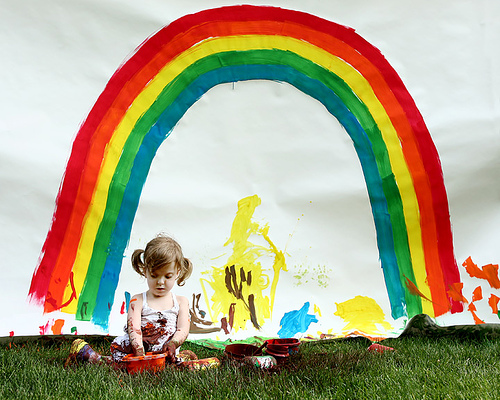

True Caption: little girl covered in paint sits in front of painted rainbow with her hands in bowl
Predicted Caption: couple and women are standing in front of display
BLEU Score: 0.1517558988729563


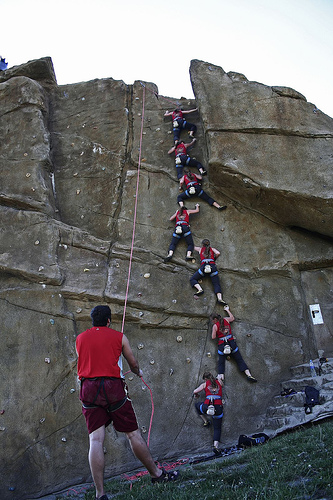

True Caption: collage of one person climbing cliff
Predicted Caption: two two men are posing in rocks
BLEU Score: 0


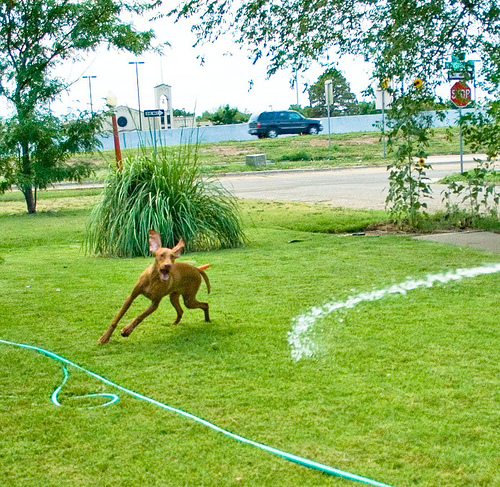

True Caption: brown dog chases the water from sprinkler on lawn
Predicted Caption: dog chasing ball
BLEU Score: 0.10283257773094409


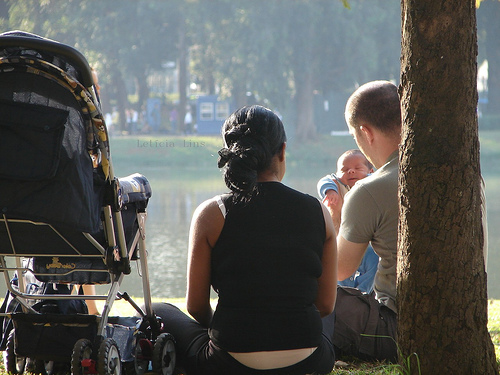

True Caption: couple and an infant being held by the male sitting next to pond with near by stroller
Predicted Caption: man helps up his dinner event
BLEU Score: 0


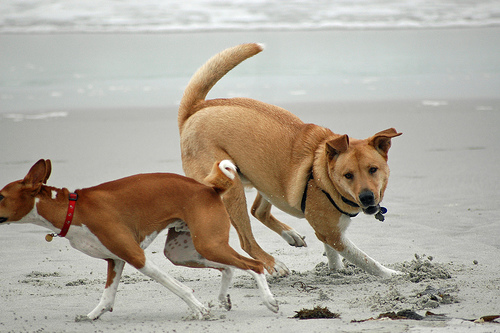

True Caption: two different breeds of brown and white dogs play on the beach
Predicted Caption: brown dog is running on the dirt road
BLEU Score: 0.2918005230159874
Good Caption


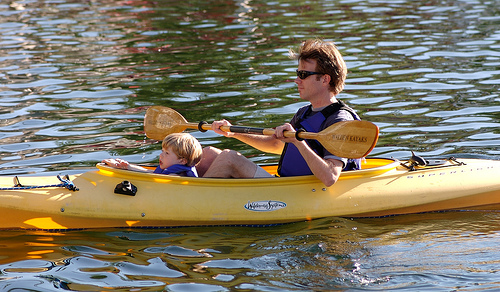

True Caption: man and baby are in yellow kayak on water
Predicted Caption: child in pink dog sit on the view of the water
BLEU Score: 0.7226568811456053


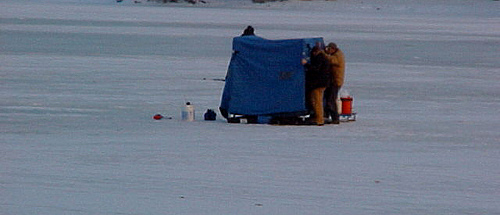

True Caption: tent is being set up on the ice
Predicted Caption: boy is riding along the snow near river
BLEU Score: 0.7071067811865476


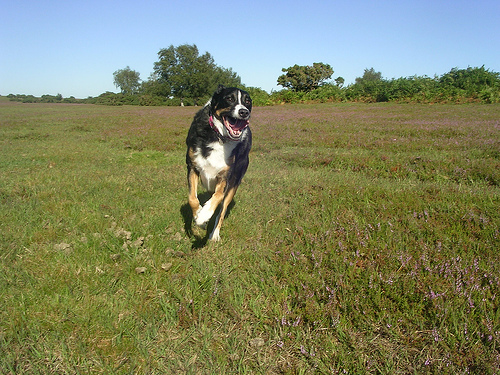

True Caption: black and white dog is running through the field
Predicted Caption: black dog and brown dog in its mouth runs through grassy field
BLEU Score: 0.8034284189446518


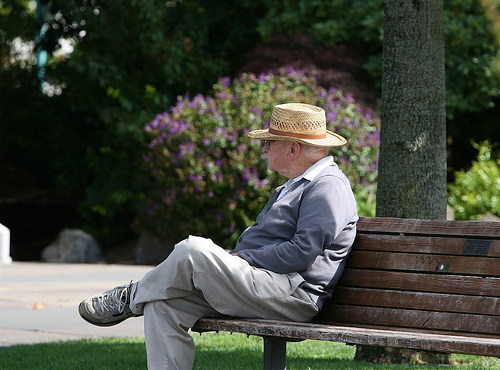

True Caption: elderly man in straw hat is sitting on bench
Predicted Caption: boy in white shirt and white shirt is standing on wooden sidewalk
BLEU Score: 0.7071067811865476


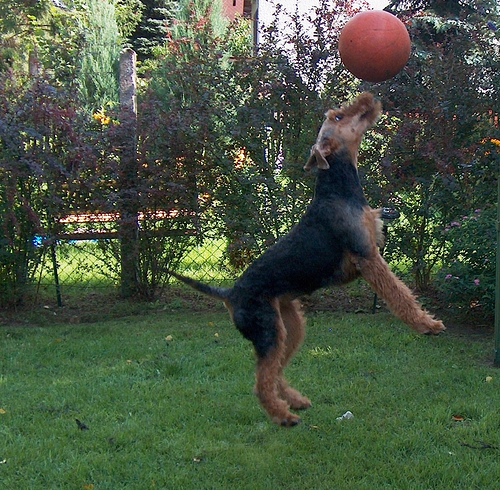

True Caption: big dog catches ball on his nose
Predicted Caption: dog is jumping with ball in red ball
BLEU Score: 0.7071067811865476


In [29]:
from PIL import Image
import IPython.display as display
import io

def display_images_with_captions(predictions):
    for bleu, jpgfnm, caption_true, caption in predictions:
        filename = images_path+ '/' + jpgfnm
        image = Image.open(filename)
        display.display(image)

        caption_true_str = ' '.join(caption_true)
        caption_str = ' '.join(caption)
        
        print("True Caption:", caption_true_str)
        print("Predicted Caption:", caption_str)
        print("BLEU Score:", bleu)
        print("=" * 50)

print("Bad Caption")
display_images_with_captions(pred_bad)
print("Good Caption")
display_images_with_captions(pred_good)
